# Hybrid
Going to attempt a hybrid model after the example of [this Teck Meng Wong notebook](https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series/notebook).

- 20220122: Going to try to form ensembles, with more code architecture. Forecasting models will include Prophet, NeuralProphet, Ridge, and Linear (with more to come -- e.g. perhaps transformers and other DNNs); residual models will include GBMs, perhaps some tabular DNNs too.

In [1]:
# notebook configuration
# if '/sf/' in pwd:
#     COLAB, SAGE = False, False
# elif 'google.colab' in str(get_ipython()):
#     COLAB, SAGE = True, False # do colab-specific installs later
# else:
#     COLAB, SAGE = False, True
    
CONTEXT = 'local' # or 'colab', 'sage', 'kaggle'
USE_GPU = True 
%config Completer.use_jedi = False

## Imports

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import requests # for telegram notifications
from tqdm.notebook import tqdm

from joblib import dump, load

import datetime as dt

Now, non-stdlib imports

In [3]:
# model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# normalization
# from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# from gauss_rank_scaler import GaussRankScaler

# feature generation
# import category_encoders as ce

# models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
# from pytorch_widedeep import Trainer
# from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
# from pytorch_widedeep.models import Wide, TabMlp, WideDeep, SAINT#, TabTransformer, TabNet, TabFastFormer, TabResnet
# from pytorch_widedeep.metrics import Accuracy
# from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

# feature reduction
# from sklearn.decomposition import PCA
# from umap import UMAP

# clustering
# from sklearn.cluster import DBSCAN, KMeans
# import hdbscan

# feature selection
# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
# import featuretools as ft
# from BorutaShap import BorutaShap
# from boruta import BorutaPy

# tracking 
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [4]:
# # time series
# import tsfresh

# import darts
# from darts import TimeSeries
# from darts.models import ExponentialSmoothing, AutoARIMA, ARIMA, Prophet, RandomForest, RegressionEnsembleModel, RegressionModel, TFTModel, TCNModel, TransformerModel, NBEATSModel
import holidays
import dateutil.easter as easter
from prophet import Prophet
from neuralprophet import NeuralProphet

## Routing

Now, datapath setup

In [5]:
if CONTEXT == 'colab':
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    # datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/dec2021/')
    root = Path('') # TODO

elif CONTEXT == 'sage':
    root = Path('') # TODO
    
elif CONTEXT == 'kaggle':
    root = Path('') # TODO
    
else: # if on local machine
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    studypath = root/'studies'
    
    for pth in [datapath, predpath, subpath, studypath]:
        pth.mkdir(exist_ok=True)

## Helpers

In [6]:
SEED = 42

# Function to seed everything but the models
def seed_everything(seed, pytorch=True, reproducible=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if pytorch:
        torch.manual_seed(seed) # set torch CPU seed
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed) # set torch GPU(s) seed(s)
        if reproducible and torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

seed_everything(seed=SEED)

In [7]:
def reduce_memory_usage(df, verbose=True):
    """
    Function to reduce memory usage by downcasting datatypes in a Pandas DataFrame when possible.
    
    h/t to Bryan Arnold (https://www.kaggle.com/puremath86/label-correction-experiments-tps-nov-21)
    """
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
tg_api_token = 'your_api_token' # for Galileo (jupyter_watcher_bot) on Telegram
tg_chat_id = 'your_chat_id'

import requests

def send_tg_message(text='Cell execution completed.'):  
    """
    h/t Ivan Dembicki Jr. for the base version 
    (https://medium.com/@ivan.dembicki.jr/notifications-in-jupyter-notebook-with-telegram-f2e892c55173)
    """
    requests.post('https://api.telegram.org/' +  'bot{}/sendMessage'.format(tg_api_token),
                  params=dict(chat_id=tg_chat_id, text=text))

In [9]:
def SMAPE(y_true, y_pred):
    '''
    h/t Jean-François Puget (@CPMP) -- see https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36414
    '''
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [10]:
# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/282735
def better_than_median(inputs, axis):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    spread_lim = 0.45
    print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
    print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
    print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [11]:
# https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [12]:
# https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

## Dataset Setup

### Original Data Loading

In [13]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    'train_source': str(datapath/'train.csv'),
    'target_source': str(datapath/'train.csv'),
    'test_source': str(datapath/'test.csv'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
orig_train_df = train_df.copy()
orig_test_df = test_df.copy()

Since the dates are natively `Object` dtype (i.e. strings), we have to convert them:

In [14]:
# https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df.date)

# for convenience later
countries = ['Sweden', 'Finland', 'Norway']
stores = ['KaggleMart', 'KaggleRama']
products = ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']

Provisionally, I'm going to concatenate together the `train_df` and `test_df` for preprocessing, to avoid having to constantly apply transforms twice (since I don't anticipate doing any transforms that might allow data leakage to occur).

In [15]:
all_df = pd.concat([train_df, test_df], axis=0)
# all_df.columns
print(len(all_df) == len(train_df) + len(test_df))
del train_df, test_df

True


### GDP Data
Here's data from Carl McBride Ellis ([notebook](https://www.kaggle.com/carlmcbrideellis/gdp-of-finland-norway-and-sweden-2015-2019) and [dataset](https://www.kaggle.com/carlmcbrideellis/gdp-20152019-finland-norway-and-sweden) for doing GDP comparisons. They're frequently used in other entries. I've created a function to add them on.

In [16]:
def add_gdp_data(df):
    gdp_df = pd.read_csv(datapath/'GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
    gdp_df.set_index('year', inplace=True)
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]

    df['gdp'] = np.log1p(df.apply(get_gdp, axis=1))
    return df

I'll also define here (but perhaps move later) the GDP exponent, which will be used to transform the targets before inference (dividing num_sold by the $GDP^{1.212}$ and then taking the logarithm (after @ambrosm)

In [17]:
gdp_exponent = 1.2121103201489674 # see https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model for an explanation

In [18]:
all_df = add_gdp_data(all_df)

In [19]:
all_df

row_id       date  country       store         product  num_sold  \
0          0 2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0   
1          1 2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0   
2          2 2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0   
3          3 2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0   
4          4 2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0   
...      ...        ...      ...         ...             ...       ...   
6565   32863 2019-12-31   Sweden  KaggleMart      Kaggle Hat       NaN   
6566   32864 2019-12-31   Sweden  KaggleMart  Kaggle Sticker       NaN   
6567   32865 2019-12-31   Sweden  KaggleRama      Kaggle Mug       NaN   
6568   32866 2019-12-31   Sweden  KaggleRama      Kaggle Hat       NaN   
6569   32867 2019-12-31   Sweden  KaggleRama  Kaggle Sticker       NaN   

           gdp  
0     5.461456  
1     5.461456  
2     5.461456  
3     5.461456  
4     5.461456  
...        ...  
6565  6.282042  
6566  6.282042  
6567  6.282042  
6568  6.282042  
6569  6.282042  

[32868 rows x 7 columns]

## Feature Engineering

### Time Features

The goal of this function is to create features that will capture seasonalities -- but **not** trends. The trends will (hopefully) be captured by the deployment of linear forecasting algorithms on raw time series data (consisting exclusively of dates and targets); we want to have seasonalities that the residual models can learn, however -- holidays, weekly patterns, climactic season patterns, etc.

The cell below will generate the `holidays` library's entries for the three countries. I may want to follow the template of @teckmengwong's code below, and add more holidays -- then, do some feature importance checking, and perhaps whittle down the features accordingly.

In [20]:
for c in [holidays.Finland, holidays.Sweden, holidays.Norway]:
#     print(c)
    for h in c(years = [2019], observed=True).items():
#         print(h)
        pass

In [21]:
def temporal_engineering(df):
    '''
    Function inspired by / borrowing from @teckmengwong and @ambrosm to create time features that will
    capture seasonality.
    '''
    
#     df[YEAR] = df[DATE].dt.year
    df['month'] = df['date'].dt.month
#     df['week'] = df['date'].dt.week # not used by Teck Meng Wong
#     df['day'] = df['date'].dt.day # not used by Teck Meng Wong
#     df['day_of_year'] = df['date'].dt.dayofyear # not used by Teck Meng Wong
#     df['day_of_month'] = df['date'].dt.days_in_month # not used by Teck Meng Wong
#     df['day_of_week'] = df['date'].dt.dayofweek # not used by Teck Meng Wong
#    df['weekday'] = df['date'].dt.weekday # not used by Teck Meng Wong
    # Teck Meng Wong mapped the integers to first-letters in triplets
    # I'm leaving it as integers, where winter=1, spring=2, summer=3, fall=4
    df['season'] = ((df['date'].dt.month % 12 + 3) // 3) #.map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})
#     df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

    df['wd4'] = df['date'].dt.weekday == 4
    df['wd56'] = df['date'].dt.weekday >= 5
#     df['wd6'] = df['date'].dt.weekday >= 6
#     df.loc[(df.date.dt.year != 2016) & (df.date.dt.month >=3), 'day_of_year'] += 1 # fix for leap years
    
    # 21 days cyclic for lunar
    dayofyear = df.date.dt.dayofyear # for convenience
    
    # here he's creating Fourier features
    for k in range(1, 32, 4):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        df[f'finland_sin{k}'] = np.where(df['country'] == 'Finland', df[f'sin{k}'], 0)
        df[f'finland_cos{k}'] = np.where(df['country'] == 'Finland', df[f'cos{k}'], 0)
        df[f'norway_sin{k}'] = np.where(df['country'] == 'Norway', df[f'sin{k}'], 0)
        df[f'norway_cos{k}'] = np.where(df['country'] == 'Norway', df[f'cos{k}'], 0)
        df[f'store_sin{k}'] = np.where(df['store'] == 'KaggleMart', df[f'sin{k}'], 0)
        df[f'store_cos{k}'] = np.where(df['store'] == 'KaggleMart', df[f'cos{k}'], 0)
        df[f'mug_sin{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'sin{k}'], 0)
        df[f'mug_cos{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'cos{k}'], 0)
        df[f'sticker_sin{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'sin{k}'], 0)
        df[f'sticker_cos{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'cos{k}'], 0)
    
#     df[f'semiweekly_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 14)
#     df[f'semiweekly_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 14)
#     df[f'lunar_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 21)
#     df[f'lunar_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 21)
    df[f'season_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 91.5)
    df[f'season_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 91.5)
#     df = pd.concat([df, pd.DataFrame({f'fin{ptr[1]}':
#                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Finland')
#                                       for ptr in holidays.Finland(years = [2015,2016,2017,2018,2019]).items()})], axis=1)
#     df = pd.concat([df, pd.DataFrame({f'nor{ptr[1]}':
#                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Norway')
#                                       for ptr in holidays.Norway(years = [2015,2016,2017,2018,2019]).items()})], axis=1)
#     df = pd.concat([df, pd.DataFrame({f'swe{ptr[1]}':
#                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Sweden')
#                                       for ptr in holidays.Sweden(years = [2015,2016,2017,2018,2019]).items()})], axis=1)

    # End of year
    # Dec - teckmengwong
    for d in range(24, 32):
        df[f"dec{d}"] = (df.date.dt.month == 12) & (df.date.dt.day == d)
    # I'm unsure of the logic of only doing this for Norway
    for d in range(24, 32):
        df[f"n-dec{d}"] = (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
    
    # not sure why he's using different date ranges for each country here
    # Jan - teckmengwong
    for d in range(1, 14):
        df[f"f-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
    for d in range(1, 10):
        df[f"n-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
    for d in range(1, 15):
        df[f"s-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
    
    
    # May - tekcmengwong
    for d in list(range(1, 10)): # May Day and after, I guess
        df[f"may{d}"] = (df.date.dt.month == 5) & (df.date.dt.day == d)
    for d in list(range(19, 26)):
        df[f"may{d}"] = (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
    # June 
    for d in list(range(8, 14)):
        df[f"june{d}"] = (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
    
    #Swedish Rock Concert - teckmengwong
    #Jun 3, 2015 – Jun 6, 2015
    #Jun 8, 2016 – Jun 11, 2016
    #Jun 7, 2017 – Jun 10, 2017
    #Jun 6, 2018 – Jun 10, 2018
    #Jun 5, 2019 – Jun 8, 2019
    swed_rock_fest  = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-6')),
                                         2016: pd.Timestamp(('2016-06-11')),
                                         2017: pd.Timestamp(('2017-06-10')),
                                         2018: pd.Timestamp(('2018-06-10')),
                                         2019: pd.Timestamp(('2019-06-8'))})

    df = pd.concat([df, pd.DataFrame({f"swed_rock_fest{d}":
                                      (df.date - swed_rock_fest == np.timedelta64(d, "D")) & (df.country == 'Sweden')
                                      for d in list(range(-3, 3))})], axis=1)

    
    # Last Wednesday of June - teckmengwong
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    for d in list(range(-4, 6)):
        df[f"wed_june{d}"] = (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
        
    # First Sunday of November - teckmengwong
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    df = pd.concat([df, pd.DataFrame({f"sun_nov{d}":
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country == 'Norway')
                                      for d in list(range(0, 9))})], axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December) -teckmengwong
    df = pd.concat([df, pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})], axis=1)
    
    # Easter -teckmengwong
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df = pd.concat([df, pd.DataFrame({f"easter{d}":
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})], axis=1)
    
    return df

In [22]:
temporal_all_df = temporal_engineering(all_df)

In [23]:
temporal_all_df

row_id       date  country       store         product  num_sold  \
0          0 2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0   
1          1 2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0   
2          2 2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0   
3          3 2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0   
4          4 2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0   
...      ...        ...      ...         ...             ...       ...   
6565   32863 2019-12-31   Sweden  KaggleMart      Kaggle Hat       NaN   
6566   32864 2019-12-31   Sweden  KaggleMart  Kaggle Sticker       NaN   
6567   32865 2019-12-31   Sweden  KaggleRama      Kaggle Mug       NaN   
6568   32866 2019-12-31   Sweden  KaggleRama      Kaggle Hat       NaN   
6569   32867 2019-12-31   Sweden  KaggleRama  Kaggle Sticker       NaN   

           gdp  month  season    wd4  ...  easter47  easter50  easter51  \
0     5.461456      1       1  False  ...     False     False     False   
1     5.461456      1       1  False  ...     False     False     False   
2     5.461456      1       1  False  ...     False     False     False   
3     5.461456      1       1  False  ...     False     False     False   
4     5.461456      1       1  False  ...     False     False     False   
...        ...    ...     ...    ...  ...       ...       ...       ...   
6565  6.282042     12       1  False  ...     False     False     False   
6566  6.282042     12       1  False  ...     False     False     False   
6567  6.282042     12       1  False  ...     False     False     False   
6568  6.282042     12       1  False  ...     False     False     False   
6569  6.282042     12       1  False  ...     False     False     False   

      easter52  easter53  easter54  easter55  easter56  easter57  easter58  
0        False     False     False     False     False     False     False  
1        False     False     False     False     False     False     False  
2        False     False     False     False     False     False     False  
3        False     False     False     False     False     False     False  
4        False     False     False     False     False     False     False  
...        ...       ...       ...       ...       ...       ...       ...  
6565     False     False     False     False     False     False     False  
6566     False     False     False     False     False     False     False  
6567     False     False     False     False     False     False     False  
6568     False     False     False     False     False     False     False  
6569     False     False     False     False     False     False     False  

[32868 rows x 246 columns]

At this point, the `temporal_all_df` DataFrame contains all the time features for both the training and testing sets.
* **Todo**: consider not only adding in holidays from `holidays`, but also borrowing ideas from the AmbrosM Linear notebook too (which creates fewer features, populating them instead with temporal distances from the selected holidays).

### Target Transformation
Now, I'll do the target transformation proposed by @AmbrosM. (I'll do it to the non-encoded DataFrame too, for testing with Prophet and NeuralProphet later.)

In [24]:
for df in [temporal_all_df]:
    df['target'] = np.log(df['num_sold'] / df['gdp']**gdp_exponent)

In [25]:
# encoded_all_df['target'] = np.log(encoded_all_df['num_sold'] / (encoded_all_df['gdp']**gdp_exponent))

In [26]:
temporal_all_df

row_id       date  country       store         product  num_sold  \
0          0 2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0   
1          1 2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0   
2          2 2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0   
3          3 2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0   
4          4 2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0   
...      ...        ...      ...         ...             ...       ...   
6565   32863 2019-12-31   Sweden  KaggleMart      Kaggle Hat       NaN   
6566   32864 2019-12-31   Sweden  KaggleMart  Kaggle Sticker       NaN   
6567   32865 2019-12-31   Sweden  KaggleRama      Kaggle Mug       NaN   
6568   32866 2019-12-31   Sweden  KaggleRama      Kaggle Hat       NaN   
6569   32867 2019-12-31   Sweden  KaggleRama  Kaggle Sticker       NaN   

           gdp  month  season    wd4  ...  easter50  easter51  easter52  \
0     5.461456      1       1  False  ...     False     False     False   
1     5.461456      1       1  False  ...     False     False     False   
2     5.461456      1       1  False  ...     False     False     False   
3     5.461456      1       1  False  ...     False     False     False   
4     5.461456      1       1  False  ...     False     False     False   
...        ...    ...     ...    ...  ...       ...       ...       ...   
6565  6.282042     12       1  False  ...     False     False     False   
6566  6.282042     12       1  False  ...     False     False     False   
6567  6.282042     12       1  False  ...     False     False     False   
6568  6.282042     12       1  False  ...     False     False     False   
6569  6.282042     12       1  False  ...     False     False     False   

      easter53  easter54  easter55  easter56  easter57  easter58    target  
0        False     False     False     False     False     False  3.738239  
1        False     False     False     False     False     False  4.196010  
2        False     False     False     False     False     False  2.925788  
3        False     False     False     False     False     False  4.291321  
4        False     False     False     False     False     False  4.756724  
...        ...       ...       ...       ...       ...       ...       ...  
6565     False     False     False     False     False     False       NaN  
6566     False     False     False     False     False     False       NaN  
6567     False     False     False     False     False     False       NaN  
6568     False     False     False     False     False     False       NaN  
6569     False     False     False     False     False     False       NaN  

[32868 rows x 247 columns]

### Label Encoding

I'm going to encapsulate this in a function so that it can be invoked just-in-time, in the hopes of avoiding confusions with DataFrames.

In [27]:
def label_encoder(df):
    from sklearn.preprocessing import LabelEncoder
    features = ['country', 'product', 'store']
    le_dict = {feature: LabelEncoder().fit(orig_train_df[feature]) for feature in features}
    enc_df = df.copy()
    for feature in features:
        enc_df[feature] = le_dict[feature].transform(df[feature])
    return le_dict, enc_df

In [28]:
# for key in le_dict.keys():
#     print(f"Values for key {key} are {le_dict[key].inverse_transform(range(len(le_dict[key].values())))}")#"
# print(le_dict['country'].inverse_transform([0,1,2]))
# print(le_dict['product'].inverse_transform([0,1,2]))
# print(le_dict['store'].inverse_transform([0,1]))

```
['Finland' 'Norway' 'Sweden']
['Kaggle Hat' 'Kaggle Mug' 'Kaggle Sticker']
['KaggleMart' 'KaggleRama']
```

Now, we'll do the encoding.

At this point, the `encoded_all_df` can be used -- perhaps with a call to `LabelEncoder.inverse_transform` -- to recover the "original" data when necessary (e.g. for feeding it into Prophet and NeuralProphet)

In [29]:
# encoded_all_df = label_encoder(temporal_all_df)

### Pseudolabeling

I'm not going to try this right now, but I may return to it later -- I note that Teck Meng Wong had some good results with it.

### Data Splitting, Modification

Now that the preprocessing is done, I'm going to split the data back into the train and test sets; then, I'll create a view on the dataframes that omits the year. The year-less dataframes will be suitable for residual learning.

In [30]:
# all_df = encoded_all_df.drop(columns=['num_sold', 'row_id'])
all_df = temporal_all_df.drop(columns=['row_id']) # writing over the previous version of `all_df`

In [31]:
tv_df = all_df[:len(orig_train_df)] # training and validation sets -- still not encoded
test_df = all_df[len(orig_train_df):] # still not encoded


In [32]:
# train_df = encoded_all_df.iloc[np.where(encoded_all_df['date'] < '2019-01-01'), :]
# test_df = encoded_all_df[[np.where(encoded_all_df['date'] > '2018-12-31')]]

# encoded_tv_df = encoded_all_df.drop(columns=['row_id'])[:len(orig_train_df)]
# encoded_test_df = encoded_all_df.drop(columns=['row_id'])[len(orig_train_df):]

# valid_df = tv_df[tv_df['date'] > '2017-12-31']
# train_df = tv_df[tv_df['date'] <= '2017-12-31']

# train_and_valid_residual_df = train_and_valid_df.drop(columns=['date'])
# test_residual_df = test_df.drop(columns=['date'])

# len(valid_df) + len(train_df) == len(tv_df)

# encoded_tv_df

# Training

### Forecasting Models Prep
First, we'll set up functions to handle the training of forecasting models which will discern trends, and which may -- or may not -- yield insights concerning seasonality. While the Scikit-Learn models will be able to share a single trainer function, the Prophet and NeuralProphet models have subtly different expectations of their data, and as such will require separate handling.

In [33]:
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
from neuralprophet import NeuralProphet
# earth? wouldn't install via pip on my machine at first

In [34]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from skorch import NeuralNetRegressor
import torch.optim as optim

#### (Preprepared Preds)

The next cell contains code to import already-existing predictions -- but I think it's better to centralize the code that produces them here, and will comment out the import code for now.

In [35]:
# prophet_trainset = load(predpath/'20220121_prophet_baseline_trainset.joblib')

# neural_trainset = load(predpath/'20220121_neuralprophet_baseline_trainset.joblib')
# neural_test_preds = load(predpath/'20220121_neuralprophet_baseline_testset.joblib')

# ridge_tv_preds = load(predpath/'20210121_ridge_baseline_trainset_preds.joblib')
# ridge_test_preds = load(predpath/'20220121_ridge_testset_preds.joblib')

And this cell would handle the parsing

In [36]:
# neural_tv_preds = neural_trainset['prophet_forecast']
# prophet_tv_preds = prophet_trainset['prophet_forecast']

# neural_train_preds = neural_tv_preds[:train_length]
# neural_valid_preds = neural_tv_preds[train_length:]

# prophet_train_preds = prophet_tv_preds[:train_length]
# prophet_valid_preds = prophet_tv_preds[train_length:]

# train_length = len(neural_trainset[neural_trainset['date'] <= '2017-12-31'])

# ridge_train_preds = ridge_tv_preds[:train_length]
# ridge_valid_preds = ridge_tv_preds[train_length:]

#### Scikit-Learn Linear Models Prep

Linear models from Scikit-Learn seemingly require that datetime data be converted to numerics.

In [37]:
# train_linear_df = train_df.copy()
# valid_linear_df = valid_df.copy()
# test_linear_df = test_df.copy()
# tv_linear_df = tv_df.copy()



### Forecasters

#### Hyperparameters
I'll hard-code them for now, but in the future may Optuna them. May want to create a dict of all the kwargs to be used for all the models, with the model names as keys

In [38]:
prophet_kwargs = {
    'growth':'linear',
#     'holidays':holidays_train, # will add this in-function
    'n_changepoints':10,
    'changepoint_range':0.4,
    'yearly_seasonality':True,
    'weekly_seasonality':True,
    'daily_seasonality':False,
    'seasonality_mode':'additive',
    'seasonality_prior_scale':25,
    'holidays_prior_scale':100,
    'changepoint_prior_scale':0.01,
    'interval_width':0.5,
    'uncertainty_samples':False
}

neuralprophet_kwargs = {
    'growth':'linear',
    'n_changepoints':10,
    'changepoints_range':0.4,
    'trend_reg':1,
    'trend_reg_threshold':False,
    'yearly_seasonality':True,
    'weekly_seasonality':True,
    'daily_seasonality':False,
    'seasonality_mode':'additive',
    'seasonality_reg':1,
    'n_forecasts':365,
    'normalize':'off'
}

# for pytorch / skorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tcn_kwargs = {
#     'module': estimator, # will be handled at-call
    'criterion': nn.MSELoss, # consider enhancement here
    "lr": 0.01, # default is 0.01
    'optimizer':Adam,
    'max_epochs':10, # default is 10
    'device':device,
}

# model_params['hyperparams'] = str(neuralprophet_kwargs)
# model_params['holiday_source'] = 'Prophet builtin for each country'

In [39]:
xgboost_params = {
#     'tree_method': 'gpu_hist',
#     'predictor': 'gpu_predictor',
#     'eval_metric': ['mae', 'mape', 'rmse'],
    'learning_rate': .09,
    'max_depth': 0,
    'subsample': .15,
#     'sampling_method': 'gradient_based',
#     'seed': 42,
#     'grow_policy': 'lossguide',
    'max_leaves': 255,
    'lambda': 100,
#     'n_estimators': 3000,
#     'objective': 'reg:squarederror',
    'n_estimators': 50,
#     'verbose': True,
}


lightgbm_params = {
    'objective': 'mse',
    'random_state': 42,
    'device_type': 'cpu',
    'n_jobs': -1,
#                 eval_metric='auc',
#     'device_type': 'gpu',
#     'max_bin': 63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
#     'gpu_use_dp': False,
    'max_depth': 0,
    'learning_rate': 0.1,
    'subsample': .15,
    'n_estimators': 1500,
}

catboost_params = {
    'task_type':'GPU',
    'silent':True,
    'random_state':42,
}
                

#### Temporal Convolutional Network

Implementation from https://www.kaggle.com/ceshine/pytorch-temporal-convolutional-networks.

In [40]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        # this is the first convolutional layer; note that it foregoes padding irrespective of argument
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        # the padding is then added after the first conv layer
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        # this is a very standard choice
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # the second convolutional layer in the block is identical to the first, but now padding has been added to the input
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        
        # this simply strings together the above architectural elements, for convenience I guess
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        
        # if the n_outputs is nonzero, this adds on a final convlutional layer to ensure that we get the desired number of outputs
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
        # this initializes the weights as specified in the separate weight initialization method, below
        self.init_weights()

    def init_weights(self):
        # this method initializes the weights for the Conv1D and Conv2D layers, plus the Downsample layer (if it's used)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        # note the nice one-liner here, to add in the requisite number of dimensions both inbound to the NN and outbound
        out = self.net(x.unsqueeze(2)).squeeze(2)
        # is this a residual, then?
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

In [41]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [42]:
class TCNModel(nn.Module):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            128, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))

#### Trainers

##### NeuralProphet
I'm leaving the folds as they are. ~~Label encoding shouldn't matter -- the values are just being iterated over anyway.~~ It does matter because the Prophets use the strings to identify countries' holidays to add. Not sure about doing the target transform -- if you try it, just have the trainer call pass `target='target'`.

In [43]:
prophet_folds = [
    ('2015-01-01', '2018-01-01'),
    ('2018-01-01', '2019-01-01'),
]

In [44]:
# prophet_tv_df = tv_df_encoded.copy() # encoded_tv_df.copy()
# prophet_test_df = test_df_encoded.copy() # encoded_test_df.copy()

In [45]:
# for feature in ['country', 'product', 'store']:
#     prophet_tv_df[feature] = orig_train_df[feature]
#     prophet_test_df[feature] = orig_test_df[feature]


In [46]:
# prophet_tv_df.head()

In [47]:
# countries_enc = le_dict['country'].transform(countries)
# stores_enc = le_dict['store'].transform(stores)
# products_enc = le_dict['product'].transform(products)

# countries, countries_enc

In [48]:
def neuralprophet_trainer(model_kwargs=neuralprophet_kwargs, countries=countries, stores=stores, products=products, folds=prophet_folds, 
                          tv_df=tv_df, test_df=test_df,
#                           df_train=tv_df, df_test=test_df, 
                          target='num_sold', wandb_tracked=False):
    train_smape = 0
    val_smape = 0
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    # no label encoding here -- but test it with too
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (df_train['date'] >= start) &\
                                (df_train['date'] < end) &\
                                (df_train['country'] == country) &\
                                (df_train['store'] == store) &\
                                (df_train['product'] == product)

                    # redefine the training set in the local (holdout) sense
                    train = df_train.loc[train_idx, ['date', target]].reset_index(drop=True)

                    val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                              (df_train['date'] < folds[fold + 1][1]) &\
                              (df_train['country'] == country) &\
                              (df_train['store'] == store) &\
                              (df_train['product'] == product)

                    val = df_train.loc[val_idx, ['date', target]].reset_index(drop=True)

                    # rename the columns for standardization (this seems conventional)
                    train = train.rename(columns={'date': 'ds', target: 'y'})
                    val = val.rename(columns={'date': 'ds', target: 'y'})

#                     model = Prophet(**prophet_kwargs)
                    model = NeuralProphet(**model_kwargs)

                    model = model.add_country_holidays(country_name=country) # uses FacebookProphet or NeuralProphet API to add holidays
                    print(train.columns)
                    model.fit(train, freq='D') # neuralprophet
                    # prophet
#                     train_predictions = model.predict(train[['ds']])['yhat']
#                     val_predictions = model.predict(val[['ds']])['yhat']
                    # neuralprophet
                    train_predictions = model.predict(train)['yhat1']
                    val_predictions = model.predict(val)['yhat1']
                    df_train.loc[train_idx, 'neuralprophet_forecast'] = train_predictions.values
                    df_train.loc[val_idx, 'neuralprophet_forecast'] =  val_predictions.values

                    train_score = SMAPE(train['y'].values, train_predictions.values)
                    val_score = SMAPE(val['y'].values, val_predictions.values)
            
                    if wandb_tracked:
                        wandb.log({f"{(country,store,product)}_valid_smape": val_score})
            
                    train_smape += train_score
                    val_smape += val_score
            
                    print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                    print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')

                    test_idx = (df_test['country'] == country) &\
                               (df_test['store'] == store) &\
                               (df_test['product'] == product)
                    test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                    
                    test = test.rename(columns={'date': 'ds'})
                    test['y'] = np.nan
                    test_predictions = model.predict(test)['yhat1']
                    
                    
                    df_test.loc[test_idx, 'neuralprophet_forecast'] = test_predictions.values
    
    train_smape /= (3*2*3)
    val_smape /= (3*2*3)
#     train_
    
    if wandb_tracked:
        wandb.log({'overall_train_smape': train_smape, 'overall_valid_smape': val_smape})
        wandb.finish()
    return df_train['neuralprophet_forecast'], df_test['neuralprophet_forecast']#, train_smape, val_smape

##### Prophet Trainer

In [49]:
def prophet_trainer(prophet_kwargs=prophet_kwargs, countries=countries, stores=stores, products=products, folds=prophet_folds, 
                    tv_df=tv_df, test_df=test_df,
#                           df_train=tv_df, df_test=test_df, 
                    target='num_sold', wandb_tracked=False):
    train_smape = 0
    val_smape = 0
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (df_train['date'] >= start) &\
                                (df_train['date'] < end) &\
                                (df_train['country'] == country) &\
                                (df_train['store'] == store) &\
                                (df_train['product'] == product)
                    
#                     print(train_idx)

                    # redefine the training set in the local (holdout) sense
                    train = df_train.loc[train_idx, ['date', target]].reset_index(drop=True)
#                     print(train.shape)

                    val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                              (df_train['date'] < folds[fold + 1][1]) &\
                              (df_train['country'] == country) &\
                              (df_train['store'] == store) &\
                              (df_train['product'] == product)

                    val = df_train.loc[val_idx, ['date', target]].reset_index(drop=True)

                    # rename the columns for standardization (this seems conventional)
                    train = train.rename(columns={'date': 'ds', target: 'y'})
                    val = val.rename(columns={'date': 'ds', target: 'y'})

                    model = Prophet(**prophet_kwargs)

                    model.add_country_holidays(country_name=country) # uses FacebookProphet API to add holidays
                    model.fit(train)
        
                    train_predictions = model.predict(train[['ds']])['yhat']
                    val_predictions = model.predict(val[['ds']])['yhat']
                    df_train.loc[train_idx, 'prophet_forecast'] = train_predictions.values
                    df_train.loc[val_idx, 'prophet_forecast'] =  val_predictions.values

                    train_score = SMAPE(train['y'].values, train_predictions.values)
                    val_score = SMAPE(val['y'].values, val_predictions.values)
            
                    if wandb_tracked:
                        wandb.log({f"{(country,store,product)}_valid_smape": val_score})
            
                    train_smape += train_score
                    val_smape += val_score
            
                    print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                    print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')

                    test_idx = (df_test['country'] == country) &\
                               (df_test['store'] == store) &\
                               (df_test['product'] == product)
                    test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                    
                    test = test.rename(columns={'date': 'ds'})
                    test_predictions = model.predict(test[['ds']])['yhat']
                    
                    
                    df_test.loc[test_idx, 'prophet_forecast'] = test_predictions.values
    
    train_smape /= (3*2*3)
    val_smape /= (3*2*3)
    
    if wandb_tracked:
        wandb.log({'overall_train_smape': train_smape, 'overall_valid_smape': val_smape})
        wandb.finish()
    return df_train['prophet_forecast'], df_test['prophet_forecast']#, train_smape, val_smape

##### Scikit-Learn Models

In [50]:
def sklearn_trainer(estimator, model_kwargs={}, tv_df=tv_df, test_df=test_df, #X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
                    folds=prophet_folds, countries=countries, stores=stores, products=products, target='target',
#                     by_combo=True, 
                    model_type=None, # None -> fully scikit-learn compatible; alternatives are 'skorch' or 'gbm'
                    wandb_tracked=False):
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, tv_df = label_encoder(df_train) # should leave broader scope's tv_df alone
    _, test_df = label_encoder(df_test) # should leave broader scope's test_df alone
    del df_train, df_test
    
    # encode the lists of countries, stores, and products
    countries = le_dict['country'].transform(countries)
    stores = le_dict['store'].transform(stores)
    products = le_dict['product'].transform(products)
    
    train_smape = 0
    val_smape = 0
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    # drop whichever version of the dependent variable is not being used
#     for df in [tv_df, test_df]:
    if target == 'num_sold': 
        tv_df = tv_df.drop(columns=['target'])
        test_df = test_df.drop(columns=['target'])
    else:
        tv_df = tv_df.drop(columns=['num_sold'])
        test_df = test_df.drop(columns=['num_sold'])
            
#     print("'num_sold' in test_df.columns == ", 'num_sold' in test_df.columns)
    
    # handling each combination of country, store, and product separately
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (tv_df['date'] >= start) &\
                                (tv_df['date'] < end) &\
                                (tv_df['country'] == country) &\
                                (tv_df['store'] == store) &\
                                (tv_df['product'] == product)

#                     print(train_idx)

                    # redefine the training set in the local (holdout) sense
                    train = tv_df.loc[train_idx, :].reset_index(drop=True)
#                         print(train.shape)

                    val_idx = (tv_df['date'] >= folds[fold + 1][0]) &\
                              (tv_df['date'] < folds[fold + 1][1]) &\
                              (tv_df['country'] == country) &\
                              (tv_df['store'] == store) &\
                              (tv_df['product'] == product)

                    val = tv_df.loc[val_idx, :].reset_index(drop=True)

                    test_idx = (test_df['country'] == country) &\
                               (test_df['store'] == store) &\
                               (test_df['product'] == product)
                    test = test_df.loc[test_idx, :].reset_index(drop=True)

                    # with the training and validation sets sorted out, make them integers for model fitting
                    for df in [train, val, test]:
                        df['date'] = df['date'].map(dt.datetime.toordinal)
                    if 'model_forecast' in train.columns:
                        X = train.drop(columns=[target, 'model_forecast'])
                        X_valid = val.drop(columns=[target, 'model_forecast'])
                        X_test = test.drop(columns=[target, 'model_forecast'])
                    else:
                        X = train.drop(columns=[target])
                        X_valid = val.drop(columns=[target])
                        X_test = test.drop(columns=[target])

                    y = train[target]
                    y_valid = val[target]


#                         print(type(X), type(y))
#                         print(f"X has {X.isna().any().sum()} NaNs")
#                         print(f"y has {y.isna().sum()} NaNs")
#                     print(X_test.info())
#                     print(y_valid.dtype)
    
                    if model_type == 'skorch':
#                         for df in [X, X_valid, X_test]:
# #                             df['date'] = df['date'].apply(dt.datetime.toordinal)
#                             df = torch.tensor(df.to_numpy(dtype=np.float32))
#                         for target in [y, y_valid]:
#                             target = torch.tensor(np.array(target))
# #                             target = target.reshape(-1,1)
#                             target = target.unsqueeze(0)
                        X = torch.tensor(X.to_numpy(dtype=np.float32))
                        X_valid = torch.tensor(X_valid.to_numpy(dtype=np.float32))
                        X_test = torch.tensor(X_test.to_numpy(dtype=np.float32))
            
                        y = torch.tensor(np.array(y)).reshape(-1,1)
                        y_valid = torch.tensor(np.array(y)).reshape(-1,1)
    
                        tcn_kwargs = {
                            'num_channels': X_valid.shape[0] * X_valid.shape[1]
                        }
                        print(type(y), type(y_valid))
#                         y = y.reshape(-1,1)
#                         y_valid = y_valid.reshape(-1,1)
                        # create the Datasets
                
                        # create the DataLoaders

                        # instantiate the wrapper
                        model = NeuralNetRegressor(
                            module=estimator(**tcn_kwargs),
                            **model_kwargs
                        )
#                     elif model_type=='gbm':
                        
                    else:
                        model = estimator(**model_kwargs)

                    model.fit(X,y)

                    model_train_preds = model.predict(X)
                    model_valid_preds = model.predict(X_valid)
                    model_test_preds = model.predict(X_test)

                    tv_df.loc[train_idx, 'model_forecast'] = model_train_preds#.values
                    tv_df.loc[val_idx, 'model_forecast'] =  model_valid_preds#.values
                    test_df.loc[test_idx, 'model_forecast'] = model_test_preds#.values


    # reverse the dependent variable transform if appropriate
    if target == 'target':
#             model_tv_preds = np.multiply(np.exp(model_tv_preds), tv_df['gdp']**gdp_exponent)
        tv_df['model_forecast'] = np.exp(tv_df['model_forecast']) * tv_df['gdp']**gdp_exponent
#             output_tv_df['model_forecast'] = np.exp(output_tv_df['model_forecast']) * output_tv_df['gdp']**gdp_exponent

#             model_test_preds = np.multiply(np.exp(model_test_preds), test_df['gdp']**gdp_exponent)
        test_df['model_forecast'] = np.exp(test_df['model_forecast']) * test_df['gdp']**gdp_exponent
#             output_test_df['model_forecast'] = np.exp(output_test_df['model_forecast']) * output_test_df['gdp']**gdp_exponent
#             model_test_preds = np.exp(model_test_preds) * test_df['gdp']**gdp_exponent
        
#         tv_df['model_forecast'] = model_tv_preds
#         test_df['model_forecast'] = model_test_preds
#     return output_tv_df, output_test_df
    return tv_df['model_forecast'], test_df['model_forecast']
#     return tv_df['model_forecast'], test_df['model_forecast']
#     return model_tv_preds, model_test_preds
    

##### GBMs

In [51]:
from sklearn.model_selection import GroupKFold

In [81]:
def gbm_trainer(arch:str, model_kwargs={}, exmodel_config={}, tv_df=tv_df, test_df=test_df, #X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
                countries=countries, stores=stores, products=products, 
                target='target', wandb_tracked=True, random_state=42):
    
    # create local versions of the dataframes, to avoid mutation
    X = tv_df.copy()
#     X_test = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, X = label_encoder(X) # should leave broader scope's tv_df alone
#     _, X_test = label_encoder(X_test) # should leave broader scope's test_df alone
#     del df_train, df_test
    
    # encode the lists of countries, stores, and products
    countries = le_dict['country'].transform(countries)
    stores = le_dict['store'].transform(stores)
    products = le_dict['product'].transform(products)
    
#     train_smape = 0
#     val_smape = 0
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
        )
    
    # drop whichever version of the dependent variable is not being used
#     for df in [tv_df, test_df]:
    y = X[target]
#     for df in [X, X_test]:
#         df = df.drop(columns=['num_sold', 'target'])
    X = X.drop(columns=['num_sold', 'target'])
#     X = X.drop(columns)
#     if target == 'num_sold': 
#         y = X['num_sold']
#         X = X.drop(columns=['target'])
#         X_test = X_test.drop(columns=['target'])
#     else:
#         X = X.drop(columns=['num_sold'])
#         X_test = X_test.drop(columns=['num_sold'])
    
    kfold = GroupKFold(n_splits=4)
    oof_preds = pd.Series(0, index=tv_df.index)
#     oof_preds, oof_y = [], []
    
#     test_preds = np.zeros((X_test.shape[0]))
    
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(X, groups=X.date.dt.year)):
        print(f"FOLD {fold}")
        print("------------------------------")
        
        # remove dates 
#         for df in [X, X_test]:
#             df = df.drop(columns=['date'])
        if 'date' in X.columns:
            X = X.drop(columns=['date'])
#             X_test = X_test.drop(columns=['date'])#, 'num_sold'])
        
        y_train, y_valid = y[train_ids], y[valid_ids]
        X_train, X_valid = X.iloc[train_ids,:], X.iloc[valid_ids,:]
        
        if arch == 'xgboost':
            model = XGBRegressor(
                tree_method='gpu_hist',
                predictor= 'gpu_predictor',
                eval_metric=['mae', 'mape'],
                sampling_method='gradient_based',
                seed=42,
                grow_policy='lossguide',
                objective='reg:squarederror',
                **model_kwargs)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
            else:
                model.fit(X_train, y_train)
        elif arch == 'lightgbm':
            model = LGBMRegressor(**model_kwargs)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()])
            else:
                model.fit(X_train, y_train)
        elif arch == 'catboost':
            model = CatBoostRegressor(
                task_type='GPU',
                verbose= False,
                random_state=42,
                **model_kwargs)
            
        model.fit(X_train, y_train)
        
        y_valid_preds = model.predict(X_valid)
        
#         oof_preds.extend(y_valid_preds)
#         oof_y.extend(y_valid)
        oof_preds[valid_ids] = y_valid_preds
                
    if target == 'target':
        oof_preds = np.exp(oof_preds) * tv_df['gdp']**gdp_exponent
#         oof_y = np.exp(tv_df[target]) * tv_df['gdp']**gdp_exponent
#         test_preds = np.exp(test_preds) * test_df['gdp']**gdp_exponent

#     return oof_preds, test_preds
    smape = SMAPE(y_pred=oof_preds, y_true=tv_df['num_sold'])
#     print("Lengths of oof_preds and tv_df[target] are same? ", len(oof_preds) == len(tv_df[target]))
#     print(oof_preds[:10])
#     print(tv_df[target][:10])
    if wandb_tracked:
        wandb.log({
            'arch': arch,
            'SMAPE': smape,
            'model_params': str(model_kwargs),
            'model_seed': random_state
        })
        wandb.finish()
    return smape

In [82]:
best_xgboost_params = load(studypath/'optuna_xgboost_study-20220126213551.joblib').best_trial.params
best_xgboost_params['max_depth'] = best_xgboost_params['depth']
del best_xgboost_params['depth']
best_xgboost_params

{'n_estimators': 4207,
 'learning_rate': 0.05378597302351865,
 'reg_alpha': 0.0067949392113948815,
 'reg_lambda': 0.04865823628931899,
 'subsample': 0.212875760245356,
 'min_child_weight': 6.997692447967251,
 'colsample_bytree': 0.9824893256584818,
 'gamma': 0.10395228539921328,
 'max_depth': 5}

In [ ]:
gbm_trainer

### Optuna

In [54]:
# hyperparameter tuning
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
from optuna.samplers import TPESampler

# tracking 
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
os.environ['WANDB_NOTEBOOK_NAME'] = f"optuna_forecasting_{datetime.now().strftime('%Y%m%d')}.ipynb"


In [55]:
exmodel_config = {
    'cross-validation': 'GroupKFold(n_split=4)',
}

In [56]:
# wandb config:
wandb_config = {
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'tags': ['study', 'gbms'],
    'notes': "Optuna study of forecasting methods (including the time-stripped GBMs)"
}

In [57]:
arch = 'xgboost'

In [58]:
# originally from https://www.kaggle.com/satorushibata/optimize-catboost-hyperparameter-with-optuna-gpu
def objective(trial, arch=arch):#, tune_fold=tune_fold):
    """
    Wrapper around cross_validation_trainer to test different model hyperparameters
    """
    
    if arch == 'catboost':
        model_params = {
            'iterations' : trial.suggest_int('iterations', 2000, 30000),                         
            'depth' : trial.suggest_int('depth', 3, 10),                                       
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.5),               
            'random_strength': trial.suggest_int('random_strength', 0, 100), 
    #         'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
    #         'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['MVC', 'Bernoulli']),#, 'Poisson']),
            'od_wait': trial.suggest_int('od_wait', 20, 2000),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 2, 70), # aka l2_leaf_reg
            'border_count': trial.suggest_int('border_count', 50, 275),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 20), # aka min_data_in_leaf
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 5),
#             'task_type':'GPU',
#             'verbose': False,
# #             'silent':True,
#             'random_state':42,
            # 'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
    #         'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
            # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    #         'max_leaves': trial.suggest_int('max_leaves', 32, 128)
        }
        
    elif arch == 'lightgbm':
        pass # todo -- fill in tomorrow
        
    elif arch == 'xgboost':
        model_params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 10000), # was 900-4500 for CPU
            'max_depth' : trial.suggest_int('depth', 3, 10),                                       
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),               
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 50),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 30),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1),
    #         'booster': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 12),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_uniform('gamma', 0.1, 10),
#             'tree_method': 'gpu_hist',
#             'predictor': 'gpu_predictor',
#             'eval_metric': ['mae', 'mape'],
#             'sampling_method': 'gradient_based',
#             'seed': 42,
#             'grow_policy': 'lossguide',
#             'max_leaves': 255,
#             'lambda': 100,
#     'n_estimators': 3000,
#             'objective': 'reg:squarederror',
#             'n_estimators': 500,
#     'verbose': True,
            
        } 
    
    return gbm_trainer(arch=arch, model_kwargs=model_params, wandb_tracked=False)#, telegram=False)

In [59]:
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_config)

wandb: Currently logged in as: hushifang (use `wandb login --relogin` to force relogin)


#### XGBoost Study

In [60]:
arch = 'xgboost'

In [61]:
SEED = 42

In [62]:
start_time = datetime.now().strftime('%Y%m%d%H%M%S')
study = optuna.create_study(direction = "minimize", 
                            sampler = TPESampler(seed=int(SEED)), 
                            study_name=f"{arch}_study-{start_time}")

[I 2022-01-26 21:35:51,738] A new study created in memory with name: xgboost_study-20220126213551


In [63]:
%%time 
for x in range(1, 500):
    study.optimize(objective, n_trials = 1, callbacks = [wandbc], show_progress_bar=False)#, catch=(xgboost.core.XGBoostError,)) 
    dump(study, filename=studypath/f"optuna_{arch}_study-{start_time}.joblib")


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:36:52,442] Trial 0 finished with value: 8.816730737772476 and parameters: {'n_estimators': 4058, 'depth': 10, 'learning_rate': 0.06504856968981275, 'reg_alpha': 0.6502468545951017, 'reg_lambda': 0.004994757081068292, 'subsample': 0.2403950683025824, 'min_child_weight': 0.6979452624062253, 'colsample_bytree': 0.9330880728874675, 'gamma': 6.051038616257767}. Best is trial 0 with value: 8.816730737772476.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:38:12,137] Trial 1 finished with value: 9.233354829372825 and parameters: {'n_estimators': 7227, 'depth': 3, 'learning_rate': 0.2526878207508456, 'reg_alpha': 8.158738235092015, 'reg_lambda': 0.00892622738184373, 'subsample': 0.26364247048639056, 'min_child_weight': 2.2016707137313523, 'colsample_bytree': 0.6521211214797689, 'gamma': 5.295088673159155}. Best is trial 0 with value: 8.816730737772476.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:39:04,430] Trial 2 finished with value: 7.735423317730328 and parameters: {'n_estimators': 4603, 'depth': 5, 'learning_rate': 0.032781876533976156, 'reg_alpha': 0.004523529917658778, 'reg_lambda': 0.02032202659636255, 'subsample': 0.4297256589643226, 'min_child_weight': 5.473383740620215, 'colsample_bytree': 0.8925879806965068, 'gamma': 2.0767704433677614}. Best is trial 2 with value: 7.735423317730328.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:41:25,068] Trial 3 finished with value: 9.167294741541573 and parameters: {'n_estimators': 5385, 'depth': 7, 'learning_rate': 0.0013033567475147442, 'reg_alpha': 0.7158714383119805, 'reg_lambda': 0.005800389779115683, 'subsample': 0.1585464336867516, 'min_child_weight': 11.386677561502745, 'colsample_bytree': 0.9828160165372797, 'gamma': 8.103133746352965}. Best is trial 2 with value: 7.735423317730328.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:41:58,734] Trial 4 finished with value: 8.231398739113388 and parameters: {'n_estimators': 3394, 'depth': 3, 'learning_rate': 0.04953682563497157, 'reg_alpha': 0.11702088154220885, 'reg_lambda': 0.0035186816415472676, 'subsample': 0.5456592191001431, 'min_child_weight': 0.41362786486150555, 'colsample_bytree': 0.954660201039391, 'gamma': 2.6619218178401676}. Best is trial 2 with value: 7.735423317730328.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:43:14,210] Trial 5 finished with value: 9.653474293434636 and parameters: {'n_estimators': 6794, 'depth': 5, 'learning_rate': 0.01942099825171803, 'reg_alpha': 0.37065955814875856, 'reg_lambda': 0.0067238158696505896, 'subsample': 0.9726261649881027, 'min_child_weight': 9.301818747510014, 'colsample_bytree': 0.9697494707820946, 'gamma': 8.958790769233723}. Best is trial 2 with value: 7.735423317730328.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:45:17,413] Trial 6 finished with value: 9.39796547307962 and parameters: {'n_estimators': 6180, 'depth': 10, 'learning_rate': 0.0016565580440884786, 'reg_alpha': 0.008335230071817131, 'reg_lambda': 0.001593999043568401, 'subsample': 0.39279729768693794, 'min_child_weight': 4.664738798984096, 'colsample_bytree': 0.6356745158869479, 'gamma': 8.3045013406041}. Best is trial 2 with value: 7.735423317730328.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:46:04,801] Trial 7 finished with value: 7.598702438220634 and parameters: {'n_estimators': 3889, 'depth': 5, 'learning_rate': 0.022096526145513846, 'reg_alpha': 0.0045940816125026864, 'reg_lambda': 3.9042098517777197, 'subsample': 0.16709557931179375, 'min_child_weight': 11.842656352269607, 'colsample_bytree': 0.8861223846483287, 'gamma': 2.0672852471883068}. Best is trial 7 with value: 7.598702438220634.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:46:13,865] Trial 8 finished with value: 9.409320785083901 and parameters: {'n_estimators': 552, 'depth': 9, 'learning_rate': 0.0563600475052774, 'reg_alpha': 2.6642981030636883, 'reg_lambda': 2.838382119353614, 'subsample': 0.16664018656068133, 'min_child_weight': 4.302230276802727, 'colsample_bytree': 0.5579345297625649, 'gamma': 8.644723916168376}. Best is trial 7 with value: 7.598702438220634.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:48:28,285] Trial 9 finished with value: 8.649602473551438 and parameters: {'n_estimators': 6421, 'depth': 5, 'learning_rate': 0.0014369502768990666, 'reg_alpha': 0.028926547478415564, 'reg_lambda': 0.028568350317608886, 'subsample': 0.7566455605042577, 'min_child_weight': 7.651052098791203, 'colsample_bytree': 0.9436063712881633, 'gamma': 4.7749277591032975}. Best is trial 7 with value: 7.598702438220634.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:50:39,395] Trial 10 finished with value: 7.220428875031509 and parameters: {'n_estimators': 9479, 'depth': 7, 'learning_rate': 0.006074458973040422, 'reg_alpha': 0.0012145134109041748, 'reg_lambda': 24.68158512080416, 'subsample': 0.7212223662122307, 'min_child_weight': 11.676480091474728, 'colsample_bytree': 0.8120417635861829, 'gamma': 0.49401610016244657}. Best is trial 10 with value: 7.220428875031509.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:53:26,696] Trial 11 finished with value: 6.800912025817822 and parameters: {'n_estimators': 9961, 'depth': 7, 'learning_rate': 0.0052150224962752385, 'reg_alpha': 0.0013009317376811282, 'reg_lambda': 27.26637288668004, 'subsample': 0.7324293094821988, 'min_child_weight': 11.606357124072144, 'colsample_bytree': 0.8081058697314522, 'gamma': 0.14626834995746157}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:56:11,252] Trial 12 finished with value: 6.818727811564584 and parameters: {'n_estimators': 9687, 'depth': 7, 'learning_rate': 0.005282340120819482, 'reg_alpha': 0.00114725468237819, 'reg_lambda': 29.131357499989157, 'subsample': 0.7459713835929908, 'min_child_weight': 9.734075569913824, 'colsample_bytree': 0.7722118796780563, 'gamma': 0.13076127519625277}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 21:58:42,563] Trial 13 finished with value: 7.066696231910633 and parameters: {'n_estimators': 9963, 'depth': 8, 'learning_rate': 0.005628423420920334, 'reg_alpha': 0.0010205425759564327, 'reg_lambda': 25.95069315093941, 'subsample': 0.7924447844043707, 'min_child_weight': 9.504282724735212, 'colsample_bytree': 0.7636750657666191, 'gamma': 0.28109112399129427}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:00:17,709] Trial 14 finished with value: 9.557255655989843 and parameters: {'n_estimators': 8292, 'depth': 8, 'learning_rate': 0.007482695086358302, 'reg_alpha': 47.891005655423214, 'reg_lambda': 0.6690231225707517, 'subsample': 0.9103501396805831, 'min_child_weight': 9.504934613169098, 'colsample_bytree': 0.8062116736930935, 'gamma': 3.4813975398282837}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:02:31,701] Trial 15 finished with value: 7.667653696042381 and parameters: {'n_estimators': 8555, 'depth': 6, 'learning_rate': 0.003218069333252296, 'reg_alpha': 0.057188673293697194, 'reg_lambda': 4.4362782609146825, 'subsample': 0.6429012359255132, 'min_child_weight': 7.604634461727919, 'colsample_bytree': 0.6736107945356555, 'gamma': 1.1338884239599287}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:04:13,051] Trial 16 finished with value: 8.47869565228775 and parameters: {'n_estimators': 8360, 'depth': 8, 'learning_rate': 0.010517859724223763, 'reg_alpha': 0.02038964092028516, 'reg_lambda': 0.1433619740060279, 'subsample': 0.8510778247058909, 'min_child_weight': 7.767695037799701, 'colsample_bytree': 0.7217310108812355, 'gamma': 3.6480638194263646}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:05:28,358] Trial 17 finished with value: 7.651128206546813 and parameters: {'n_estimators': 2526, 'depth': 6, 'learning_rate': 0.003109773942712369, 'reg_alpha': 0.003246656527409357, 'reg_lambda': 11.116631370520947, 'subsample': 0.6215330411510379, 'min_child_weight': 10.28483915722487, 'colsample_bytree': 0.8474187468856239, 'gamma': 1.3121823617491915}. Best is trial 11 with value: 6.800912025817822.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:09:32,302] Trial 18 finished with value: 6.798152823349214 and parameters: {'n_estimators': 9224, 'depth': 9, 'learning_rate': 0.0032078716062004797, 'reg_alpha': 0.0010042312446081319, 'reg_lambda': 0.5686975854659696, 'subsample': 0.5141410801208897, 'min_child_weight': 10.553746868913452, 'colsample_bytree': 0.7340124648757067, 'gamma': 0.23132812252075657}. Best is trial 18 with value: 6.798152823349214.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:11:33,523] Trial 19 finished with value: 9.037128037245152 and parameters: {'n_estimators': 7556, 'depth': 9, 'learning_rate': 0.002609298479430933, 'reg_alpha': 0.01426311291151818, 'reg_lambda': 0.4708654822585449, 'subsample': 0.5016898076050326, 'min_child_weight': 6.5997252344814745, 'colsample_bytree': 0.7090770411410371, 'gamma': 6.266506199121654}. Best is trial 18 with value: 6.798152823349214.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:13:14,689] Trial 20 finished with value: 9.680114952866067 and parameters: {'n_estimators': 8966, 'depth': 9, 'learning_rate': 0.009932969756438028, 'reg_alpha': 0.06051154172987657, 'reg_lambda': 0.20713341522638484, 'subsample': 0.38686833639654095, 'min_child_weight': 10.6446420239791, 'colsample_bytree': 0.5058104808137766, 'gamma': 9.939043571992118}. Best is trial 18 with value: 6.798152823349214.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:16:29,612] Trial 21 finished with value: 6.782005831840699 and parameters: {'n_estimators': 9888, 'depth': 7, 'learning_rate': 0.004128379187728361, 'reg_alpha': 0.0019186918767558545, 'reg_lambda': 1.3654428971904735, 'subsample': 0.618919077826999, 'min_child_weight': 8.755631431527496, 'colsample_bytree': 0.7623963323122871, 'gamma': 0.18704339864562242}. Best is trial 21 with value: 6.782005831840699.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:19:14,981] Trial 22 finished with value: 7.639354566145412 and parameters: {'n_estimators': 7975, 'depth': 8, 'learning_rate': 0.0025203647625826444, 'reg_alpha': 0.0026484117407428957, 'reg_lambda': 1.4036274317842408, 'subsample': 0.6557983238521454, 'min_child_weight': 8.407768713592324, 'colsample_bytree': 0.8106452018417597, 'gamma': 1.3275291698470226}. Best is trial 21 with value: 6.782005831840699.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:21:20,795] Trial 23 finished with value: 8.065908079264231 and parameters: {'n_estimators': 9069, 'depth': 6, 'learning_rate': 0.004024054516106538, 'reg_alpha': 0.009060885673633936, 'reg_lambda': 0.09409505467613731, 'subsample': 0.49399224390882907, 'min_child_weight': 10.831480560133144, 'colsample_bytree': 0.7305883778847562, 'gamma': 2.623547902404547}. Best is trial 21 with value: 6.782005831840699.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:23:07,567] Trial 24 finished with value: 7.743383830424581 and parameters: {'n_estimators': 9804, 'depth': 4, 'learning_rate': 0.00965449370755515, 'reg_alpha': 0.00197618642169521, 'reg_lambda': 1.1851601779679846, 'subsample': 0.6158780897378449, 'min_child_weight': 8.76628575819377, 'colsample_bytree': 0.5993495214981637, 'gamma': 1.015626374820976}. Best is trial 21 with value: 6.782005831840699.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:27:54,046] Trial 25 finished with value: 6.6528688469297785 and parameters: {'n_estimators': 8916, 'depth': 7, 'learning_rate': 0.0020217553307759224, 'reg_alpha': 0.005058337204297794, 'reg_lambda': 7.895423895405226, 'subsample': 0.6955706602526546, 'min_child_weight': 10.205512233451342, 'colsample_bytree': 0.8661200505468215, 'gamma': 0.12162701340694149}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:31:37,145] Trial 26 finished with value: 7.90811498268876 and parameters: {'n_estimators': 8966, 'depth': 9, 'learning_rate': 0.0011337241837740674, 'reg_alpha': 0.00814748788691534, 'reg_lambda': 8.268960999560916, 'subsample': 0.56310391206881, 'min_child_weight': 6.50600227593757, 'colsample_bytree': 0.8638738370682826, 'gamma': 2.168839288986346}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:33:39,203] Trial 27 finished with value: 8.413657553239494 and parameters: {'n_estimators': 5808, 'depth': 8, 'learning_rate': 0.002098210891016959, 'reg_alpha': 0.004269840619766357, 'reg_lambda': 1.8174310213019886, 'subsample': 0.8358576158052936, 'min_child_weight': 10.353208262193167, 'colsample_bytree': 0.6887414896123305, 'gamma': 3.2693931584402542}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:39:25,289] Trial 28 finished with value: 7.422200053635377 and parameters: {'n_estimators': 7625, 'depth': 10, 'learning_rate': 0.0010095819865913963, 'reg_alpha': 0.02920944246763691, 'reg_lambda': 0.3823787424486451, 'subsample': 0.30822364910178657, 'min_child_weight': 8.478310043068007, 'colsample_bytree': 0.7644888254662644, 'gamma': 0.981321087021487}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:40:41,799] Trial 29 finished with value: 9.144496692864944 and parameters: {'n_estimators': 7191, 'depth': 10, 'learning_rate': 0.10368801288938737, 'reg_alpha': 0.13045104912555144, 'reg_lambda': 8.016479683110122, 'subsample': 0.6832234432169217, 'min_child_weight': 3.127736484890427, 'colsample_bytree': 0.918393596467251, 'gamma': 6.73039289755044}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:43:13,872] Trial 30 finished with value: 8.413348828782953 and parameters: {'n_estimators': 8927, 'depth': 6, 'learning_rate': 0.002058526446415388, 'reg_alpha': 0.0027840557115642833, 'reg_lambda': 0.062494598124044905, 'subsample': 0.5678029931400088, 'min_child_weight': 7.060477773423624, 'colsample_bytree': 0.8515825474842189, 'gamma': 4.049438453854517}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:46:28,975] Trial 31 finished with value: 6.663923890479924 and parameters: {'n_estimators': 9418, 'depth': 7, 'learning_rate': 0.003942107727353582, 'reg_alpha': 0.0017718208866115133, 'reg_lambda': 10.072876459815184, 'subsample': 0.7010194801542587, 'min_child_weight': 11.10926653124382, 'colsample_bytree': 0.8096693323417856, 'gamma': 0.11176772193475355}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:48:42,771] Trial 32 finished with value: 7.70737384003882 and parameters: {'n_estimators': 9412, 'depth': 7, 'learning_rate': 0.0040212971719916805, 'reg_alpha': 0.001995947257939645, 'reg_lambda': 11.303551573579016, 'subsample': 0.48201566238623605, 'min_child_weight': 10.918267187638339, 'colsample_bytree': 0.7849935199607477, 'gamma': 1.546034555815891}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:50:25,651] Trial 33 finished with value: 7.293008695373746 and parameters: {'n_estimators': 8090, 'depth': 7, 'learning_rate': 0.013472084478849195, 'reg_alpha': 0.006988724164960547, 'reg_lambda': 0.8127634658988183, 'subsample': 0.7044905896362773, 'min_child_weight': 10.005639753851488, 'colsample_bytree': 0.7408927596578003, 'gamma': 0.6942128844921893}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:52:35,416] Trial 34 finished with value: 7.811314427599773 and parameters: {'n_estimators': 8812, 'depth': 6, 'learning_rate': 0.00388390232353048, 'reg_alpha': 0.0141870583738768, 'reg_lambda': 2.332104927226432, 'subsample': 0.5990412860041013, 'min_child_weight': 8.769764672520623, 'colsample_bytree': 0.8327715745969848, 'gamma': 1.840019888618064}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:55:02,811] Trial 35 finished with value: 8.127394923941234 and parameters: {'n_estimators': 9356, 'depth': 4, 'learning_rate': 0.0015694183868536318, 'reg_alpha': 1.2947304024819317, 'reg_lambda': 4.539646141488393, 'subsample': 0.43636992291692994, 'min_child_weight': 11.11606793350447, 'colsample_bytree': 0.8877059697751343, 'gamma': 2.7492646954450146}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:55:56,763] Trial 36 finished with value: 7.088358915727543 and parameters: {'n_estimators': 4866, 'depth': 8, 'learning_rate': 0.2674210244066616, 'reg_alpha': 0.004910253190038022, 'reg_lambda': 0.25290168853574163, 'subsample': 0.5374979686275003, 'min_child_weight': 10.212247094571477, 'colsample_bytree': 0.9143965635679931, 'gamma': 0.6733884482741548}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:57:13,077] Trial 37 finished with value: 7.669771290289629 and parameters: {'n_estimators': 7145, 'depth': 7, 'learning_rate': 0.15484137154223204, 'reg_alpha': 0.0023365963308087916, 'reg_lambda': 1.0210172812692038, 'subsample': 0.34798519324010224, 'min_child_weight': 1.363123325186442, 'colsample_bytree': 0.6579459169521727, 'gamma': 1.649845395012465}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:58:45,552] Trial 38 finished with value: 6.878208694567494 and parameters: {'n_estimators': 7747, 'depth': 8, 'learning_rate': 0.0325381150968407, 'reg_alpha': 0.0019689709955520453, 'reg_lambda': 13.101748769552357, 'subsample': 0.8077063143881177, 'min_child_weight': 11.930962007301167, 'colsample_bytree': 0.6225499899172158, 'gamma': 0.10250325019056884}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 22:59:44,437] Trial 39 finished with value: 12.658500428684585 and parameters: {'n_estimators': 1721, 'depth': 9, 'learning_rate': 0.002045245406533474, 'reg_alpha': 0.0042823528012985, 'reg_lambda': 5.634908991216327, 'subsample': 0.9228388908400815, 'min_child_weight': 9.047145506245581, 'colsample_bytree': 0.7826717597174861, 'gamma': 7.027182815967784}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:00:57,707] Trial 40 finished with value: 9.352783061932454 and parameters: {'n_estimators': 6786, 'depth': 4, 'learning_rate': 0.015866987582203024, 'reg_alpha': 30.292770972587245, 'reg_lambda': 1.8077465994741027, 'subsample': 0.24014981017285547, 'min_child_weight': 8.050322806375661, 'colsample_bytree': 0.7036742755207821, 'gamma': 4.649924458409602}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:03:14,216] Trial 41 finished with value: 7.257168151814111 and parameters: {'n_estimators': 9888, 'depth': 7, 'learning_rate': 0.007000954959349917, 'reg_alpha': 0.0014113785144768093, 'reg_lambda': 3.3426028381915773, 'subsample': 0.6761032833267904, 'min_child_weight': 11.320610800311712, 'colsample_bytree': 0.8060190276561986, 'gamma': 0.671913703298763}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:05:59,403] Trial 42 finished with value: 6.770722743418817 and parameters: {'n_estimators': 9289, 'depth': 7, 'learning_rate': 0.004814429596140817, 'reg_alpha': 0.0016248938490707012, 'reg_lambda': 17.76354344070126, 'subsample': 0.760463039803282, 'min_child_weight': 11.378012241774728, 'colsample_bytree': 0.870899098202748, 'gamma': 0.1748912403686512}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:08:23,539] Trial 43 finished with value: 7.319242969793998 and parameters: {'n_estimators': 8626, 'depth': 6, 'learning_rate': 0.0033842294558276884, 'reg_alpha': 0.0057800054109047585, 'reg_lambda': 6.730663313681601, 'subsample': 0.789551132737736, 'min_child_weight': 5.579871580838803, 'colsample_bytree': 0.8639142475577476, 'gamma': 0.7575236345102465}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:10:21,875] Trial 44 finished with value: 7.989012288789908 and parameters: {'n_estimators': 9297, 'depth': 5, 'learning_rate': 0.004473330023584718, 'reg_alpha': 0.001058902495298244, 'reg_lambda': 15.16331187581661, 'subsample': 0.5903775284906787, 'min_child_weight': 11.026463729574404, 'colsample_bytree': 0.8323027653830168, 'gamma': 2.264918772940371}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:13:24,940] Trial 45 finished with value: 7.204922478290385 and parameters: {'n_estimators': 9443, 'depth': 7, 'learning_rate': 0.0025418257337102464, 'reg_alpha': 0.012033231214828473, 'reg_lambda': 15.3204227630692, 'subsample': 0.8773761556320427, 'min_child_weight': 9.730893386538384, 'colsample_bytree': 0.9745596489073532, 'gamma': 0.5956782561543924}. Best is trial 25 with value: 6.6528688469297785.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:15:56,050] Trial 46 finished with value: 6.585347839929686 and parameters: {'n_estimators': 8504, 'depth': 7, 'learning_rate': 0.007562228643368722, 'reg_alpha': 0.0016617709545688629, 'reg_lambda': 2.7616010063763072, 'subsample': 0.7540146474400606, 'min_child_weight': 11.45298130730635, 'colsample_bytree': 0.9154158976040565, 'gamma': 0.1096414541461264}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:17:29,782] Trial 47 finished with value: 7.6335392561015025 and parameters: {'n_estimators': 8289, 'depth': 7, 'learning_rate': 0.02696675447847841, 'reg_alpha': 0.4427260599024236, 'reg_lambda': 2.9098929299136302, 'subsample': 0.7808294491791057, 'min_child_weight': 11.75396784125488, 'colsample_bytree': 0.917951518973829, 'gamma': 1.3385643925950712}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:18:26,370] Trial 48 finished with value: 8.981975602685084 and parameters: {'n_estimators': 4289, 'depth': 6, 'learning_rate': 0.00788662049916784, 'reg_alpha': 3.986034024857664, 'reg_lambda': 16.679503555815852, 'subsample': 0.7437350092323056, 'min_child_weight': 11.425087740361375, 'colsample_bytree': 0.990902063718839, 'gamma': 5.525284583720263}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:20:29,248] Trial 49 finished with value: 7.812744956898184 and parameters: {'n_estimators': 8614, 'depth': 8, 'learning_rate': 0.0049178536479565224, 'reg_alpha': 0.0032254381270843645, 'reg_lambda': 6.4768109251251555, 'subsample': 0.9801768791870431, 'min_child_weight': 9.897151694599266, 'colsample_bytree': 0.8982294319225765, 'gamma': 1.7744622949974809}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:22:38,558] Trial 50 finished with value: 6.907171685910328 and parameters: {'n_estimators': 9597, 'depth': 7, 'learning_rate': 0.012774792601628964, 'reg_alpha': 0.001756418033459007, 'reg_lambda': 0.0022885084083971493, 'subsample': 0.7156901210138209, 'min_child_weight': 9.249389287854097, 'colsample_bytree': 0.957175518541561, 'gamma': 0.4729750790897081}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:25:13,833] Trial 51 finished with value: 6.891849213199544 and parameters: {'n_estimators': 9979, 'depth': 7, 'learning_rate': 0.0067130344745502625, 'reg_alpha': 0.0011532448224598594, 'reg_lambda': 0.6284774107422623, 'subsample': 0.684370123259296, 'min_child_weight': 10.499245606447467, 'colsample_bytree': 0.8807730229401916, 'gamma': 0.39654471416654824}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:29:11,914] Trial 52 finished with value: 7.358684492613026 and parameters: {'n_estimators': 9143, 'depth': 8, 'learning_rate': 0.001753606739177044, 'reg_alpha': 0.0030977855057087236, 'reg_lambda': 2.0589969261354977, 'subsample': 0.6506116694603149, 'min_child_weight': 10.671168486822145, 'colsample_bytree': 0.9420945654092787, 'gamma': 0.9772502198238953}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:32:12,931] Trial 53 finished with value: 6.737705104727428 and parameters: {'n_estimators': 8062, 'depth': 6, 'learning_rate': 0.003142031655589156, 'reg_alpha': 0.0016415897721050014, 'reg_lambda': 19.99129296503388, 'subsample': 0.5321852950122239, 'min_child_weight': 11.53733622043301, 'colsample_bytree': 0.756136906318537, 'gamma': 0.12479068335660468}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:36:11,292] Trial 54 finished with value: 6.980254239814574 and parameters: {'n_estimators': 8046, 'depth': 5, 'learning_rate': 0.0012985145446978274, 'reg_alpha': 0.0018267416554807305, 'reg_lambda': 22.37421043300837, 'subsample': 0.7634220452988356, 'min_child_weight': 11.922365283161962, 'colsample_bytree': 0.8304230391903586, 'gamma': 0.11321990456655943}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:38:09,314] Trial 55 finished with value: 7.451707812794854 and parameters: {'n_estimators': 8500, 'depth': 6, 'learning_rate': 0.005253745151053528, 'reg_alpha': 0.003946287357182215, 'reg_lambda': 9.494665343392697, 'subsample': 0.45791448649486755, 'min_child_weight': 11.273905504042192, 'colsample_bytree': 0.7558853330044258, 'gamma': 0.9975601596894796}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:40:04,981] Trial 56 finished with value: 7.80942917023819 and parameters: {'n_estimators': 6390, 'depth': 7, 'learning_rate': 0.0027925346754477357, 'reg_alpha': 0.006144438936333654, 'reg_lambda': 20.440600274732763, 'subsample': 0.8283110784308871, 'min_child_weight': 4.521177309371419, 'colsample_bytree': 0.7915020801278337, 'gamma': 1.4107398887007032}. Best is trial 46 with value: 6.585347839929686.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:42:27,342] Trial 57 finished with value: 6.526785882352577 and parameters: {'n_estimators': 9571, 'depth': 6, 'learning_rate': 0.008243378542740994, 'reg_alpha': 0.02610469979030856, 'reg_lambda': 4.422371182126275, 'subsample': 0.11270576228084556, 'min_child_weight': 11.599257410612726, 'colsample_bytree': 0.8716019157932755, 'gamma': 0.4304578655238397}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:44:15,752] Trial 58 finished with value: 6.584114256063602 and parameters: {'n_estimators': 7801, 'depth': 5, 'learning_rate': 0.009290721488678736, 'reg_alpha': 0.030453151455714516, 'reg_lambda': 3.7781104486819843, 'subsample': 0.13891941939582983, 'min_child_weight': 11.537675158904754, 'colsample_bytree': 0.8702944061583278, 'gamma': 0.44331873009644474}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:45:35,348] Trial 59 finished with value: 7.668320818402301 and parameters: {'n_estimators': 6964, 'depth': 5, 'learning_rate': 0.01718805824595783, 'reg_alpha': 0.0436222662311487, 'reg_lambda': 3.944580373626856, 'subsample': 0.11393261360835248, 'min_child_weight': 11.877514552914255, 'colsample_bytree': 0.84709657562084, 'gamma': 2.356248054286698}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:47:09,459] Trial 60 finished with value: 7.2091078106600275 and parameters: {'n_estimators': 7567, 'depth': 5, 'learning_rate': 0.010120064105214387, 'reg_alpha': 0.09620721817592673, 'reg_lambda': 4.950434370041968, 'subsample': 0.21351086581768774, 'min_child_weight': 3.5648764251751945, 'colsample_bytree': 0.8940170155267589, 'gamma': 1.0940343374097794}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:49:10,733] Trial 61 finished with value: 6.772240356926278 and parameters: {'n_estimators': 8766, 'depth': 6, 'learning_rate': 0.008493734441601354, 'reg_alpha': 0.010806177811315699, 'reg_lambda': 10.494337762325836, 'subsample': 0.19517414903320895, 'min_child_weight': 11.437692646308639, 'colsample_bytree': 0.8742696877891387, 'gamma': 0.4918935458849296}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:51:11,552] Trial 62 finished with value: 7.088100898216885 and parameters: {'n_estimators': 8271, 'depth': 6, 'learning_rate': 0.005769524325833747, 'reg_alpha': 0.021944469803550436, 'reg_lambda': 29.075143195477526, 'subsample': 0.1353765509934487, 'min_child_weight': 10.9047659642531, 'colsample_bytree': 0.9055991357431947, 'gamma': 0.8722834882826793}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:53:09,440] Trial 63 finished with value: 6.719013844214539 and parameters: {'n_estimators': 7882, 'depth': 5, 'learning_rate': 0.006386820058557477, 'reg_alpha': 0.019205121875192493, 'reg_lambda': 7.820939668758209, 'subsample': 0.265857619870388, 'min_child_weight': 11.307537517074488, 'colsample_bytree': 0.9331126124702656, 'gamma': 0.37834466326769667}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:54:24,981] Trial 64 finished with value: 6.7900018338363095 and parameters: {'n_estimators': 5722, 'depth': 5, 'learning_rate': 0.013648290365630004, 'reg_alpha': 0.02019285799842941, 'reg_lambda': 0.011749034957959838, 'subsample': 0.29371666415943765, 'min_child_weight': 10.139070263147177, 'colsample_bytree': 0.937564574766305, 'gamma': 0.4936730726401}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:56:02,734] Trial 65 finished with value: 7.501766517256918 and parameters: {'n_estimators': 7836, 'depth': 4, 'learning_rate': 0.00619418269650517, 'reg_alpha': 0.1528288681160731, 'reg_lambda': 7.524074817167533, 'subsample': 0.10804067886245745, 'min_child_weight': 10.766394345668791, 'colsample_bytree': 0.9273280536841965, 'gamma': 1.916800636592919}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:57:15,353] Trial 66 finished with value: 7.213324374378312 and parameters: {'n_estimators': 7359, 'depth': 3, 'learning_rate': 0.02018901616210063, 'reg_alpha': 0.031544567846018876, 'reg_lambda': 3.071517214424668, 'subsample': 0.15586224710354024, 'min_child_weight': 11.591665802107869, 'colsample_bytree': 0.9634899759003722, 'gamma': 1.2143652221771466}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-26 23:58:34,384] Trial 67 finished with value: 9.098797466766342 and parameters: {'n_estimators': 6803, 'depth': 5, 'learning_rate': 0.008697346461448343, 'reg_alpha': 0.06603652154275377, 'reg_lambda': 5.109873407939061, 'subsample': 0.21456006385774593, 'min_child_weight': 9.668621976158267, 'colsample_bytree': 0.8214182572506217, 'gamma': 7.897821856676071}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:01:19,153] Trial 68 finished with value: 6.830182648103077 and parameters: {'n_estimators': 8159, 'depth': 6, 'learning_rate': 0.003184624125489489, 'reg_alpha': 0.24774042971765345, 'reg_lambda': 11.232423645139592, 'subsample': 0.27826420608606983, 'min_child_weight': 10.410660017490875, 'colsample_bytree': 0.8482117608107743, 'gamma': 0.3477265293244544}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:03:21,224] Trial 69 finished with value: 7.593959035766904 and parameters: {'n_estimators': 9643, 'depth': 6, 'learning_rate': 0.007268977669258652, 'reg_alpha': 0.041329573436306756, 'reg_lambda': 2.34130731991011, 'subsample': 0.3270625924883999, 'min_child_weight': 11.15610994094573, 'colsample_bytree': 0.7945244193668889, 'gamma': 1.4565882900033789}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:04:13,176] Trial 70 finished with value: 7.133510502353156 and parameters: {'n_estimators': 3501, 'depth': 5, 'learning_rate': 0.011503809590052086, 'reg_alpha': 0.01971615186032184, 'reg_lambda': 7.297189429785227, 'subsample': 0.3708870060006488, 'min_child_weight': 11.943021770917516, 'colsample_bytree': 0.9485742336679157, 'gamma': 0.8087826319077938}. Best is trial 57 with value: 6.526785882352577.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:07:26,679] Trial 71 finished with value: 6.493792128713736 and parameters: {'n_estimators': 9114, 'depth': 7, 'learning_rate': 0.004707880291904118, 'reg_alpha': 0.008575488110558237, 'reg_lambda': 19.129321433809817, 'subsample': 0.25363426670579675, 'min_child_weight': 11.527603480721224, 'colsample_bytree': 0.8663414249429229, 'gamma': 0.15051505625662093}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:10:12,795] Trial 72 finished with value: 6.766492100151619 and parameters: {'n_estimators': 8949, 'depth': 6, 'learning_rate': 0.003563474903612546, 'reg_alpha': 0.008318893879004573, 'reg_lambda': 21.453407119723803, 'subsample': 0.18380091564189605, 'min_child_weight': 11.549321238019669, 'colsample_bytree': 0.9085188037454527, 'gamma': 0.4211333126399925}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:12:22,653] Trial 73 finished with value: 6.986393563198469 and parameters: {'n_estimators': 8601, 'depth': 7, 'learning_rate': 0.005914904986702749, 'reg_alpha': 0.010562669469769937, 'reg_lambda': 8.857979387672168, 'subsample': 0.15978816052643688, 'min_child_weight': 11.042751448344529, 'colsample_bytree': 0.8834428975393759, 'gamma': 0.7911570342461052}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:16:47,984] Trial 74 finished with value: 6.576476527064032 and parameters: {'n_estimators': 7910, 'depth': 7, 'learning_rate': 0.002196427800373958, 'reg_alpha': 0.005766178615839855, 'reg_lambda': 13.651927545096086, 'subsample': 0.24285586709250598, 'min_child_weight': 10.670821375731188, 'colsample_bytree': 0.8591441452597772, 'gamma': 0.1670393961119229}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:19:39,035] Trial 75 finished with value: 7.309979591134221 and parameters: {'n_estimators': 8393, 'depth': 7, 'learning_rate': 0.0022405882745034234, 'reg_alpha': 0.014443121104652177, 'reg_lambda': 12.709596696352236, 'subsample': 0.1332905688067612, 'min_child_weight': 10.581504792349357, 'colsample_bytree': 0.85811653429007, 'gamma': 1.216964344265441}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:21:54,096] Trial 76 finished with value: 6.740631585571627 and parameters: {'n_estimators': 9086, 'depth': 8, 'learning_rate': 0.009082591813855137, 'reg_alpha': 0.006187028354576118, 'reg_lambda': 3.6813520259409143, 'subsample': 0.2461893473718498, 'min_child_weight': 10.12786814960149, 'colsample_bytree': 0.9284271203445335, 'gamma': 0.4699692690441755}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:24:13,696] Trial 77 finished with value: 7.262211310745493 and parameters: {'n_estimators': 7456, 'depth': 4, 'learning_rate': 0.0018752053846495006, 'reg_alpha': 0.016435337975208936, 'reg_lambda': 5.967488903523184, 'subsample': 0.25360329413085436, 'min_child_weight': 9.35901559445032, 'colsample_bytree': 0.8424203198378912, 'gamma': 0.8151501713333733}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:28:27,479] Trial 78 finished with value: 7.459499646080137 and parameters: {'n_estimators': 9635, 'depth': 7, 'learning_rate': 0.0014620669532490582, 'reg_alpha': 0.004168361178465279, 'reg_lambda': 0.03854117862243754, 'subsample': 0.20872431999387586, 'min_child_weight': 10.896851018471288, 'colsample_bytree': 0.8722810322563623, 'gamma': 1.5237443035640352}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:31:15,343] Trial 79 finished with value: 6.679529657746295 and parameters: {'n_estimators': 7853, 'depth': 7, 'learning_rate': 0.004448780627534344, 'reg_alpha': 0.036017432864943286, 'reg_lambda': 1.5725758460587602, 'subsample': 0.3166177461476931, 'min_child_weight': 11.129538028267628, 'colsample_bytree': 0.8191524961625244, 'gamma': 0.25282631250817356}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:33:52,620] Trial 80 finished with value: 7.076373602981307 and parameters: {'n_estimators': 8750, 'depth': 8, 'learning_rate': 0.004210287874216328, 'reg_alpha': 0.036169533067736556, 'reg_lambda': 1.5993725747805458, 'subsample': 0.10024857578698924, 'min_child_weight': 10.558553281664459, 'colsample_bytree': 0.8217528991428231, 'gamma': 1.0441532684480295}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:37:12,161] Trial 81 finished with value: 6.773394627820448 and parameters: {'n_estimators': 7698, 'depth': 7, 'learning_rate': 0.002769600915098984, 'reg_alpha': 0.025298744987387687, 'reg_lambda': 2.538673286025993, 'subsample': 0.33048280968239807, 'min_child_weight': 11.201798152012302, 'colsample_bytree': 0.8972561118949935, 'gamma': 0.36985322312271607}. Best is trial 71 with value: 6.493792128713736.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:40:27,698] Trial 82 finished with value: 6.44512876853057 and parameters: {'n_estimators': 7960, 'depth': 7, 'learning_rate': 0.00462637214543377, 'reg_alpha': 0.08177526072535485, 'reg_lambda': 3.5906153763601707, 'subsample': 0.2790263487291405, 'min_child_weight': 10.317027093459135, 'colsample_bytree': 0.8631301681636628, 'gamma': 0.125042634819991}. Best is trial 82 with value: 6.44512876853057.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:43:44,224] Trial 83 finished with value: 7.013158157335063 and parameters: {'n_estimators': 8406, 'depth': 7, 'learning_rate': 0.002336488834787012, 'reg_alpha': 0.1747893804497101, 'reg_lambda': 4.214956744375713, 'subsample': 0.2317687281915861, 'min_child_weight': 9.820888065491115, 'colsample_bytree': 0.8603256394174023, 'gamma': 0.648005381605368}. Best is trial 82 with value: 6.44512876853057.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:47:48,826] Trial 84 finished with value: 6.363236826349828 and parameters: {'n_estimators': 9240, 'depth': 7, 'learning_rate': 0.004864313011923681, 'reg_alpha': 0.07232686477797153, 'reg_lambda': 1.3052453288652213, 'subsample': 0.1835824198494248, 'min_child_weight': 10.192834900881218, 'colsample_bytree': 0.8389282523203335, 'gamma': 0.13377767776390184}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:52:14,606] Trial 85 finished with value: 6.4190673473961075 and parameters: {'n_estimators': 9174, 'depth': 7, 'learning_rate': 0.003586838604393698, 'reg_alpha': 0.05948713602942056, 'reg_lambda': 0.9226417346294845, 'subsample': 0.1871001787644061, 'min_child_weight': 10.34681611086186, 'colsample_bytree': 0.8335684037341747, 'gamma': 0.15019496101592789}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:54:08,821] Trial 86 finished with value: 9.313268628255122 and parameters: {'n_estimators': 9200, 'depth': 8, 'learning_rate': 0.005135962575689494, 'reg_alpha': 0.07067079997786761, 'reg_lambda': 0.9453055379514987, 'subsample': 0.1805072906978458, 'min_child_weight': 0.011629013057795845, 'colsample_bytree': 0.8435362182768698, 'gamma': 9.482879925515604}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:57:11,684] Trial 87 finished with value: 6.864519637572137 and parameters: {'n_estimators': 9011, 'depth': 7, 'learning_rate': 0.003609891339484656, 'reg_alpha': 0.09482810993971007, 'reg_lambda': 0.35890458108060364, 'subsample': 0.14089738883151565, 'min_child_weight': 8.953845004084759, 'colsample_bytree': 0.8859536596571074, 'gamma': 0.7173849224652946}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 00:58:04,595] Trial 88 finished with value: 6.858824548932594 and parameters: {'n_estimators': 2403, 'depth': 7, 'learning_rate': 0.011946372999710598, 'reg_alpha': 0.047307346612148304, 'reg_lambda': 1.0858611666228524, 'subsample': 0.16964119522461146, 'min_child_weight': 10.23896320580728, 'colsample_bytree': 0.8661943677661824, 'gamma': 0.6168462282049727}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:01:14,141] Trial 89 finished with value: 6.470945279696356 and parameters: {'n_estimators': 9788, 'depth': 8, 'learning_rate': 0.007623918307976685, 'reg_alpha': 0.09249957062595665, 'reg_lambda': 0.8306952900596103, 'subsample': 0.2867182434627923, 'min_child_weight': 9.992642444903456, 'colsample_bytree': 0.8343517220023315, 'gamma': 0.13783385717378496}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:03:29,150] Trial 90 finished with value: 7.349536790268976 and parameters: {'n_estimators': 9707, 'depth': 8, 'learning_rate': 0.007674326870314093, 'reg_alpha': 0.08963172316045595, 'reg_lambda': 0.7061961742718813, 'subsample': 0.2842756126197121, 'min_child_weight': 9.945604210801974, 'colsample_bytree': 0.8353054617129998, 'gamma': 1.1734792671496357}. Best is trial 84 with value: 6.363236826349828.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:05:52,584] Trial 91 finished with value: 6.350608009067149 and parameters: {'n_estimators': 9365, 'depth': 7, 'learning_rate': 0.014681061599616772, 'reg_alpha': 0.23974248448168503, 'reg_lambda': 0.43257684946273645, 'subsample': 0.22047766005982503, 'min_child_weight': 9.654553851302403, 'colsample_bytree': 0.854077821590783, 'gamma': 0.1467905798797582}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:08:25,927] Trial 92 finished with value: 6.380985952203781 and parameters: {'n_estimators': 9436, 'depth': 8, 'learning_rate': 0.01605626769338342, 'reg_alpha': 0.2893923309280228, 'reg_lambda': 0.36260558774872326, 'subsample': 0.2312520631830969, 'min_child_weight': 9.440316914174296, 'colsample_bytree': 0.8556166427118279, 'gamma': 0.12859849372810742}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:10:26,297] Trial 93 finished with value: 6.616263501106024 and parameters: {'n_estimators': 9488, 'depth': 8, 'learning_rate': 0.022884631766347207, 'reg_alpha': 0.33553925696482156, 'reg_lambda': 0.4596543134480207, 'subsample': 0.22989710563842528, 'min_child_weight': 9.52540376595594, 'colsample_bytree': 0.8561376544158986, 'gamma': 0.32822388430372496}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:12:19,095] Trial 94 finished with value: 7.174137060257125 and parameters: {'n_estimators': 9988, 'depth': 8, 'learning_rate': 0.039507643411782284, 'reg_alpha': 0.5445639547034704, 'reg_lambda': 0.24061577172403825, 'subsample': 0.2693374732750304, 'min_child_weight': 8.513435111846423, 'colsample_bytree': 0.7997195138977119, 'gamma': 0.8744310416236283}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:14:32,183] Trial 95 finished with value: 6.729855812217404 and parameters: {'n_estimators': 9767, 'depth': 9, 'learning_rate': 0.014206157760543538, 'reg_alpha': 0.22175843319167274, 'reg_lambda': 0.1399663170221739, 'subsample': 0.2012705219864166, 'min_child_weight': 9.17623453415861, 'colsample_bytree': 0.8762162413660232, 'gamma': 0.5157396762475955}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:16:55,353] Trial 96 finished with value: 6.65141126726451 and parameters: {'n_estimators': 9318, 'depth': 8, 'learning_rate': 0.01091629021841505, 'reg_alpha': 0.11838329521829354, 'reg_lambda': 0.30913536289775984, 'subsample': 0.29669764306708213, 'min_child_weight': 7.94620201188591, 'colsample_bytree': 0.8293177897974586, 'gamma': 0.29427799844416686}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:18:50,373] Trial 97 finished with value: 6.9391963253820315 and parameters: {'n_estimators': 9160, 'depth': 9, 'learning_rate': 0.018835081653796645, 'reg_alpha': 0.24041097771408532, 'reg_lambda': 0.5433947836001709, 'subsample': 0.22690285301873936, 'min_child_weight': 9.465072310038579, 'colsample_bytree': 0.8149195046435735, 'gamma': 0.6340642189621253}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:20:37,872] Trial 98 finished with value: 7.312023790678741 and parameters: {'n_estimators': 8758, 'depth': 7, 'learning_rate': 0.01636747211017196, 'reg_alpha': 0.7119938872309629, 'reg_lambda': 0.4622090980425242, 'subsample': 0.3517262871580615, 'min_child_weight': 10.766844250557336, 'colsample_bytree': 0.8524130459746878, 'gamma': 0.9525871043718009}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:22:39,157] Trial 99 finished with value: 7.531086337732438 and parameters: {'n_estimators': 9450, 'depth': 8, 'learning_rate': 0.00960546645097847, 'reg_alpha': 0.05609044471412153, 'reg_lambda': 0.837127614246514, 'subsample': 0.18751166023750893, 'min_child_weight': 10.44979194766862, 'colsample_bytree': 0.7762875824960451, 'gamma': 1.6667717176946353}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:24:36,787] Trial 100 finished with value: 6.478886365650528 and parameters: {'n_estimators': 5015, 'depth': 7, 'learning_rate': 0.026186798022592363, 'reg_alpha': 1.3371160259985713, 'reg_lambda': 1.1789411915501837, 'subsample': 0.12604374237065408, 'min_child_weight': 10.003776707056758, 'colsample_bytree': 0.8388823475462722, 'gamma': 0.14082831287306677}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:27:21,082] Trial 101 finished with value: 6.571533494382807 and parameters: {'n_estimators': 5030, 'depth': 7, 'learning_rate': 0.028801400434180977, 'reg_alpha': 1.5590607141222999, 'reg_lambda': 1.233244741649563, 'subsample': 0.12257302645404727, 'min_child_weight': 9.996330861709994, 'colsample_bytree': 0.8312543617992961, 'gamma': 0.10383693649505144}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:28:52,912] Trial 102 finished with value: 6.455140216325406 and parameters: {'n_estimators': 5157, 'depth': 7, 'learning_rate': 0.024108068031769507, 'reg_alpha': 0.9811952085945878, 'reg_lambda': 1.3331724475888076, 'subsample': 0.15286718718673942, 'min_child_weight': 9.839883965864, 'colsample_bytree': 0.8422357692886316, 'gamma': 0.15800892634450836}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:30:06,468] Trial 103 finished with value: 6.654413245876536 and parameters: {'n_estimators': 5107, 'depth': 7, 'learning_rate': 0.027374716118058494, 'reg_alpha': 2.2990108954231956, 'reg_lambda': 0.7271585206562751, 'subsample': 0.12065369998821293, 'min_child_weight': 9.642916588566623, 'colsample_bytree': 0.8394045126399449, 'gamma': 0.2772135475876798}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:30:58,747] Trial 104 finished with value: 8.466844259038464 and parameters: {'n_estimators': 4754, 'depth': 7, 'learning_rate': 0.06550983252748677, 'reg_alpha': 3.1769775920908643, 'reg_lambda': 1.1669588133470665, 'subsample': 0.15114619893008913, 'min_child_weight': 8.993925866211685, 'colsample_bytree': 0.8262872032466159, 'gamma': 4.106663114703992}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:32:09,558] Trial 105 finished with value: 6.89508286556288 and parameters: {'n_estimators': 5387, 'depth': 7, 'learning_rate': 0.02068579999534652, 'reg_alpha': 1.0795347827603783, 'reg_lambda': 1.3659333703113705, 'subsample': 0.17195468359331803, 'min_child_weight': 10.002041655148483, 'colsample_bytree': 0.84061893609548, 'gamma': 0.5917252677643041}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:33:38,210] Trial 106 finished with value: 6.554343886529357 and parameters: {'n_estimators': 4412, 'depth': 6, 'learning_rate': 0.040899077804658755, 'reg_alpha': 1.8057482388035366, 'reg_lambda': 0.8886473050233078, 'subsample': 0.13176781414773753, 'min_child_weight': 9.2514074312973, 'colsample_bytree': 0.8094386405637011, 'gamma': 0.13577220945698384}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:34:25,650] Trial 107 finished with value: 7.09700344912201 and parameters: {'n_estimators': 3747, 'depth': 6, 'learning_rate': 0.04308424484655703, 'reg_alpha': 6.4285278889821, 'reg_lambda': 0.8922457148553902, 'subsample': 0.1489982766042376, 'min_child_weight': 9.366217700101947, 'colsample_bytree': 0.8112999820658218, 'gamma': 0.2996611589463075}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:35:20,964] Trial 108 finished with value: 7.149785280158683 and parameters: {'n_estimators': 4256, 'depth': 6, 'learning_rate': 0.0214319969708072, 'reg_alpha': 0.8956800681467298, 'reg_lambda': 0.17179785779975315, 'subsample': 0.194864736292143, 'min_child_weight': 8.591998008835855, 'colsample_bytree': 0.8032185965770653, 'gamma': 0.8146700757156485}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:36:11,629] Trial 109 finished with value: 7.143299601136753 and parameters: {'n_estimators': 4326, 'depth': 6, 'learning_rate': 0.05815948340092126, 'reg_alpha': 2.107553659223342, 'reg_lambda': 0.5412281129383437, 'subsample': 0.2166407254428709, 'min_child_weight': 9.746759947445872, 'colsample_bytree': 0.8879823630132679, 'gamma': 0.5883789982844407}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:38:25,756] Trial 110 finished with value: 6.42502373421563 and parameters: {'n_estimators': 5328, 'depth': 8, 'learning_rate': 0.02420259742202153, 'reg_alpha': 0.3392404101703454, 'reg_lambda': 1.8142469314484952, 'subsample': 0.17089108764820699, 'min_child_weight': 6.921613848672596, 'colsample_bytree': 0.7859270262169924, 'gamma': 0.10060625537620448}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:39:44,261] Trial 111 finished with value: 6.595457853220667 and parameters: {'n_estimators': 5573, 'depth': 8, 'learning_rate': 0.0238099924853297, 'reg_alpha': 0.3841842702328444, 'reg_lambda': 2.0216050825325453, 'subsample': 0.17164642232959473, 'min_child_weight': 8.272247664350218, 'colsample_bytree': 0.786534271520052, 'gamma': 0.29869685636888854}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:40:54,060] Trial 112 finished with value: 6.568294358168348 and parameters: {'n_estimators': 4539, 'depth': 9, 'learning_rate': 0.033940431009544664, 'reg_alpha': 0.5580409932741878, 'reg_lambda': 0.35238542343779305, 'subsample': 0.25957754664807026, 'min_child_weight': 7.513667690106496, 'colsample_bytree': 0.771577072063862, 'gamma': 0.1255700820076236}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:42:20,499] Trial 113 finished with value: 6.613641911027431 and parameters: {'n_estimators': 5338, 'depth': 8, 'learning_rate': 0.014805073585300763, 'reg_alpha': 0.176554190495685, 'reg_lambda': 1.7451673321480032, 'subsample': 0.1198849962933724, 'min_child_weight': 9.13352935256088, 'colsample_bytree': 0.8507160536664495, 'gamma': 0.4544549767985829}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:42:59,524] Trial 114 finished with value: 7.3084120591380115 and parameters: {'n_estimators': 2983, 'depth': 8, 'learning_rate': 0.037232204483446114, 'reg_alpha': 0.291123259140938, 'reg_lambda': 0.6301304582055017, 'subsample': 0.1603396339601197, 'min_child_weight': 5.509487570601127, 'colsample_bytree': 0.5048407983361236, 'gamma': 0.7018024457152775}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:43:52,695] Trial 115 finished with value: 7.270203214694437 and parameters: {'n_estimators': 4636, 'depth': 6, 'learning_rate': 0.04678247035461832, 'reg_alpha': 0.9282008752525263, 'reg_lambda': 1.0194877348584188, 'subsample': 0.19451636382267792, 'min_child_weight': 6.391996477465518, 'colsample_bytree': 0.7949964990015144, 'gamma': 0.996532538574233}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:47:57,695] Trial 116 finished with value: 6.5835390378566325 and parameters: {'n_estimators': 6277, 'depth': 7, 'learning_rate': 0.024732036025686265, 'reg_alpha': 1.3213743126662516, 'reg_lambda': 0.2941809246969129, 'subsample': 0.10062742224791982, 'min_child_weight': 4.976665827332974, 'colsample_bytree': 0.8175271178842515, 'gamma': 0.10779216121515986}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:48:55,599] Trial 117 finished with value: 7.891320804776533 and parameters: {'n_estimators': 5018, 'depth': 7, 'learning_rate': 0.02952142060807877, 'reg_alpha': 0.08624060944441593, 'reg_lambda': 1.3567951532002602, 'subsample': 0.1332152179707739, 'min_child_weight': 10.317180942793405, 'colsample_bytree': 0.8068186748109282, 'gamma': 3.06766899956341}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:49:39,541] Trial 118 finished with value: 7.433168014572508 and parameters: {'n_estimators': 3869, 'depth': 6, 'learning_rate': 0.07400031647372746, 'reg_alpha': 0.12809658800038384, 'reg_lambda': 2.458341491421613, 'subsample': 0.2137107218678353, 'min_child_weight': 8.740937677490066, 'colsample_bytree': 0.7446863357040576, 'gamma': 1.2938704979739986}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:50:52,679] Trial 119 finished with value: 7.436129866151955 and parameters: {'n_estimators': 5993, 'depth': 7, 'learning_rate': 0.01795440058284999, 'reg_alpha': 1.870919491107441, 'reg_lambda': 0.785415191197069, 'subsample': 0.4082396974479538, 'min_child_weight': 9.592590470219408, 'colsample_bytree': 0.5732331225225322, 'gamma': 0.46318617238225923}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:52:48,890] Trial 120 finished with value: 6.6834316264065565 and parameters: {'n_estimators': 9612, 'depth': 8, 'learning_rate': 0.03239490939289344, 'reg_alpha': 0.4238821235364766, 'reg_lambda': 0.41479478826234034, 'subsample': 0.25380130407388607, 'min_child_weight': 7.426708937923518, 'colsample_bytree': 0.8645505663974419, 'gamma': 0.3168609368800512}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:54:08,835] Trial 121 finished with value: 6.485359997410899 and parameters: {'n_estimators': 4484, 'depth': 10, 'learning_rate': 0.03638110607655083, 'reg_alpha': 0.4989320058646339, 'reg_lambda': 0.32535338130616004, 'subsample': 0.23259196371170474, 'min_child_weight': 6.3686660137652895, 'colsample_bytree': 0.8382997224776915, 'gamma': 0.10347223330119074}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:54:57,655] Trial 122 finished with value: 8.608146415396789 and parameters: {'n_estimators': 4077, 'depth': 10, 'learning_rate': 0.024935732585505188, 'reg_alpha': 0.5927919830694117, 'reg_lambda': 0.5252544913384282, 'subsample': 0.18060948518615455, 'min_child_weight': 10.217391844857072, 'colsample_bytree': 0.8387746887788712, 'gamma': 5.685119131113812}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:56:14,162] Trial 123 finished with value: 6.41571608473108 and parameters: {'n_estimators': 5558, 'depth': 10, 'learning_rate': 0.05353224959398592, 'reg_alpha': 0.19667743143843644, 'reg_lambda': 0.2262981592168092, 'subsample': 0.3001905574840542, 'min_child_weight': 6.057865655768063, 'colsample_bytree': 0.8764625542456383, 'gamma': 0.10354063431347094}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:57:11,944] Trial 124 finished with value: 6.919806708338186 and parameters: {'n_estimators': 4900, 'depth': 10, 'learning_rate': 0.0523681367469201, 'reg_alpha': 0.20265233820502543, 'reg_lambda': 0.1886725169338344, 'subsample': 0.30168031881253865, 'min_child_weight': 6.633153624142163, 'colsample_bytree': 0.8775319901656408, 'gamma': 0.5246890476148898}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 01:59:18,087] Trial 125 finished with value: 7.059896289300107 and parameters: {'n_estimators': 5590, 'depth': 10, 'learning_rate': 0.004555619797623776, 'reg_alpha': 0.2806610688258877, 'reg_lambda': 0.2298801472639734, 'subsample': 0.23525002719763, 'min_child_weight': 5.937351155463564, 'colsample_bytree': 0.8515302076746024, 'gamma': 0.7386825245050443}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:01:54,408] Trial 126 finished with value: 6.630295428218928 and parameters: {'n_estimators': 6049, 'depth': 9, 'learning_rate': 0.005509661451556957, 'reg_alpha': 0.13770715013136386, 'reg_lambda': 0.09612691606520156, 'subsample': 0.27823889988804895, 'min_child_weight': 6.2895715041131, 'colsample_bytree': 0.9023244570487227, 'gamma': 0.31482920142223514}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:02:50,393] Trial 127 finished with value: 7.216624764701924 and parameters: {'n_estimators': 5204, 'depth': 10, 'learning_rate': 0.08018125221901094, 'reg_alpha': 0.46892486839001596, 'reg_lambda': 0.2740764739029988, 'subsample': 0.3457663906823686, 'min_child_weight': 5.1040234719900734, 'colsample_bytree': 0.8677973381487276, 'gamma': 0.865077966895665}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:04:40,139] Trial 128 finished with value: 7.072159409521166 and parameters: {'n_estimators': 9815, 'depth': 10, 'learning_rate': 0.032678144783816296, 'reg_alpha': 0.07323235501372118, 'reg_lambda': 0.1404157891692921, 'subsample': 0.205051518388212, 'min_child_weight': 7.136964715487173, 'colsample_bytree': 0.8870690427927699, 'gamma': 1.088033895560122}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:06:58,872] Trial 129 finished with value: 7.013915323118801 and parameters: {'n_estimators': 9455, 'depth': 9, 'learning_rate': 0.006461829106969469, 'reg_alpha': 0.3273128178152261, 'reg_lambda': 1.9933651391970173, 'subsample': 0.3146743955354586, 'min_child_weight': 5.76380721828211, 'colsample_bytree': 0.8248775227776983, 'gamma': 0.5701650885684181}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:09:48,249] Trial 130 finished with value: 6.658870509733847 and parameters: {'n_estimators': 6611, 'depth': 7, 'learning_rate': 0.0037286665204821806, 'reg_alpha': 0.05534143717510462, 'reg_lambda': 1.5674491902585608, 'subsample': 0.2611002015611401, 'min_child_weight': 6.712030678007246, 'colsample_bytree': 0.8573844395575525, 'gamma': 0.2705402666196651}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:11:28,256] Trial 131 finished with value: 6.524515573680425 and parameters: {'n_estimators': 4586, 'depth': 10, 'learning_rate': 0.045067859811027886, 'reg_alpha': 0.7777251893277441, 'reg_lambda': 0.6602839576072572, 'subsample': 0.1571576429810954, 'min_child_weight': 9.30344881252445, 'colsample_bytree': 0.8443151694839495, 'gamma': 0.1154763466317417}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:12:25,903] Trial 132 finished with value: 6.779377979439036 and parameters: {'n_estimators': 4821, 'depth': 10, 'learning_rate': 0.047235327768760355, 'reg_alpha': 0.8600862299272785, 'reg_lambda': 0.6430824104303405, 'subsample': 0.15735903578126734, 'min_child_weight': 6.057239283371807, 'colsample_bytree': 0.8461218537043269, 'gamma': 0.43201866676745315}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:13:40,834] Trial 133 finished with value: 6.519910344407162 and parameters: {'n_estimators': 5448, 'depth': 10, 'learning_rate': 0.05592703210039332, 'reg_alpha': 0.7043783533960318, 'reg_lambda': 0.40095783638385546, 'subsample': 0.2294863222037734, 'min_child_weight': 9.862958351075257, 'colsample_bytree': 0.836605818970455, 'gamma': 0.1195321757221445}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:14:55,773] Trial 134 finished with value: 6.539109648202659 and parameters: {'n_estimators': 5470, 'depth': 10, 'learning_rate': 0.0859965046718588, 'reg_alpha': 0.7877833449786157, 'reg_lambda': 0.3857987355449306, 'subsample': 0.23008487466759556, 'min_child_weight': 3.898117273973947, 'colsample_bytree': 0.833332848755628, 'gamma': 0.10397055807995709}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:16:12,514] Trial 135 finished with value: 6.580265462801292 and parameters: {'n_estimators': 5926, 'depth': 10, 'learning_rate': 0.0587782015365965, 'reg_alpha': 0.48081489629526725, 'reg_lambda': 0.6101202215851094, 'subsample': 0.2854856364685993, 'min_child_weight': 2.6570069217939034, 'colsample_bytree': 0.8430897947471353, 'gamma': 0.1079916063762926}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:17:18,695] Trial 136 finished with value: 7.02102638251772 and parameters: {'n_estimators': 5744, 'depth': 10, 'learning_rate': 0.036370031023456664, 'reg_alpha': 0.6617075182479305, 'reg_lambda': 0.33365991769994885, 'subsample': 0.21782836842582218, 'min_child_weight': 9.787778146841498, 'colsample_bytree': 0.8584970753563571, 'gamma': 0.6994515800090304}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:18:14,534] Trial 137 finished with value: 6.722664147750017 and parameters: {'n_estimators': 4717, 'depth': 10, 'learning_rate': 0.053125226381256545, 'reg_alpha': 1.1100377102142525, 'reg_lambda': 0.42418953262758763, 'subsample': 0.18756727071407203, 'min_child_weight': 1.3093493348987524, 'colsample_bytree': 0.8301974143538987, 'gamma': 0.3255310713217457}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:19:10,243] Trial 138 finished with value: 6.9670253382858265 and parameters: {'n_estimators': 5206, 'depth': 9, 'learning_rate': 0.11770167508261994, 'reg_alpha': 0.18276030523332637, 'reg_lambda': 1.122345673043663, 'subsample': 0.25316618020532844, 'min_child_weight': 9.992796794160656, 'colsample_bytree': 0.8506033724819079, 'gamma': 0.5537507176984103}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:20:08,568] Trial 139 finished with value: 6.6372843054188415 and parameters: {'n_estimators': 4030, 'depth': 10, 'learning_rate': 0.030351055519450863, 'reg_alpha': 0.34308233595072907, 'reg_lambda': 0.21528019137203971, 'subsample': 0.23819610271437558, 'min_child_weight': 6.929061981729834, 'colsample_bytree': 0.8782804876420948, 'gamma': 0.31685633636293764}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:21:00,948] Trial 140 finished with value: 8.886967119613132 and parameters: {'n_estimators': 4981, 'depth': 10, 'learning_rate': 0.06413688050356581, 'reg_alpha': 0.26017533853038094, 'reg_lambda': 0.10939105705181237, 'subsample': 0.16993485890183074, 'min_child_weight': 10.383118314620235, 'colsample_bytree': 0.8666195199991293, 'gamma': 7.056086124684631}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:23:21,684] Trial 141 finished with value: 6.411277012730005 and parameters: {'n_estimators': 4531, 'depth': 7, 'learning_rate': 0.04534491194174776, 'reg_alpha': 0.11173277112510789, 'reg_lambda': 0.7484745089519034, 'subsample': 0.15024634703041911, 'min_child_weight': 9.445665893077647, 'colsample_bytree': 0.8934385621160161, 'gamma': 0.10163771902563648}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:23:39,633] Trial 142 finished with value: 6.649498756019746 and parameters: {'n_estimators': 617, 'depth': 7, 'learning_rate': 0.043238833302664106, 'reg_alpha': 0.10560473498575133, 'reg_lambda': 0.7285494721560973, 'subsample': 0.1996754435210491, 'min_child_weight': 8.867613154075638, 'colsample_bytree': 0.8921179080972731, 'gamma': 0.2856842590734854}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:25:32,438] Trial 143 finished with value: 6.397170623446922 and parameters: {'n_estimators': 4493, 'depth': 7, 'learning_rate': 0.04820545581342251, 'reg_alpha': 0.11225158194875397, 'reg_lambda': 0.48688843327472514, 'subsample': 0.1452289115022374, 'min_child_weight': 9.783215790782663, 'colsample_bytree': 0.8207160698851236, 'gamma': 0.11943202931573545}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:26:21,705] Trial 144 finished with value: 6.957291050225357 and parameters: {'n_estimators': 4430, 'depth': 7, 'learning_rate': 0.0642811790011928, 'reg_alpha': 0.14463886059246697, 'reg_lambda': 0.5249607684888221, 'subsample': 0.27140389876088006, 'min_child_weight': 9.530504311107139, 'colsample_bytree': 0.8162364733157007, 'gamma': 0.589375858556893}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:27:04,860] Trial 145 finished with value: 7.316891487000794 and parameters: {'n_estimators': 4128, 'depth': 7, 'learning_rate': 0.21966014572259682, 'reg_alpha': 0.07847064043372363, 'reg_lambda': 0.3012225081281613, 'subsample': 0.14541158633392431, 'min_child_weight': 9.777806249517408, 'colsample_bytree': 0.8230934110381813, 'gamma': 0.9088393966382274}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:28:07,012] Trial 146 finished with value: 6.781285459558105 and parameters: {'n_estimators': 5280, 'depth': 7, 'learning_rate': 0.03809291090496175, 'reg_alpha': 0.16190134240192788, 'reg_lambda': 0.9871514768597304, 'subsample': 0.21751111095141157, 'min_child_weight': 10.131933437925815, 'colsample_bytree': 0.8384053009107466, 'gamma': 0.44116639012696546}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:29:52,526] Trial 147 finished with value: 6.870749820093547 and parameters: {'n_estimators': 9258, 'depth': 7, 'learning_rate': 0.020327660409685446, 'reg_alpha': 0.10609678486872443, 'reg_lambda': 0.4564684905273341, 'subsample': 0.17996860691600056, 'min_child_weight': 10.589383460100063, 'colsample_bytree': 0.8011324227344397, 'gamma': 0.6643252281925197}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:31:29,361] Trial 148 finished with value: 6.62412995139546 and parameters: {'n_estimators': 8995, 'depth': 7, 'learning_rate': 0.0502163156199796, 'reg_alpha': 0.22457340462598194, 'reg_lambda': 1.361725999051931, 'subsample': 0.24334239006442338, 'min_child_weight': 10.008038842980042, 'colsample_bytree': 0.8569840655271893, 'gamma': 0.30877523380914895}. Best is trial 91 with value: 6.350608009067149.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:32:44,705] Trial 149 finished with value: 6.309591179154492 and parameters: {'n_estimators': 3663, 'depth': 7, 'learning_rate': 0.025352653251622167, 'reg_alpha': 0.11825855353881522, 'reg_lambda': 0.16525139331669775, 'subsample': 0.19825393314977752, 'min_child_weight': 8.252572637454637, 'colsample_bytree': 0.8769534789649082, 'gamma': 0.11976236364119683}. Best is trial 149 with value: 6.309591179154492.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:33:32,266] Trial 150 finished with value: 6.9709031878246694 and parameters: {'n_estimators': 3571, 'depth': 7, 'learning_rate': 0.026905360186819282, 'reg_alpha': 0.11863667642404088, 'reg_lambda': 0.1959762228631519, 'subsample': 0.199760101055669, 'min_child_weight': 6.184890444159086, 'colsample_bytree': 0.8773161740934989, 'gamma': 0.8025928347372407}. Best is trial 149 with value: 6.309591179154492.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:35:04,216] Trial 151 finished with value: 6.2902358836834225 and parameters: {'n_estimators': 3180, 'depth': 7, 'learning_rate': 0.022244521047575298, 'reg_alpha': 0.06620855633198132, 'reg_lambda': 0.15776624404845027, 'subsample': 0.17294472530130747, 'min_child_weight': 8.299270500469504, 'colsample_bytree': 0.9099359440742953, 'gamma': 0.11327110214110231}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:37:05,905] Trial 152 finished with value: 6.34256762124681 and parameters: {'n_estimators': 2985, 'depth': 7, 'learning_rate': 0.02270761447748314, 'reg_alpha': 0.05517701403508825, 'reg_lambda': 0.17304738716640333, 'subsample': 0.1419174160529909, 'min_child_weight': 8.215968599284343, 'colsample_bytree': 0.9062481679762681, 'gamma': 0.10430310253886876}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:38:08,347] Trial 153 finished with value: 6.6075031792014425 and parameters: {'n_estimators': 3490, 'depth': 7, 'learning_rate': 0.01608588240263649, 'reg_alpha': 0.050424706116173085, 'reg_lambda': 0.05531251277571276, 'subsample': 0.14157058926313815, 'min_child_weight': 8.048555018603363, 'colsample_bytree': 0.9184600224572563, 'gamma': 0.45293117926263426}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:38:48,235] Trial 154 finished with value: 8.410290246103092 and parameters: {'n_estimators': 3123, 'depth': 7, 'learning_rate': 0.01838093874553385, 'reg_alpha': 0.06515735787873947, 'reg_lambda': 0.14842688181367492, 'subsample': 0.1732500709078668, 'min_child_weight': 7.80826648334249, 'colsample_bytree': 0.9058962112297337, 'gamma': 4.851450517723494}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:41:08,457] Trial 155 finished with value: 6.384928097680939 and parameters: {'n_estimators': 3161, 'depth': 7, 'learning_rate': 0.023804239106036466, 'reg_alpha': 0.08282887795647711, 'reg_lambda': 0.0768979332332549, 'subsample': 0.12422766974396007, 'min_child_weight': 8.34859061451895, 'colsample_bytree': 0.8956440785110058, 'gamma': 0.10320712654064353}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:42:05,118] Trial 156 finished with value: 6.483028748502016 and parameters: {'n_estimators': 3142, 'depth': 7, 'learning_rate': 0.022479629289956077, 'reg_alpha': 0.08385597120332257, 'reg_lambda': 0.09234013977587546, 'subsample': 0.12364054549322887, 'min_child_weight': 8.16912230930176, 'colsample_bytree': 0.917949194806923, 'gamma': 0.3409206441506289}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:42:53,628] Trial 157 finished with value: 6.682200970882263 and parameters: {'n_estimators': 2978, 'depth': 7, 'learning_rate': 0.0241402988398444, 'reg_alpha': 0.04167285770363263, 'reg_lambda': 0.06178203797641918, 'subsample': 0.11357797174269171, 'min_child_weight': 8.436111037039291, 'colsample_bytree': 0.9007598304628585, 'gamma': 0.5444469659415784}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:43:50,802] Trial 158 finished with value: 6.499591880967098 and parameters: {'n_estimators': 2917, 'depth': 7, 'learning_rate': 0.018935833644365768, 'reg_alpha': 0.06548505276399737, 'reg_lambda': 0.11358313141475392, 'subsample': 0.14631696954051887, 'min_child_weight': 7.2774653180906705, 'colsample_bytree': 0.8924104013564583, 'gamma': 0.3070843776800899}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:44:30,045] Trial 159 finished with value: 6.850327881461829 and parameters: {'n_estimators': 2527, 'depth': 7, 'learning_rate': 0.025962074121565943, 'reg_alpha': 0.11399053378882562, 'reg_lambda': 0.08015712725410958, 'subsample': 0.1641138780330631, 'min_child_weight': 9.439106087002026, 'colsample_bytree': 0.9128066596108899, 'gamma': 0.7067037298907282}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:45:32,908] Trial 160 finished with value: 6.6440859550264415 and parameters: {'n_estimators': 2482, 'depth': 8, 'learning_rate': 0.012866096623996189, 'reg_alpha': 0.09188179022324054, 'reg_lambda': 0.2515818080950117, 'subsample': 0.13036965084412416, 'min_child_weight': 7.868594938462594, 'colsample_bytree': 0.9275096322913996, 'gamma': 0.47200912919807225}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:47:45,623] Trial 161 finished with value: 6.368739804070228 and parameters: {'n_estimators': 2737, 'depth': 7, 'learning_rate': 0.021887627809864887, 'reg_alpha': 0.0795993133729635, 'reg_lambda': 0.049347631676071764, 'subsample': 0.11965266005722856, 'min_child_weight': 8.478371602342955, 'colsample_bytree': 0.9227701201009721, 'gamma': 0.10105737744423521}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:48:56,993] Trial 162 finished with value: 6.365775595554467 and parameters: {'n_estimators': 3278, 'depth': 7, 'learning_rate': 0.022287171630892784, 'reg_alpha': 0.058111710767460224, 'reg_lambda': 0.03193551970401084, 'subsample': 0.11052768900502331, 'min_child_weight': 8.25155770785588, 'colsample_bytree': 0.8839287935653402, 'gamma': 0.25351890234083313}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:49:54,045] Trial 163 finished with value: 6.4325455533419165 and parameters: {'n_estimators': 2625, 'depth': 7, 'learning_rate': 0.021201695116788218, 'reg_alpha': 0.056137903371636017, 'reg_lambda': 0.025691675381974855, 'subsample': 0.11330210653550399, 'min_child_weight': 8.335398725260657, 'colsample_bytree': 0.8848414485641755, 'gamma': 0.30247801659212015}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:50:49,228] Trial 164 finished with value: 6.455119203773077 and parameters: {'n_estimators': 2645, 'depth': 7, 'learning_rate': 0.02179398716444294, 'reg_alpha': 0.057106479415686466, 'reg_lambda': 0.022696649512107946, 'subsample': 0.1156050855815838, 'min_child_weight': 8.240730385216958, 'colsample_bytree': 0.8965538077310303, 'gamma': 0.3141607693842623}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:51:40,683] Trial 165 finished with value: 6.559880670354863 and parameters: {'n_estimators': 2736, 'depth': 7, 'learning_rate': 0.02084593221203833, 'reg_alpha': 0.053229552459617725, 'reg_lambda': 0.015880846282118912, 'subsample': 0.11690315271163434, 'min_child_weight': 8.369964466730655, 'colsample_bytree': 0.8980896096675077, 'gamma': 0.4329773981068192}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:52:39,616] Trial 166 finished with value: 6.432012246276021 and parameters: {'n_estimators': 1980, 'depth': 7, 'learning_rate': 0.01566761076200943, 'reg_alpha': 0.0650644877866051, 'reg_lambda': 0.028744073552844095, 'subsample': 0.1167937853015455, 'min_child_weight': 8.626509390971394, 'colsample_bytree': 0.8854334750724565, 'gamma': 0.28155577406084187}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:53:39,006] Trial 167 finished with value: 6.713934258038905 and parameters: {'n_estimators': 3290, 'depth': 7, 'learning_rate': 0.014996748200677725, 'reg_alpha': 0.04317339428107767, 'reg_lambda': 0.040716871716462696, 'subsample': 0.10028820235878927, 'min_child_weight': 8.656121688508359, 'colsample_bytree': 0.8799691389832065, 'gamma': 0.6671778749300281}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:55:15,725] Trial 168 finished with value: 6.305942921636722 and parameters: {'n_estimators': 2254, 'depth': 7, 'learning_rate': 0.030549686162717145, 'reg_alpha': 0.07363070317493779, 'reg_lambda': 0.03407040105838666, 'subsample': 0.14219732581729555, 'min_child_weight': 7.601438773699312, 'colsample_bytree': 0.9508508272537751, 'gamma': 0.10342706464522235}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:55:48,710] Trial 169 finished with value: 6.912469219532316 and parameters: {'n_estimators': 2075, 'depth': 7, 'learning_rate': 0.02976097201161451, 'reg_alpha': 0.03250547728066882, 'reg_lambda': 0.03457340045847301, 'subsample': 0.13445587524792302, 'min_child_weight': 7.4952381853559364, 'colsample_bytree': 0.9588449110290046, 'gamma': 0.9196789211731308}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:56:35,500] Trial 170 finished with value: 6.660462243780699 and parameters: {'n_estimators': 2006, 'depth': 7, 'learning_rate': 0.01704683104838775, 'reg_alpha': 0.07112487721495722, 'reg_lambda': 0.022387083146289892, 'subsample': 0.10200451874352458, 'min_child_weight': 7.764017510393482, 'colsample_bytree': 0.9399215641854951, 'gamma': 0.554181613328154}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:57:31,721] Trial 171 finished with value: 6.42959110452269 and parameters: {'n_estimators': 2325, 'depth': 7, 'learning_rate': 0.018655196715422227, 'reg_alpha': 0.07408317882428668, 'reg_lambda': 0.045552131928343016, 'subsample': 0.15102764373010152, 'min_child_weight': 8.065642617546219, 'colsample_bytree': 0.9059272210559768, 'gamma': 0.23735875349242797}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:58:23,230] Trial 172 finished with value: 6.472233714359629 and parameters: {'n_estimators': 2228, 'depth': 7, 'learning_rate': 0.01859274688480735, 'reg_alpha': 0.14308977783246699, 'reg_lambda': 0.04595677774643016, 'subsample': 0.14770845178543066, 'min_child_weight': 8.105654132237978, 'colsample_bytree': 0.9741912608803498, 'gamma': 0.3036499561699233}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 02:59:16,761] Trial 173 finished with value: 6.483337887043559 and parameters: {'n_estimators': 2791, 'depth': 7, 'learning_rate': 0.02154146638773416, 'reg_alpha': 0.04914765075391062, 'reg_lambda': 0.028292094389408412, 'subsample': 0.16453999343125497, 'min_child_weight': 8.601535918511221, 'colsample_bytree': 0.9481586196633951, 'gamma': 0.2996110549120953}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:00:36,658] Trial 174 finished with value: 6.325037764854241 and parameters: {'n_estimators': 1835, 'depth': 7, 'learning_rate': 0.016109604265303168, 'reg_alpha': 0.06614915357712385, 'reg_lambda': 0.029875780262495332, 'subsample': 0.18059323006974218, 'min_child_weight': 8.88508823312142, 'colsample_bytree': 0.9097807583949048, 'gamma': 0.10432574489103097}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:01:17,129] Trial 175 finished with value: 6.755007154502558 and parameters: {'n_estimators': 1462, 'depth': 7, 'learning_rate': 0.01571094381581771, 'reg_alpha': 0.07341483063321001, 'reg_lambda': 0.050163458976942174, 'subsample': 0.16896767831068493, 'min_child_weight': 8.992674393721451, 'colsample_bytree': 0.9263922319380384, 'gamma': 0.5062090343468488}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:02:24,837] Trial 176 finished with value: 6.394958907184235 and parameters: {'n_estimators': 1677, 'depth': 7, 'learning_rate': 0.013517492338494022, 'reg_alpha': 0.10954730283362377, 'reg_lambda': 0.03297389769083249, 'subsample': 0.18484067497832402, 'min_child_weight': 8.798776111337478, 'colsample_bytree': 0.9077812923107575, 'gamma': 0.14184667475612478}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:03:44,543] Trial 177 finished with value: 6.3509300768921895 and parameters: {'n_estimators': 1577, 'depth': 7, 'learning_rate': 0.01336772131304799, 'reg_alpha': 0.10450048849321214, 'reg_lambda': 0.03364776575605819, 'subsample': 0.18692906135464837, 'min_child_weight': 8.855153358516732, 'colsample_bytree': 0.9106637138227917, 'gamma': 0.10011475671910479}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:04:57,378] Trial 178 finished with value: 6.358222895443315 and parameters: {'n_estimators': 1738, 'depth': 7, 'learning_rate': 0.013593584085070111, 'reg_alpha': 0.1187252835389772, 'reg_lambda': 0.01585446330479121, 'subsample': 0.18718300458217993, 'min_child_weight': 9.056564758718592, 'colsample_bytree': 0.9189589621558008, 'gamma': 0.12599191930732512}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:06:14,217] Trial 179 finished with value: 6.370190696352156 and parameters: {'n_estimators': 1485, 'depth': 7, 'learning_rate': 0.012486345559170725, 'reg_alpha': 0.10714179376699495, 'reg_lambda': 0.017695425779193974, 'subsample': 0.18386698653332287, 'min_child_weight': 9.023117546734634, 'colsample_bytree': 0.9167987199752837, 'gamma': 0.11077458505801316}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:07:00,925] Trial 180 finished with value: 6.789237366930276 and parameters: {'n_estimators': 1402, 'depth': 7, 'learning_rate': 0.011767842789205465, 'reg_alpha': 0.1119603097804717, 'reg_lambda': 0.009175562296708023, 'subsample': 0.19281056475953118, 'min_child_weight': 8.919946219833406, 'colsample_bytree': 0.9196244279270996, 'gamma': 0.48660701463196243}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:08:17,835] Trial 181 finished with value: 6.380085861969802 and parameters: {'n_estimators': 1508, 'depth': 7, 'learning_rate': 0.012851990189519824, 'reg_alpha': 0.15433835253475767, 'reg_lambda': 0.01656610199748146, 'subsample': 0.1847612638965099, 'min_child_weight': 9.133168119004077, 'colsample_bytree': 0.9084614518637809, 'gamma': 0.10447504720848325}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:09:28,548] Trial 182 finished with value: 6.4119192896437065 and parameters: {'n_estimators': 1607, 'depth': 7, 'learning_rate': 0.011855384078666225, 'reg_alpha': 0.18008687856978361, 'reg_lambda': 0.015879092723172842, 'subsample': 0.18512118979299844, 'min_child_weight': 9.039034130282396, 'colsample_bytree': 0.9107533026048852, 'gamma': 0.14293661152615555}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:10:50,865] Trial 183 finished with value: 6.338586328680498 and parameters: {'n_estimators': 1596, 'depth': 7, 'learning_rate': 0.012843342636041474, 'reg_alpha': 0.1301513027004733, 'reg_lambda': 0.015388016049348478, 'subsample': 0.18414925699486442, 'min_child_weight': 8.830497775118241, 'colsample_bytree': 0.9383659610820064, 'gamma': 0.10185557793770696}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:11:33,662] Trial 184 finished with value: 6.743850835580621 and parameters: {'n_estimators': 1134, 'depth': 7, 'learning_rate': 0.012824068768004845, 'reg_alpha': 0.139731316750099, 'reg_lambda': 0.011388386019777057, 'subsample': 0.20298520687389943, 'min_child_weight': 9.259449963498835, 'colsample_bytree': 0.9294544979765965, 'gamma': 0.42046470196095354}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:12:17,834] Trial 185 finished with value: 6.868182262293698 and parameters: {'n_estimators': 1832, 'depth': 7, 'learning_rate': 0.013716460442309304, 'reg_alpha': 0.10048557960462143, 'reg_lambda': 0.015603503291719934, 'subsample': 0.1821020927718576, 'min_child_weight': 8.784797526736241, 'colsample_bytree': 0.9389729576814346, 'gamma': 0.6637120625146372}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:13:06,398] Trial 186 finished with value: 6.722585451581393 and parameters: {'n_estimators': 1168, 'depth': 7, 'learning_rate': 0.0109425823365429, 'reg_alpha': 0.12809767826463067, 'reg_lambda': 0.018540622379642567, 'subsample': 0.21061843440795336, 'min_child_weight': 9.11873140138981, 'colsample_bytree': 0.9502943705272189, 'gamma': 0.4106877013527225}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:14:02,218] Trial 187 finished with value: 6.52407306114033 and parameters: {'n_estimators': 1721, 'depth': 7, 'learning_rate': 0.013647945748302692, 'reg_alpha': 0.09528146552372267, 'reg_lambda': 0.031397783130835494, 'subsample': 0.14177974545439295, 'min_child_weight': 8.801455480532429, 'colsample_bytree': 0.92367809415791, 'gamma': 0.29442207945989507}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:14:52,751] Trial 188 finished with value: 6.811660052679837 and parameters: {'n_estimators': 1431, 'depth': 7, 'learning_rate': 0.010267832342555815, 'reg_alpha': 0.15606500876097856, 'reg_lambda': 0.006658937693396054, 'subsample': 0.1602656816718668, 'min_child_weight': 8.470421753408138, 'colsample_bytree': 0.9133220685305227, 'gamma': 0.5228532440319029}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:15:49,545] Trial 189 finished with value: 6.423045818056534 and parameters: {'n_estimators': 1187, 'depth': 7, 'learning_rate': 0.014100699883307664, 'reg_alpha': 0.12235858416323271, 'reg_lambda': 0.07010377589032499, 'subsample': 0.18387964363660944, 'min_child_weight': 8.798452447502628, 'colsample_bytree': 0.9339793432759832, 'gamma': 0.1543594343457073}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:17:22,172] Trial 190 finished with value: 6.301208013115145 and parameters: {'n_estimators': 3290, 'depth': 7, 'learning_rate': 0.016941555659699008, 'reg_alpha': 0.08557854734955811, 'reg_lambda': 0.020777924069242282, 'subsample': 0.20050164285862712, 'min_child_weight': 9.179728719653017, 'colsample_bytree': 0.9086615998663056, 'gamma': 0.1068580510653608}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:19:04,965] Trial 191 finished with value: 6.295003859772303 and parameters: {'n_estimators': 3314, 'depth': 7, 'learning_rate': 0.01529296174341455, 'reg_alpha': 0.08663960674306084, 'reg_lambda': 0.012323642337376458, 'subsample': 0.19676000691051868, 'min_child_weight': 9.124029967327246, 'colsample_bytree': 0.9057528641007168, 'gamma': 0.10265088543911824}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:20:04,096] Trial 192 finished with value: 6.5699111500662974 and parameters: {'n_estimators': 3157, 'depth': 7, 'learning_rate': 0.016755359127561473, 'reg_alpha': 0.08433891457334527, 'reg_lambda': 0.011918664090413677, 'subsample': 0.2069887119901501, 'min_child_weight': 9.153536937049612, 'colsample_bytree': 0.9072040599590259, 'gamma': 0.3272665303556352}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:21:54,769] Trial 193 finished with value: 6.297184273024889 and parameters: {'n_estimators': 3394, 'depth': 7, 'learning_rate': 0.015245131606776045, 'reg_alpha': 0.08944934596901384, 'reg_lambda': 0.019877424106451238, 'subsample': 0.18969749454454868, 'min_child_weight': 8.571556842283883, 'colsample_bytree': 0.9165078969552114, 'gamma': 0.10089113965615928}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:23:03,063] Trial 194 finished with value: 6.672011959233661 and parameters: {'n_estimators': 3598, 'depth': 7, 'learning_rate': 0.012691447861455757, 'reg_alpha': 0.08363635430306728, 'reg_lambda': 0.019254767352775117, 'subsample': 0.19138995954647323, 'min_child_weight': 8.398776895240573, 'colsample_bytree': 0.9172035170179438, 'gamma': 0.43793013699025274}. Best is trial 151 with value: 6.2902358836834225.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:24:39,919] Trial 195 finished with value: 6.277752446130403 and parameters: {'n_estimators': 3245, 'depth': 7, 'learning_rate': 0.01658343859619023, 'reg_alpha': 0.040090847774956556, 'reg_lambda': 0.036927400355190876, 'subsample': 0.20910587383438967, 'min_child_weight': 8.62964731643671, 'colsample_bytree': 0.9381082885564002, 'gamma': 0.10038300765832668}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:26:16,124] Trial 196 finished with value: 6.2969382164351195 and parameters: {'n_estimators': 3385, 'depth': 7, 'learning_rate': 0.015301941040302853, 'reg_alpha': 0.0386747123710022, 'reg_lambda': 0.01158194958606566, 'subsample': 0.2176370836687715, 'min_child_weight': 8.500681129140055, 'colsample_bytree': 0.96525653248417, 'gamma': 0.1061061745533472}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:27:10,707] Trial 197 finished with value: 6.86138895557188 and parameters: {'n_estimators': 3365, 'depth': 7, 'learning_rate': 0.016945973515280325, 'reg_alpha': 0.03756994876157179, 'reg_lambda': 0.00467569928374003, 'subsample': 0.21895191730390356, 'min_child_weight': 8.579383921304634, 'colsample_bytree': 0.989346497514711, 'gamma': 0.7275083151827448}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:28:18,969] Trial 198 finished with value: 6.53916678794187 and parameters: {'n_estimators': 3720, 'depth': 7, 'learning_rate': 0.01524327386856276, 'reg_alpha': 0.027229227202249046, 'reg_lambda': 0.009820695947175263, 'subsample': 0.20692617976213695, 'min_child_weight': 8.95769368409082, 'colsample_bytree': 0.9579411802738567, 'gamma': 0.3458916979769926}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:29:17,086] Trial 199 finished with value: 6.811963598768358 and parameters: {'n_estimators': 3329, 'depth': 7, 'learning_rate': 0.014861019542308541, 'reg_alpha': 0.03864946841265395, 'reg_lambda': 0.011854749685090598, 'subsample': 0.2186608407923858, 'min_child_weight': 9.221235954878093, 'colsample_bytree': 0.9431348230632253, 'gamma': 0.5955649506300651}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:30:49,039] Trial 200 finished with value: 6.2908206679962655 and parameters: {'n_estimators': 2900, 'depth': 7, 'learning_rate': 0.017781665046003252, 'reg_alpha': 0.043780557476563356, 'reg_lambda': 0.013389840219310068, 'subsample': 0.20034596008569883, 'min_child_weight': 7.949055992534712, 'colsample_bytree': 0.9359601933279172, 'gamma': 0.1013519382943806}. Best is trial 195 with value: 6.277752446130403.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:32:24,681] Trial 201 finished with value: 6.268149696066718 and parameters: {'n_estimators': 2917, 'depth': 7, 'learning_rate': 0.017241549891598144, 'reg_alpha': 0.05105190965453989, 'reg_lambda': 0.014554625808171675, 'subsample': 0.19788194875596193, 'min_child_weight': 7.9606791434971065, 'colsample_bytree': 0.9719001592026851, 'gamma': 0.10189268082520414}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:33:54,986] Trial 202 finished with value: 6.277292529426163 and parameters: {'n_estimators': 2798, 'depth': 7, 'learning_rate': 0.018093259294334793, 'reg_alpha': 0.054202385966556015, 'reg_lambda': 0.015919802965214034, 'subsample': 0.20179199611491072, 'min_child_weight': 7.660793349346547, 'colsample_bytree': 0.9648132074600727, 'gamma': 0.10075011518418067}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:34:51,967] Trial 203 finished with value: 6.522612340990465 and parameters: {'n_estimators': 2900, 'depth': 7, 'learning_rate': 0.017726665686796744, 'reg_alpha': 0.04476136478956011, 'reg_lambda': 0.014612081400332232, 'subsample': 0.20506457719075524, 'min_child_weight': 7.889147232039635, 'colsample_bytree': 0.9690884590944526, 'gamma': 0.32003593558430155}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:35:52,425] Trial 204 finished with value: 6.491152218216015 and parameters: {'n_estimators': 3053, 'depth': 7, 'learning_rate': 0.017024509793431383, 'reg_alpha': 0.06207994965879245, 'reg_lambda': 0.022923640278401186, 'subsample': 0.17443783063217969, 'min_child_weight': 8.11555913742854, 'colsample_bytree': 0.9987325874494656, 'gamma': 0.3408983807730579}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:36:43,497] Trial 205 finished with value: 6.644651047463449 and parameters: {'n_estimators': 2815, 'depth': 7, 'learning_rate': 0.01911897110547458, 'reg_alpha': 0.03121661996022667, 'reg_lambda': 0.007649641186118799, 'subsample': 0.202108962236272, 'min_child_weight': 7.512385082801825, 'colsample_bytree': 0.9807518441004487, 'gamma': 0.4610836008120016}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:37:25,163] Trial 206 finished with value: 8.206100907231281 and parameters: {'n_estimators': 3270, 'depth': 7, 'learning_rate': 0.0201292286924871, 'reg_alpha': 0.04961940852225381, 'reg_lambda': 0.01338974352809123, 'subsample': 0.2217447473006442, 'min_child_weight': 8.14385325140353, 'colsample_bytree': 0.9685489328000922, 'gamma': 4.101290131677571}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:38:21,392] Trial 207 finished with value: 6.530446692985116 and parameters: {'n_estimators': 2162, 'depth': 7, 'learning_rate': 0.014582397606582559, 'reg_alpha': 0.06567937880963191, 'reg_lambda': 0.017935850317751016, 'subsample': 0.19614036587766162, 'min_child_weight': 7.724728217089131, 'colsample_bytree': 0.9522100074753107, 'gamma': 0.2904674407352856}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:39:47,482] Trial 208 finished with value: 6.322934845185218 and parameters: {'n_estimators': 1850, 'depth': 7, 'learning_rate': 0.017502621414540804, 'reg_alpha': 0.04572122764735094, 'reg_lambda': 0.02384198090502308, 'subsample': 0.16563875454782437, 'min_child_weight': 8.550287179311558, 'colsample_bytree': 0.9357304652912138, 'gamma': 0.10249614250652264}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:41:09,926] Trial 209 finished with value: 6.318086640712948 and parameters: {'n_estimators': 1872, 'depth': 7, 'learning_rate': 0.018765317271051456, 'reg_alpha': 0.03793964740151428, 'reg_lambda': 0.024933406063757144, 'subsample': 0.169024552972371, 'min_child_weight': 8.582937058788477, 'colsample_bytree': 0.935350825413941, 'gamma': 0.104033373207531}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:42:06,345] Trial 210 finished with value: 6.722585721621153 and parameters: {'n_estimators': 3400, 'depth': 7, 'learning_rate': 0.017596454260937946, 'reg_alpha': 0.022852702878518386, 'reg_lambda': 0.02279820363524419, 'subsample': 0.17144019498240798, 'min_child_weight': 7.944087367363143, 'colsample_bytree': 0.942047801908928, 'gamma': 0.5835507531712965}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:43:24,256] Trial 211 finished with value: 6.3295116793258 and parameters: {'n_estimators': 1865, 'depth': 7, 'learning_rate': 0.019559601936765415, 'reg_alpha': 0.038602449376512894, 'reg_lambda': 0.02568213139645808, 'subsample': 0.16795283763099228, 'min_child_weight': 8.285257591455972, 'colsample_bytree': 0.9289854016302261, 'gamma': 0.10878580321898165}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:43:52,669] Trial 212 finished with value: 8.090107588596048 and parameters: {'n_estimators': 1840, 'depth': 7, 'learning_rate': 0.019218772043401344, 'reg_alpha': 0.041622542463143855, 'reg_lambda': 0.025478625671330718, 'subsample': 0.1656606291209989, 'min_child_weight': 8.332919576686056, 'colsample_bytree': 0.9582335066569313, 'gamma': 3.726570852122072}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:44:44,861] Trial 213 finished with value: 6.512648184151815 and parameters: {'n_estimators': 1911, 'depth': 7, 'learning_rate': 0.015986526478479566, 'reg_alpha': 0.032523006165671935, 'reg_lambda': 0.03682050792398007, 'subsample': 0.164600140313331, 'min_child_weight': 8.606934624445213, 'colsample_bytree': 0.9342501045385663, 'gamma': 0.2988852387114195}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:45:34,195] Trial 214 finished with value: 6.548850543149705 and parameters: {'n_estimators': 2343, 'depth': 7, 'learning_rate': 0.019153886148575234, 'reg_alpha': 0.05189002768823488, 'reg_lambda': 0.020799666834296463, 'subsample': 0.19828081653018284, 'min_child_weight': 7.72290993503554, 'colsample_bytree': 0.9314935348682674, 'gamma': 0.31818296768197685}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:46:36,642] Trial 215 finished with value: 6.659913647023875 and parameters: {'n_estimators': 3716, 'depth': 7, 'learning_rate': 0.016153266460524708, 'reg_alpha': 0.03694407942987582, 'reg_lambda': 0.012911569243412867, 'subsample': 0.22374983963765746, 'min_child_weight': 8.197900899805767, 'colsample_bytree': 0.9464967045234669, 'gamma': 0.4669009087539025}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:48:31,134] Trial 216 finished with value: 6.274147720390619 and parameters: {'n_estimators': 3532, 'depth': 7, 'learning_rate': 0.014593609857370252, 'reg_alpha': 0.02735836859605358, 'reg_lambda': 0.02879224404303327, 'subsample': 0.17200965332887794, 'min_child_weight': 8.668026701673442, 'colsample_bytree': 0.9631881656413813, 'gamma': 0.11964341649207559}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:49:29,959] Trial 217 finished with value: 6.494037645080361 and parameters: {'n_estimators': 2155, 'depth': 7, 'learning_rate': 0.014228282226683937, 'reg_alpha': 0.026252818718385584, 'reg_lambda': 0.010221587115091546, 'subsample': 0.19238304628853534, 'min_child_weight': 8.613892003468376, 'colsample_bytree': 0.9634972741090806, 'gamma': 0.2763282159849252}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:50:12,017] Trial 218 finished with value: 8.99534479674603 and parameters: {'n_estimators': 3519, 'depth': 7, 'learning_rate': 0.017509001816839242, 'reg_alpha': 0.04543496114129536, 'reg_lambda': 0.02810270457367709, 'subsample': 0.17300507145704444, 'min_child_weight': 8.750203029710267, 'colsample_bytree': 0.9749214065464891, 'gamma': 7.780554724481691}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:51:37,135] Trial 219 finished with value: 6.303600387603116 and parameters: {'n_estimators': 3012, 'depth': 7, 'learning_rate': 0.015020397531313918, 'reg_alpha': 0.03273630284571119, 'reg_lambda': 0.020674017596379206, 'subsample': 0.23839298903109518, 'min_child_weight': 8.530313237822499, 'colsample_bytree': 0.9534687124575525, 'gamma': 0.1081139289990122}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:52:41,346] Trial 220 finished with value: 6.717628801599676 and parameters: {'n_estimators': 3015, 'depth': 7, 'learning_rate': 0.011425724184579976, 'reg_alpha': 0.02898592313670075, 'reg_lambda': 0.021211077182401852, 'subsample': 0.2452066752796689, 'min_child_weight': 8.446953925713371, 'colsample_bytree': 0.9522071783622128, 'gamma': 0.4915562488131875}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:53:52,366] Trial 221 finished with value: 6.349923416586486 and parameters: {'n_estimators': 1810, 'depth': 7, 'learning_rate': 0.01475684505499798, 'reg_alpha': 0.03722767030584429, 'reg_lambda': 0.008244887014931809, 'subsample': 0.21522697845803468, 'min_child_weight': 7.973582682145493, 'colsample_bytree': 0.9371354207846933, 'gamma': 0.11598448234845246}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:54:57,365] Trial 222 finished with value: 6.3872955231108905 and parameters: {'n_estimators': 1759, 'depth': 7, 'learning_rate': 0.014702848169285236, 'reg_alpha': 0.020885015836742675, 'reg_lambda': 0.013651845770967466, 'subsample': 0.21935601313542896, 'min_child_weight': 7.959985291490852, 'colsample_bytree': 0.9404850595658676, 'gamma': 0.1375805952078367}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:56:19,811] Trial 223 finished with value: 6.3052660087302685 and parameters: {'n_estimators': 2031, 'depth': 7, 'learning_rate': 0.01540771696938283, 'reg_alpha': 0.03647502603593355, 'reg_lambda': 0.007616624842446473, 'subsample': 0.20879260630702717, 'min_child_weight': 7.643847164921107, 'colsample_bytree': 0.9834500445922486, 'gamma': 0.10068253259707917}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:57:10,808] Trial 224 finished with value: 6.549639450689045 and parameters: {'n_estimators': 2001, 'depth': 7, 'learning_rate': 0.016027181490704645, 'reg_alpha': 0.037073952045872854, 'reg_lambda': 0.004948060891587491, 'subsample': 0.21214278442947254, 'min_child_weight': 7.9524326171022235, 'colsample_bytree': 0.9900230155328066, 'gamma': 0.3254771336429469}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:58:21,513] Trial 225 finished with value: 6.6037977957702285 and parameters: {'n_estimators': 3885, 'depth': 7, 'learning_rate': 0.017487226344762248, 'reg_alpha': 0.025558659659855435, 'reg_lambda': 0.007656126629611762, 'subsample': 0.9984197686256135, 'min_child_weight': 7.610675728384774, 'colsample_bytree': 0.9639065075657312, 'gamma': 0.10146994210903319}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 03:59:15,783] Trial 226 finished with value: 6.659792029028179 and parameters: {'n_estimators': 2519, 'depth': 7, 'learning_rate': 0.014840937098436749, 'reg_alpha': 0.03431536002914279, 'reg_lambda': 0.008349744873708535, 'subsample': 0.23618374150867513, 'min_child_weight': 8.28302825006566, 'colsample_bytree': 0.9738288652658526, 'gamma': 0.42321108818901065}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:00:13,807] Trial 227 finished with value: 6.497445066050863 and parameters: {'n_estimators': 3172, 'depth': 7, 'learning_rate': 0.019520849660305893, 'reg_alpha': 0.04421210611544375, 'reg_lambda': 0.00655260209827796, 'subsample': 0.2087650472562865, 'min_child_weight': 7.625604679766236, 'colsample_bytree': 0.951138153548213, 'gamma': 0.2962391494211594}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:01:39,184] Trial 228 finished with value: 6.271572259987998 and parameters: {'n_estimators': 2901, 'depth': 7, 'learning_rate': 0.01598394529197265, 'reg_alpha': 0.018669734436676716, 'reg_lambda': 0.02670722994075388, 'subsample': 0.23810243355789673, 'min_child_weight': 7.244435337735091, 'colsample_bytree': 0.9821555601034133, 'gamma': 0.1019328321572153}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:02:31,355] Trial 229 finished with value: 6.789425777675524 and parameters: {'n_estimators': 2900, 'depth': 7, 'learning_rate': 0.016379945607629533, 'reg_alpha': 0.015655426109618186, 'reg_lambda': 0.019816891220895468, 'subsample': 0.24232768976095748, 'min_child_weight': 7.211774091196334, 'colsample_bytree': 0.9838462343734008, 'gamma': 0.6043326814913841}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:03:29,219] Trial 230 finished with value: 6.64269518405683 and parameters: {'n_estimators': 3551, 'depth': 7, 'learning_rate': 0.019494645256828758, 'reg_alpha': 0.019000433152401346, 'reg_lambda': 0.026203064582540944, 'subsample': 0.2331561450322348, 'min_child_weight': 7.85448609008509, 'colsample_bytree': 0.9662620796148744, 'gamma': 0.42908039226470784}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:04:41,010] Trial 231 finished with value: 6.448003159085564 and parameters: {'n_estimators': 3394, 'depth': 7, 'learning_rate': 0.014343948624861958, 'reg_alpha': 0.030655825507423757, 'reg_lambda': 0.039929368647036036, 'subsample': 0.19963116062865124, 'min_child_weight': 8.135600467163158, 'colsample_bytree': 0.9990436223704648, 'gamma': 0.2718459225087882}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:06:20,516] Trial 232 finished with value: 6.306105816580829 and parameters: {'n_estimators': 2263, 'depth': 7, 'learning_rate': 0.011996190675467153, 'reg_alpha': 0.05053953336968384, 'reg_lambda': 0.025479152128672612, 'subsample': 0.16449294552757376, 'min_child_weight': 7.435723243539838, 'colsample_bytree': 0.9815455519118427, 'gamma': 0.1267354029741703}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:07:31,314] Trial 233 finished with value: 6.454436789883018 and parameters: {'n_estimators': 2316, 'depth': 7, 'learning_rate': 0.011515111324799137, 'reg_alpha': 0.04807146850112916, 'reg_lambda': 0.010129166290572556, 'subsample': 0.15940523804855042, 'min_child_weight': 7.4380323386949785, 'colsample_bytree': 0.9770247142855406, 'gamma': 0.2793705954139663}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:08:54,013] Trial 234 finished with value: 6.276588773461271 and parameters: {'n_estimators': 2619, 'depth': 7, 'learning_rate': 0.01739683568457201, 'reg_alpha': 0.03686800354989597, 'reg_lambda': 0.0013108619690064543, 'subsample': 0.21374543639217886, 'min_child_weight': 7.29190154674429, 'colsample_bytree': 0.9807580661542163, 'gamma': 0.10524425481182964}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:10:30,430] Trial 235 finished with value: 6.274188727639546 and parameters: {'n_estimators': 2797, 'depth': 7, 'learning_rate': 0.020464206333068637, 'reg_alpha': 0.037179857763506144, 'reg_lambda': 0.025692833381282126, 'subsample': 0.1698501056121755, 'min_child_weight': 7.269733601747957, 'colsample_bytree': 0.9797571718905784, 'gamma': 0.11124218406678597}. Best is trial 201 with value: 6.268149696066718.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:12:12,610] Trial 236 finished with value: 6.263241476946401 and parameters: {'n_estimators': 2723, 'depth': 7, 'learning_rate': 0.017480020073597464, 'reg_alpha': 0.02343418335345465, 'reg_lambda': 0.026520703699200683, 'subsample': 0.160670223881105, 'min_child_weight': 6.860893211760086, 'colsample_bytree': 0.979768527058749, 'gamma': 0.11710148409207881}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:14:00,774] Trial 237 finished with value: 6.284613858859349 and parameters: {'n_estimators': 2609, 'depth': 7, 'learning_rate': 0.016944023891635646, 'reg_alpha': 0.02462205343558099, 'reg_lambda': 0.02490596368627875, 'subsample': 0.1698745726699925, 'min_child_weight': 7.02543088184164, 'colsample_bytree': 0.9895255298069028, 'gamma': 0.10262595658067639}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:14:52,550] Trial 238 finished with value: 6.612475078353008 and parameters: {'n_estimators': 2618, 'depth': 7, 'learning_rate': 0.01776897324092194, 'reg_alpha': 0.01714065108141748, 'reg_lambda': 0.026134081881188338, 'subsample': 0.16288606462068336, 'min_child_weight': 6.82986876932974, 'colsample_bytree': 0.9909748347098928, 'gamma': 0.4701682756174953}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:15:47,634] Trial 239 finished with value: 6.473003163945134 and parameters: {'n_estimators': 2759, 'depth': 7, 'learning_rate': 0.01991805663026618, 'reg_alpha': 0.020504138952137315, 'reg_lambda': 0.0028200822391957485, 'subsample': 0.17215546272696844, 'min_child_weight': 7.203992567406395, 'colsample_bytree': 0.9840624080739999, 'gamma': 0.3146782456952562}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:16:35,869] Trial 240 finished with value: 6.72135168362355 and parameters: {'n_estimators': 2479, 'depth': 7, 'learning_rate': 0.01730188119780357, 'reg_alpha': 0.02532297705880998, 'reg_lambda': 0.020717549190935592, 'subsample': 0.15703221256878058, 'min_child_weight': 6.889644510305754, 'colsample_bytree': 0.9836699995372523, 'gamma': 0.606913111190666}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:18:03,941] Trial 241 finished with value: 6.277734794129667 and parameters: {'n_estimators': 2679, 'depth': 7, 'learning_rate': 0.015818214103373182, 'reg_alpha': 0.03203945876184925, 'reg_lambda': 0.02655664197987238, 'subsample': 0.17973781321584195, 'min_child_weight': 7.347168829012264, 'colsample_bytree': 0.9700837412150807, 'gamma': 0.12523112366898226}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:19:04,750] Trial 242 finished with value: 6.482881546975846 and parameters: {'n_estimators': 2827, 'depth': 7, 'learning_rate': 0.016682058171111503, 'reg_alpha': 0.027043913809441742, 'reg_lambda': 0.0017816982493505237, 'subsample': 0.17564040480552326, 'min_child_weight': 7.307866998800497, 'colsample_bytree': 0.9706870028358061, 'gamma': 0.2973993555261998}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:20:21,773] Trial 243 finished with value: 6.283315945407305 and parameters: {'n_estimators': 2379, 'depth': 7, 'learning_rate': 0.020277674387292235, 'reg_alpha': 0.013513226101550932, 'reg_lambda': 0.02837683780469236, 'subsample': 0.20311117318005917, 'min_child_weight': 7.090937282300921, 'colsample_bytree': 0.9777293411037622, 'gamma': 0.10551496260062085}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:21:11,966] Trial 244 finished with value: 6.531374414734345 and parameters: {'n_estimators': 2589, 'depth': 7, 'learning_rate': 0.02101076545167593, 'reg_alpha': 0.014307241539702626, 'reg_lambda': 0.03337865390626066, 'subsample': 0.19696565338493477, 'min_child_weight': 7.156151497618502, 'colsample_bytree': 0.9800779913444913, 'gamma': 0.3347182778191682}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:22:34,365] Trial 245 finished with value: 6.284293280772162 and parameters: {'n_estimators': 2373, 'depth': 7, 'learning_rate': 0.015829243809648702, 'reg_alpha': 0.022940938112617496, 'reg_lambda': 0.029029474304962243, 'subsample': 0.2034443907385117, 'min_child_weight': 6.991730305346097, 'colsample_bytree': 0.9929132331159598, 'gamma': 0.11362276822856035}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:23:56,846] Trial 246 finished with value: 6.2656139605410734 and parameters: {'n_estimators': 2385, 'depth': 7, 'learning_rate': 0.018541502534493173, 'reg_alpha': 0.025124024806958384, 'reg_lambda': 0.019556921822702765, 'subsample': 0.20296979904085652, 'min_child_weight': 6.987099721395554, 'colsample_bytree': 0.9988727714149361, 'gamma': 0.10333658133759555}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:24:38,642] Trial 247 finished with value: 6.591466929175428 and parameters: {'n_estimators': 2391, 'depth': 7, 'learning_rate': 0.02664259409337825, 'reg_alpha': 0.025168238558550986, 'reg_lambda': 0.01939939809716482, 'subsample': 0.2264517174070353, 'min_child_weight': 6.933832576743676, 'colsample_bytree': 0.9992063602613518, 'gamma': 0.4078782942300039}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:25:29,902] Trial 248 finished with value: 6.4640334036532305 and parameters: {'n_estimators': 2701, 'depth': 7, 'learning_rate': 0.022839587369165533, 'reg_alpha': 0.02196026281292031, 'reg_lambda': 0.0412946950636392, 'subsample': 0.20446027930920563, 'min_child_weight': 6.990798080291677, 'colsample_bytree': 0.9937255434750664, 'gamma': 0.28189079873958467}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:26:18,254] Trial 249 finished with value: 6.718403194277474 and parameters: {'n_estimators': 2240, 'depth': 7, 'learning_rate': 0.015714789269293653, 'reg_alpha': 0.0182843044264988, 'reg_lambda': 0.029338242276755855, 'subsample': 0.24775613458280774, 'min_child_weight': 7.159245546862913, 'colsample_bytree': 0.9842619396367144, 'gamma': 0.49701606448207114}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:26:58,216] Trial 250 finished with value: 6.4930609311664425 and parameters: {'n_estimators': 3037, 'depth': 3, 'learning_rate': 0.018637951596617387, 'reg_alpha': 0.02989092189814107, 'reg_lambda': 0.018698739864890616, 'subsample': 0.2019113163725022, 'min_child_weight': 6.633343516904603, 'colsample_bytree': 0.9758003137555018, 'gamma': 0.27979100444011407}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:27:43,759] Trial 251 finished with value: 6.68270821397016 and parameters: {'n_estimators': 2481, 'depth': 7, 'learning_rate': 0.020929223621741155, 'reg_alpha': 0.01352886389193266, 'reg_lambda': 0.02395903160912799, 'subsample': 0.21746148068385646, 'min_child_weight': 7.401101914123445, 'colsample_bytree': 0.960132808101507, 'gamma': 0.4617335410451969}. Best is trial 236 with value: 6.263241476946401.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:29:30,264] Trial 252 finished with value: 6.257677141787283 and parameters: {'n_estimators': 2853, 'depth': 7, 'learning_rate': 0.015065554449366771, 'reg_alpha': 0.011989750370226222, 'reg_lambda': 0.035761012393259566, 'subsample': 0.1898301637821129, 'min_child_weight': 7.368367852677277, 'colsample_bytree': 0.9889734000200329, 'gamma': 0.10231394287347254}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:30:09,677] Trial 253 finished with value: 8.280687469273959 and parameters: {'n_estimators': 2762, 'depth': 7, 'learning_rate': 0.014844743405687137, 'reg_alpha': 0.009901230415989554, 'reg_lambda': 0.037823209920923764, 'subsample': 0.1939001795792148, 'min_child_weight': 7.35037561239639, 'colsample_bytree': 0.9890646410056566, 'gamma': 4.444784742003677}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:31:01,181] Trial 254 finished with value: 6.867542686350983 and parameters: {'n_estimators': 2930, 'depth': 7, 'learning_rate': 0.0160167420188449, 'reg_alpha': 0.016838090563463966, 'reg_lambda': 0.014322245751525787, 'subsample': 0.22494036964470915, 'min_child_weight': 7.083304629979939, 'colsample_bytree': 0.9707696233551497, 'gamma': 0.7137573120413571}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:32:15,726] Trial 255 finished with value: 6.424819046213311 and parameters: {'n_estimators': 2575, 'depth': 7, 'learning_rate': 0.013115208218593207, 'reg_alpha': 0.01049924949672284, 'reg_lambda': 0.03573132055385203, 'subsample': 0.4604744043471939, 'min_child_weight': 6.624937353867062, 'colsample_bytree': 0.9826174246808751, 'gamma': 0.10740246422795978}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:33:17,290] Trial 256 finished with value: 6.485401103679803 and parameters: {'n_estimators': 3194, 'depth': 7, 'learning_rate': 0.0176008013481186, 'reg_alpha': 0.02274106236750751, 'reg_lambda': 0.01774074219051849, 'subsample': 0.2011012726014174, 'min_child_weight': 7.570259993795509, 'colsample_bytree': 0.9942444092667061, 'gamma': 0.3092586650773739}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:34:08,158] Trial 257 finished with value: 6.698730056141805 and parameters: {'n_estimators': 2381, 'depth': 7, 'learning_rate': 0.01516757500007059, 'reg_alpha': 0.03171441739833874, 'reg_lambda': 0.03023161623514515, 'subsample': 0.24977998958460831, 'min_child_weight': 7.467819580141274, 'colsample_bytree': 0.9649012940563724, 'gamma': 0.46599020938002444}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:35:20,164] Trial 258 finished with value: 6.484027754181688 and parameters: {'n_estimators': 3051, 'depth': 7, 'learning_rate': 0.012434365930718023, 'reg_alpha': 0.014829872250116753, 'reg_lambda': 0.020308094808463205, 'subsample': 0.2121477782308642, 'min_child_weight': 7.012422149162192, 'colsample_bytree': 0.9748478837415067, 'gamma': 0.28489986229052844}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:36:34,074] Trial 259 finished with value: 6.528131627399392 and parameters: {'n_estimators': 2706, 'depth': 7, 'learning_rate': 0.010587253573521107, 'reg_alpha': 0.012095471863131048, 'reg_lambda': 0.0010954607499047957, 'subsample': 0.23103566069519602, 'min_child_weight': 7.622452833411138, 'colsample_bytree': 0.9869214999681717, 'gamma': 0.30045815166047185}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:37:12,114] Trial 260 finished with value: 9.540244206500567 and parameters: {'n_estimators': 3289, 'depth': 7, 'learning_rate': 0.022228152086303875, 'reg_alpha': 0.021262200945308986, 'reg_lambda': 0.012604361430182322, 'subsample': 0.9336296646453197, 'min_child_weight': 7.314075221221729, 'colsample_bytree': 0.9655026194226872, 'gamma': 8.575524021155564}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:37:52,008] Trial 261 finished with value: 8.64659234356448 and parameters: {'n_estimators': 2880, 'depth': 7, 'learning_rate': 0.013801342942588009, 'reg_alpha': 0.02968779353868496, 'reg_lambda': 0.05427098643764604, 'subsample': 0.18847901561375516, 'min_child_weight': 7.085984287929103, 'colsample_bytree': 0.9999334913248016, 'gamma': 6.0328509662175716}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:38:22,779] Trial 262 finished with value: 7.513154738565563 and parameters: {'n_estimators': 2172, 'depth': 7, 'learning_rate': 0.024913890564267002, 'reg_alpha': 17.13048208611403, 'reg_lambda': 0.027463696977228738, 'subsample': 0.18803006919396215, 'min_child_weight': 7.705045552084396, 'colsample_bytree': 0.9809724559605079, 'gamma': 0.6111471632980003}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:39:17,896] Trial 263 finished with value: 6.503623121857127 and parameters: {'n_estimators': 2631, 'depth': 7, 'learning_rate': 0.01862982081086425, 'reg_alpha': 0.024795202549270787, 'reg_lambda': 0.016479344183719012, 'subsample': 0.2091171453654306, 'min_child_weight': 6.720830146424185, 'colsample_bytree': 0.9595323113026052, 'gamma': 0.2727278416152801}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:40:15,619] Trial 264 finished with value: 6.623980235621084 and parameters: {'n_estimators': 3067, 'depth': 7, 'learning_rate': 0.01595370971431631, 'reg_alpha': 0.05212557653512413, 'reg_lambda': 0.021784210521372065, 'subsample': 0.14653567269577192, 'min_child_weight': 7.365761875548534, 'colsample_bytree': 0.9758466494355424, 'gamma': 0.5118385621462359}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:41:39,261] Trial 265 finished with value: 6.265701918268897 and parameters: {'n_estimators': 2859, 'depth': 7, 'learning_rate': 0.020909670677460433, 'reg_alpha': 0.007851478383826797, 'reg_lambda': 0.032647002559073476, 'subsample': 0.18767037659500896, 'min_child_weight': 6.774722439697013, 'colsample_bytree': 0.9855152903595413, 'gamma': 0.11526332079651283}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:42:39,751] Trial 266 finished with value: 6.444369839908966 and parameters: {'n_estimators': 2813, 'depth': 7, 'learning_rate': 0.017383473239567872, 'reg_alpha': 0.012489150398313532, 'reg_lambda': 0.03486502439574321, 'subsample': 0.18131887106445152, 'min_child_weight': 6.886979765556903, 'colsample_bytree': 0.9895479068922103, 'gamma': 0.27755336437620765}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:43:20,736] Trial 267 finished with value: 6.924837987644779 and parameters: {'n_estimators': 2402, 'depth': 7, 'learning_rate': 0.020714170424679906, 'reg_alpha': 0.031852335684827524, 'reg_lambda': 0.043510490801747494, 'subsample': 0.23133689554524675, 'min_child_weight': 7.229212480100784, 'colsample_bytree': 0.9706190024988819, 'gamma': 0.7646082563489839}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:45:25,415] Trial 268 finished with value: 6.284622899036829 and parameters: {'n_estimators': 2883, 'depth': 7, 'learning_rate': 0.014508302025302608, 'reg_alpha': 0.0072921694607981915, 'reg_lambda': 0.003570597636413148, 'subsample': 0.15361704896300263, 'min_child_weight': 6.377271524608865, 'colsample_bytree': 0.9557675002902047, 'gamma': 0.1093798111155582}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:46:47,130] Trial 269 finished with value: 6.318753592621157 and parameters: {'n_estimators': 2964, 'depth': 7, 'learning_rate': 0.014818000504276937, 'reg_alpha': 0.007458312878590209, 'reg_lambda': 0.0029218118971150934, 'subsample': 0.2604983592663571, 'min_child_weight': 6.4614806943205325, 'colsample_bytree': 0.9549505549581793, 'gamma': 0.11011320514329423}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:48:27,773] Trial 270 finished with value: 6.639399021126699 and parameters: {'n_estimators': 3199, 'depth': 7, 'learning_rate': 0.01632703351095374, 'reg_alpha': 0.006983294351784137, 'reg_lambda': 0.0020985441605584952, 'subsample': 0.1530363709561231, 'min_child_weight': 6.715817296715671, 'colsample_bytree': 0.5198712300496299, 'gamma': 0.10258126583604579}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:49:17,575] Trial 271 finished with value: 6.704644340981183 and parameters: {'n_estimators': 2713, 'depth': 7, 'learning_rate': 0.01856506138375953, 'reg_alpha': 0.010131181907478765, 'reg_lambda': 0.001399969459599415, 'subsample': 0.219289571185187, 'min_child_weight': 6.3879145296902, 'colsample_bytree': 0.9540764358924515, 'gamma': 0.4874080518549466}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:51:05,798] Trial 272 finished with value: 6.279729600191811 and parameters: {'n_estimators': 2877, 'depth': 7, 'learning_rate': 0.013771606895925605, 'reg_alpha': 0.01957363653782475, 'reg_lambda': 0.00455492145384695, 'subsample': 0.19518431176462797, 'min_child_weight': 6.812805953331749, 'colsample_bytree': 0.9652049945260389, 'gamma': 0.10048467248634128}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:52:09,278] Trial 273 finished with value: 6.584243155779079 and parameters: {'n_estimators': 2961, 'depth': 7, 'learning_rate': 0.013618021297566936, 'reg_alpha': 0.005236055762839352, 'reg_lambda': 0.0030123922460105366, 'subsample': 0.19901987288200362, 'min_child_weight': 6.7949282079100435, 'colsample_bytree': 0.9685816005633612, 'gamma': 0.3904599860973468}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:53:16,084] Trial 274 finished with value: 6.476775283882857 and parameters: {'n_estimators': 3179, 'depth': 7, 'learning_rate': 0.015182500623297153, 'reg_alpha': 0.008775304945644722, 'reg_lambda': 0.010241477473833329, 'subsample': 0.18146455227050398, 'min_child_weight': 6.955771612800408, 'colsample_bytree': 0.9882163310969376, 'gamma': 0.31294339544554367}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:54:02,229] Trial 275 finished with value: 6.787778834171937 and parameters: {'n_estimators': 2900, 'depth': 6, 'learning_rate': 0.017278283478724166, 'reg_alpha': 0.018299917839996283, 'reg_lambda': 0.013613284011649516, 'subsample': 0.21772351932744816, 'min_child_weight': 6.547245407162773, 'colsample_bytree': 0.9765980730231097, 'gamma': 0.600220886273992}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:55:07,748] Trial 276 finished with value: 6.6253241583161255 and parameters: {'n_estimators': 3476, 'depth': 7, 'learning_rate': 0.014164305294564528, 'reg_alpha': 0.021805917158297893, 'reg_lambda': 0.006428096227659692, 'subsample': 0.19852573239936921, 'min_child_weight': 7.040005397015117, 'colsample_bytree': 0.9640149417069096, 'gamma': 0.43642058039208287}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:56:00,113] Trial 277 finished with value: 6.474740164265301 and parameters: {'n_estimators': 2541, 'depth': 7, 'learning_rate': 0.02029028315850497, 'reg_alpha': 0.015917422948838803, 'reg_lambda': 0.00412201176069669, 'subsample': 0.23247559163963083, 'min_child_weight': 6.147154449572587, 'colsample_bytree': 0.9877440805324786, 'gamma': 0.2701205734854524}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:56:40,744] Trial 278 finished with value: 9.24396564290574 and parameters: {'n_estimators': 3353, 'depth': 7, 'learning_rate': 0.01643363938902133, 'reg_alpha': 0.036127543255586224, 'reg_lambda': 0.0034891889595558088, 'subsample': 0.1799973783649124, 'min_child_weight': 6.720355058250414, 'colsample_bytree': 0.9947321386443287, 'gamma': 9.357380077630072}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:57:34,216] Trial 279 finished with value: 6.985745685215405 and parameters: {'n_estimators': 2777, 'depth': 7, 'learning_rate': 0.012778199791318568, 'reg_alpha': 0.012650246634420149, 'reg_lambda': 0.005693149431699886, 'subsample': 0.2492623706152222, 'min_child_weight': 6.506174841182451, 'colsample_bytree': 0.973213051240992, 'gamma': 0.8137510645649194}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 04:58:33,504] Trial 280 finished with value: 6.488360315761207 and parameters: {'n_estimators': 3116, 'depth': 7, 'learning_rate': 0.018792954942436345, 'reg_alpha': 0.02208266483194168, 'reg_lambda': 0.011875785199051987, 'subsample': 0.2097261960285772, 'min_child_weight': 7.18172234210614, 'colsample_bytree': 0.9626133083781789, 'gamma': 0.28228901415119106}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:00:13,669] Trial 281 finished with value: 6.268535246522129 and parameters: {'n_estimators': 2631, 'depth': 7, 'learning_rate': 0.015549578029763965, 'reg_alpha': 0.026484324359767965, 'reg_lambda': 0.016078146547848254, 'subsample': 0.19069411229835512, 'min_child_weight': 6.872814774428461, 'colsample_bytree': 0.9983221074452705, 'gamma': 0.10264699858998662}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:01:00,216] Trial 282 finished with value: 6.621753864960413 and parameters: {'n_estimators': 2623, 'depth': 7, 'learning_rate': 0.021942412599157215, 'reg_alpha': 0.027951027785647637, 'reg_lambda': 0.017221565440776552, 'subsample': 0.18192573931434408, 'min_child_weight': 6.805780816267429, 'colsample_bytree': 0.9969036766572449, 'gamma': 0.4945903754484117}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:03:13,773] Trial 283 finished with value: 6.278833926454885 and parameters: {'n_estimators': 2799, 'depth': 7, 'learning_rate': 0.01388070822396707, 'reg_alpha': 0.01952711564121021, 'reg_lambda': 0.022277025115400327, 'subsample': 0.15517261628114198, 'min_child_weight': 6.3890635838410175, 'colsample_bytree': 0.9998701869771291, 'gamma': 0.10026965002907572}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:04:32,574] Trial 284 finished with value: 6.444273855618899 and parameters: {'n_estimators': 2813, 'depth': 7, 'learning_rate': 0.011227137756290325, 'reg_alpha': 0.017310580191322488, 'reg_lambda': 0.02993786057164536, 'subsample': 0.14020431663497002, 'min_child_weight': 6.596092965840799, 'colsample_bytree': 0.9995525858327549, 'gamma': 0.30113398336982933}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:05:26,023] Trial 285 finished with value: 6.74838578333975 and parameters: {'n_estimators': 2458, 'depth': 7, 'learning_rate': 0.01363871535076062, 'reg_alpha': 0.017439595199918008, 'reg_lambda': 0.022822512306595363, 'subsample': 0.15562824996744123, 'min_child_weight': 5.992261188602324, 'colsample_bytree': 0.990301720862095, 'gamma': 0.6384862270607718}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:06:17,586] Trial 286 finished with value: 6.596138291628067 and parameters: {'n_estimators': 2632, 'depth': 7, 'learning_rate': 0.018347289311701917, 'reg_alpha': 0.013028491329721986, 'reg_lambda': 0.015475296854505908, 'subsample': 0.1709672343973451, 'min_child_weight': 6.335128661647685, 'colsample_bytree': 0.9828135256709575, 'gamma': 0.44403297346198}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:06:58,394] Trial 287 finished with value: 7.936996547160482 and parameters: {'n_estimators': 2862, 'depth': 7, 'learning_rate': 0.016627151591121207, 'reg_alpha': 0.02306911531224382, 'reg_lambda': 0.0011399762104629617, 'subsample': 0.19294382055378623, 'min_child_weight': 6.973894646581533, 'colsample_bytree': 0.9757977349880173, 'gamma': 3.0329249782711862}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:08:01,149] Trial 288 finished with value: 6.390309985500216 and parameters: {'n_estimators': 3245, 'depth': 7, 'learning_rate': 0.02037483189208569, 'reg_alpha': 0.007525662641695014, 'reg_lambda': 0.019488718266711464, 'subsample': 0.1549412196339413, 'min_child_weight': 5.735043526833624, 'colsample_bytree': 0.9915091249224475, 'gamma': 0.2773003723580728}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:09:49,078] Trial 289 finished with value: 6.281055423536605 and parameters: {'n_estimators': 2702, 'depth': 7, 'learning_rate': 0.012296947335328655, 'reg_alpha': 0.02523134438045396, 'reg_lambda': 0.02806179435280951, 'subsample': 0.17493487713299918, 'min_child_weight': 6.288429073479639, 'colsample_bytree': 0.9812812796667123, 'gamma': 0.11855936468057734}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:10:52,609] Trial 290 finished with value: 6.604547671137812 and parameters: {'n_estimators': 2550, 'depth': 7, 'learning_rate': 0.011671392260043066, 'reg_alpha': 0.026375430187434837, 'reg_lambda': 0.044561438770491776, 'subsample': 0.17356980907712993, 'min_child_weight': 6.3316539132068765, 'colsample_bytree': 0.9803554344521624, 'gamma': 0.4336190702204925}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:12:55,628] Trial 291 finished with value: 6.517891396203206 and parameters: {'n_estimators': 2704, 'depth': 7, 'learning_rate': 0.009348701113052579, 'reg_alpha': 0.019512706964209682, 'reg_lambda': 0.0268461013906757, 'subsample': 0.1401343284061714, 'min_child_weight': 6.474319863201005, 'colsample_bytree': 0.6437581353132704, 'gamma': 0.10226336226828014}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:13:55,080] Trial 292 finished with value: 6.7596543392287485 and parameters: {'n_estimators': 2996, 'depth': 7, 'learning_rate': 0.012935657141454946, 'reg_alpha': 0.025269842088109427, 'reg_lambda': 0.03253314758635509, 'subsample': 0.16069020669619435, 'min_child_weight': 6.778007833018527, 'colsample_bytree': 0.9981476949627541, 'gamma': 0.6646577820602712}. Best is trial 252 with value: 6.257677141787283.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:15:21,557] Trial 293 finished with value: 6.247083376469262 and parameters: {'n_estimators': 2428, 'depth': 6, 'learning_rate': 0.014049989066457378, 'reg_alpha': 0.011235316166453612, 'reg_lambda': 0.03682670851288211, 'subsample': 0.18083506802232113, 'min_child_weight': 6.220497874033593, 'colsample_bytree': 0.9684016956799524, 'gamma': 0.10306998481352811}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:16:21,295] Trial 294 finished with value: 6.541939678898034 and parameters: {'n_estimators': 2426, 'depth': 6, 'learning_rate': 0.010279553352632982, 'reg_alpha': 0.014983623135082946, 'reg_lambda': 0.057210872235619915, 'subsample': 0.17615044909238844, 'min_child_weight': 6.070783185410527, 'colsample_bytree': 0.9681190359784388, 'gamma': 0.34043010668365115}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:17:23,201] Trial 295 finished with value: 6.422089985619565 and parameters: {'n_estimators': 2724, 'depth': 6, 'learning_rate': 0.013289642892083675, 'reg_alpha': 0.008711173964062298, 'reg_lambda': 0.034928761420576326, 'subsample': 0.5150836241741836, 'min_child_weight': 6.244319108242381, 'colsample_bytree': 0.9783319422192164, 'gamma': 0.10399843011051312}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:18:23,588] Trial 296 finished with value: 6.440964568452999 and parameters: {'n_estimators': 2448, 'depth': 6, 'learning_rate': 0.011886769213010727, 'reg_alpha': 0.009478694110795818, 'reg_lambda': 0.039415728322305096, 'subsample': 0.13504733710908123, 'min_child_weight': 7.070617687324764, 'colsample_bytree': 0.963368178844653, 'gamma': 0.30825485768921024}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:19:16,038] Trial 297 finished with value: 6.6686594406383275 and parameters: {'n_estimators': 2886, 'depth': 6, 'learning_rate': 0.01381152841552417, 'reg_alpha': 0.012816769615957544, 'reg_lambda': 0.02827066852269438, 'subsample': 0.18748119729834128, 'min_child_weight': 6.5773383969094095, 'colsample_bytree': 0.9875758655369801, 'gamma': 0.48679850701699434}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:20:09,774] Trial 298 finished with value: 6.408497186738883 and parameters: {'n_estimators': 2646, 'depth': 7, 'learning_rate': 0.02254235987669529, 'reg_alpha': 0.017795163043980378, 'reg_lambda': 0.0490026301956116, 'subsample': 0.15947676534374214, 'min_child_weight': 5.753339264295318, 'colsample_bytree': 0.972857950048133, 'gamma': 0.2661302120159259}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:20:49,153] Trial 299 finished with value: 6.784228076490371 and parameters: {'n_estimators': 2280, 'depth': 6, 'learning_rate': 0.018477037441423486, 'reg_alpha': 0.01132103297038759, 'reg_lambda': 0.0014227587046408835, 'subsample': 0.17977203319624652, 'min_child_weight': 7.287608434180007, 'colsample_bytree': 0.9592569282571746, 'gamma': 0.6102537440709859}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:21:49,996] Trial 300 finished with value: 6.469164799814183 and parameters: {'n_estimators': 2564, 'depth': 7, 'learning_rate': 0.015399487330151602, 'reg_alpha': 0.03070737645391417, 'reg_lambda': 0.026552208210135445, 'subsample': 0.2071166470628001, 'min_child_weight': 6.842951109476863, 'colsample_bytree': 0.9994253782017288, 'gamma': 0.27098352678799087}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:23:47,071] Trial 301 finished with value: 6.28221270353291 and parameters: {'n_estimators': 3066, 'depth': 7, 'learning_rate': 0.02010657902761533, 'reg_alpha': 0.020223268140744478, 'reg_lambda': 0.013933524905595886, 'subsample': 0.15886340697048676, 'min_child_weight': 7.129670485156145, 'colsample_bytree': 0.9830251877248922, 'gamma': 0.1065331082792613}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:24:33,670] Trial 302 finished with value: 6.80982786885709 and parameters: {'n_estimators': 3078, 'depth': 7, 'learning_rate': 0.023800512375811718, 'reg_alpha': 0.020182429264902064, 'reg_lambda': 0.0021044227144320646, 'subsample': 0.14960038275046864, 'min_child_weight': 7.264484194551113, 'colsample_bytree': 0.9842646373864228, 'gamma': 0.7873887667249195}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:26:33,166] Trial 303 finished with value: 6.271187374275102 and parameters: {'n_estimators': 2896, 'depth': 7, 'learning_rate': 0.02031570905293475, 'reg_alpha': 0.006692611225476514, 'reg_lambda': 0.038939313211168586, 'subsample': 0.1601547140108249, 'min_child_weight': 6.227086217502047, 'colsample_bytree': 0.9880168868111039, 'gamma': 0.10019227482779627}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:27:25,863] Trial 304 finished with value: 6.567150084459193 and parameters: {'n_estimators': 2831, 'depth': 7, 'learning_rate': 0.020158825007726533, 'reg_alpha': 0.006524833491384945, 'reg_lambda': 0.03941001010019807, 'subsample': 0.13582494721652424, 'min_child_weight': 5.948930328199166, 'colsample_bytree': 0.9893962594856208, 'gamma': 0.46128036960397645}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:28:19,657] Trial 305 finished with value: 6.417790537198215 and parameters: {'n_estimators': 2810, 'depth': 7, 'learning_rate': 0.023356055300093097, 'reg_alpha': 0.004151346216491151, 'reg_lambda': 0.031177674580198465, 'subsample': 0.15738946309128254, 'min_child_weight': 6.232868498778206, 'colsample_bytree': 0.9787342369418842, 'gamma': 0.28960506706510514}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:29:05,974] Trial 306 finished with value: 6.579042592376861 and parameters: {'n_estimators': 2411, 'depth': 7, 'learning_rate': 0.02136770782696973, 'reg_alpha': 0.006629202448710978, 'reg_lambda': 0.0468568287896652, 'subsample': 0.16722733183408298, 'min_child_weight': 6.464690258546014, 'colsample_bytree': 0.9998506841508437, 'gamma': 0.4498075196429787}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:29:56,792] Trial 307 finished with value: 6.6330691423314905 and parameters: {'n_estimators': 2632, 'depth': 7, 'learning_rate': 0.01954457222832001, 'reg_alpha': 0.005705575413232454, 'reg_lambda': 0.024775812730261564, 'subsample': 0.14293571739712133, 'min_child_weight': 7.019780617498525, 'colsample_bytree': 0.6910513728054317, 'gamma': 0.30836234011330116}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:30:33,123] Trial 308 finished with value: 8.488436999611036 and parameters: {'n_estimators': 2953, 'depth': 7, 'learning_rate': 0.02586253558278166, 'reg_alpha': 0.010546535894117403, 'reg_lambda': 0.03585606923167432, 'subsample': 0.16995997080241634, 'min_child_weight': 6.69166235984064, 'colsample_bytree': 0.9723399244553877, 'gamma': 5.323521801696086}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:32:20,168] Trial 309 finished with value: 6.308819266282774 and parameters: {'n_estimators': 2168, 'depth': 7, 'learning_rate': 0.017837745402779933, 'reg_alpha': 0.01374889828061097, 'reg_lambda': 0.023400829069946675, 'subsample': 0.13239671974966785, 'min_child_weight': 7.137436331595072, 'colsample_bytree': 0.9862489587641677, 'gamma': 0.11394307761596303}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:33:10,941] Trial 310 finished with value: 6.978584411067132 and parameters: {'n_estimators': 3049, 'depth': 7, 'learning_rate': 0.01711624312584037, 'reg_alpha': 0.01566307363544451, 'reg_lambda': 0.030849952895187414, 'subsample': 0.5781904198301138, 'min_child_weight': 6.229941346296184, 'colsample_bytree': 0.9782810606488264, 'gamma': 0.6049789430000692}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:35:06,209] Trial 311 finished with value: 6.2678579114056125 and parameters: {'n_estimators': 2781, 'depth': 7, 'learning_rate': 0.01957169606279338, 'reg_alpha': 0.023506898164974005, 'reg_lambda': 0.060920834073772134, 'subsample': 0.1537514745928878, 'min_child_weight': 7.439120430907716, 'colsample_bytree': 0.9916196493174592, 'gamma': 0.10603469404909278}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:35:55,041] Trial 312 finished with value: 6.56337076283957 and parameters: {'n_estimators': 2523, 'depth': 7, 'learning_rate': 0.020678411271647053, 'reg_alpha': 0.023683485657489494, 'reg_lambda': 0.0526229397160785, 'subsample': 0.15523790093084805, 'min_child_weight': 5.294473916008027, 'colsample_bytree': 0.9906138401348501, 'gamma': 0.42595728648917597}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:36:43,200] Trial 313 finished with value: 6.38676076135976 and parameters: {'n_estimators': 2690, 'depth': 6, 'learning_rate': 0.024054767448952297, 'reg_alpha': 0.019728520756257056, 'reg_lambda': 0.06466333054774376, 'subsample': 0.13175808665884947, 'min_child_weight': 6.8349888729034864, 'colsample_bytree': 0.96974588749992, 'gamma': 0.29787133601796206}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:38:10,034] Trial 314 finished with value: 6.283382404114883 and parameters: {'n_estimators': 2382, 'depth': 7, 'learning_rate': 0.027938943622249256, 'reg_alpha': 0.0078042692429228944, 'reg_lambda': 0.04167771967273368, 'subsample': 0.17426076941970087, 'min_child_weight': 7.424345319793402, 'colsample_bytree': 0.9917100022038906, 'gamma': 0.10010156043355964}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:39:05,960] Trial 315 finished with value: 6.879885480020951 and parameters: {'n_estimators': 2344, 'depth': 8, 'learning_rate': 0.012667698878333175, 'reg_alpha': 0.008724127431073217, 'reg_lambda': 0.04387618150261426, 'subsample': 0.15530041382536502, 'min_child_weight': 7.445483380924815, 'colsample_bytree': 0.9889018631648273, 'gamma': 0.826773684978646}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:39:43,087] Trial 316 finished with value: 6.695176773560529 and parameters: {'n_estimators': 2119, 'depth': 7, 'learning_rate': 0.027788640225101684, 'reg_alpha': 0.0073547622713909765, 'reg_lambda': 0.04042580316643901, 'subsample': 0.17762937216003585, 'min_child_weight': 7.2826978191596154, 'colsample_bytree': 0.9995498010941455, 'gamma': 0.56958153569392}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:41:23,629] Trial 317 finished with value: 6.276343022304201 and parameters: {'n_estimators': 2474, 'depth': 7, 'learning_rate': 0.013930469904812514, 'reg_alpha': 0.01150351639023162, 'reg_lambda': 0.033001878820274985, 'subsample': 0.18652891633392382, 'min_child_weight': 6.95365587403521, 'colsample_bytree': 0.9805423494022785, 'gamma': 0.10642082489838743}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:42:36,232] Trial 318 finished with value: 6.5101318641146575 and parameters: {'n_estimators': 2288, 'depth': 7, 'learning_rate': 0.010310031486096593, 'reg_alpha': 0.012026123967192166, 'reg_lambda': 0.03549508810586719, 'subsample': 0.19037408207539946, 'min_child_weight': 7.132621931348446, 'colsample_bytree': 0.9824229876864867, 'gamma': 0.29306443796891307}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:43:21,595] Trial 319 finished with value: 6.83848634890894 and parameters: {'n_estimators': 2462, 'depth': 7, 'learning_rate': 0.019041481149027213, 'reg_alpha': 0.015994210893244078, 'reg_lambda': 0.05656606015927327, 'subsample': 0.6233031931581663, 'min_child_weight': 7.441431352713146, 'colsample_bytree': 0.9898864952120396, 'gamma': 0.43772601586483245}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:44:20,515] Trial 320 finished with value: 6.478789531229385 and parameters: {'n_estimators': 2597, 'depth': 7, 'learning_rate': 0.016268247543221294, 'reg_alpha': 0.024407808471026395, 'reg_lambda': 0.029081458149424626, 'subsample': 0.1791824917733932, 'min_child_weight': 6.935467599001116, 'colsample_bytree': 0.9787410003218968, 'gamma': 0.29735551804217075}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:46:07,997] Trial 321 finished with value: 6.275404328074163 and parameters: {'n_estimators': 2396, 'depth': 7, 'learning_rate': 0.012233127627908924, 'reg_alpha': 0.01002331504273801, 'reg_lambda': 0.042544323449963256, 'subsample': 0.19294495215334692, 'min_child_weight': 7.6355212095866705, 'colsample_bytree': 0.9917632636070953, 'gamma': 0.10005158802292502}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:47:02,247] Trial 322 finished with value: 6.811505782226957 and parameters: {'n_estimators': 2108, 'depth': 7, 'learning_rate': 0.01122109911872697, 'reg_alpha': 0.010786922576826497, 'reg_lambda': 0.046921394634192655, 'subsample': 0.19487605962297644, 'min_child_weight': 7.624657006874751, 'colsample_bytree': 0.9998053929551043, 'gamma': 0.6502806822557142}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:47:36,390] Trial 323 finished with value: 8.981747330356667 and parameters: {'n_estimators': 2366, 'depth': 7, 'learning_rate': 0.012845056962343827, 'reg_alpha': 0.004828147151306101, 'reg_lambda': 0.03955318669100317, 'subsample': 0.21646724738329234, 'min_child_weight': 7.736489445227937, 'colsample_bytree': 0.9754099019796711, 'gamma': 7.370332252941667}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:49:32,422] Trial 324 finished with value: 6.2742216064229925 and parameters: {'n_estimators': 2769, 'depth': 7, 'learning_rate': 0.011902334189523899, 'reg_alpha': 0.009030833323693862, 'reg_lambda': 0.06282131150373245, 'subsample': 0.19066155594340253, 'min_child_weight': 7.406789257770033, 'colsample_bytree': 0.9828853023131247, 'gamma': 0.10172417503380292}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:50:45,819] Trial 325 finished with value: 6.503900495089341 and parameters: {'n_estimators': 2755, 'depth': 7, 'learning_rate': 0.01092457247152298, 'reg_alpha': 0.008585299350615304, 'reg_lambda': 0.07373839129651143, 'subsample': 0.18483832096627487, 'min_child_weight': 7.461569152359133, 'colsample_bytree': 0.9668585318553021, 'gamma': 0.3083548788992121}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:51:57,797] Trial 326 finished with value: 6.645535204582947 and parameters: {'n_estimators': 2737, 'depth': 7, 'learning_rate': 0.009587149811334987, 'reg_alpha': 0.009868056196594581, 'reg_lambda': 0.062221029125543385, 'subsample': 0.16706218619834826, 'min_child_weight': 7.367675577294521, 'colsample_bytree': 0.9830856716793416, 'gamma': 0.4644564842730482}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:53:29,767] Trial 327 finished with value: 6.24735353910275 and parameters: {'n_estimators': 2528, 'depth': 6, 'learning_rate': 0.011635682058722265, 'reg_alpha': 0.013103783215079668, 'reg_lambda': 0.054190213045306954, 'subsample': 0.19331600471085453, 'min_child_weight': 7.735425935698894, 'colsample_bytree': 0.9780439879891553, 'gamma': 0.10137334510796794}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:54:32,172] Trial 328 finished with value: 6.4702658550393215 and parameters: {'n_estimators': 3033, 'depth': 6, 'learning_rate': 0.011895977655853474, 'reg_alpha': 0.011581088818662263, 'reg_lambda': 0.07635969396048417, 'subsample': 0.19829584660257044, 'min_child_weight': 7.781531386673937, 'colsample_bytree': 0.9704693977624791, 'gamma': 0.3011153101171636}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:55:25,514] Trial 329 finished with value: 6.932181965908616 and parameters: {'n_estimators': 2849, 'depth': 6, 'learning_rate': 0.010012027836108571, 'reg_alpha': 0.013358923424074643, 'reg_lambda': 0.06156188002970675, 'subsample': 0.22457400840331346, 'min_child_weight': 6.624694981528755, 'colsample_bytree': 0.7294369200097299, 'gamma': 0.5351203697573501}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:56:20,758] Trial 330 finished with value: 7.037321612279179 and parameters: {'n_estimators': 2572, 'depth': 6, 'learning_rate': 0.008246085827060287, 'reg_alpha': 0.015545565325103376, 'reg_lambda': 0.055826323605012336, 'subsample': 0.19212300990005365, 'min_child_weight': 7.668162553253255, 'colsample_bytree': 0.9788922511325172, 'gamma': 0.9537079095554144}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:57:03,850] Trial 331 finished with value: 7.718258368428726 and parameters: {'n_estimators': 2819, 'depth': 6, 'learning_rate': 0.01173403384546111, 'reg_alpha': 0.014051846597331528, 'reg_lambda': 0.03483861254075579, 'subsample': 0.21002248914014562, 'min_child_weight': 7.205049438697891, 'colsample_bytree': 0.9628704281364325, 'gamma': 2.376653205846443}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:58:19,775] Trial 332 finished with value: 6.464411293497779 and parameters: {'n_estimators': 3083, 'depth': 6, 'learning_rate': 0.00888046340514391, 'reg_alpha': 0.01914543420414486, 'reg_lambda': 0.08688713531501444, 'subsample': 0.15429305359254636, 'min_child_weight': 6.860469698439908, 'colsample_bytree': 0.9753021625518891, 'gamma': 0.3016931722440821}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 05:59:15,098] Trial 333 finished with value: 6.459047316857718 and parameters: {'n_estimators': 2564, 'depth': 6, 'learning_rate': 0.013708276974487501, 'reg_alpha': 0.011237015335831612, 'reg_lambda': 0.048057334439659836, 'subsample': 0.18497655614335143, 'min_child_weight': 5.87245673006386, 'colsample_bytree': 0.9828376525484012, 'gamma': 0.28053136936626233}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:00:43,345] Trial 334 finished with value: 6.4007869870530385 and parameters: {'n_estimators': 2670, 'depth': 7, 'learning_rate': 0.010628119210345496, 'reg_alpha': 0.009313215351778368, 'reg_lambda': 0.033853345178597616, 'subsample': 0.3998900126226461, 'min_child_weight': 7.193530799023852, 'colsample_bytree': 0.9672901230725554, 'gamma': 0.1029024706365288}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:01:42,767] Trial 335 finished with value: 6.758384624733912 and parameters: {'n_estimators': 2937, 'depth': 7, 'learning_rate': 0.012720577087596496, 'reg_alpha': 0.019193774797506516, 'reg_lambda': 0.022298637353092333, 'subsample': 0.13109950319921343, 'min_child_weight': 7.565053677125258, 'colsample_bytree': 0.9855501833077005, 'gamma': 0.7144039001856352}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:02:16,364] Trial 336 finished with value: 8.755525024266184 and parameters: {'n_estimators': 2238, 'depth': 8, 'learning_rate': 0.014049088872632405, 'reg_alpha': 0.014822100267902842, 'reg_lambda': 0.0495205675951221, 'subsample': 0.21215816838127907, 'min_child_weight': 6.473202357494806, 'colsample_bytree': 0.9994818915296304, 'gamma': 6.366001606227988}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:03:13,292] Trial 337 finished with value: 6.688868642748655 and parameters: {'n_estimators': 2744, 'depth': 7, 'learning_rate': 0.013935867726506755, 'reg_alpha': 0.02783776877024918, 'reg_lambda': 0.016951854224093937, 'subsample': 0.23303383890950327, 'min_child_weight': 7.837279139146776, 'colsample_bytree': 0.9566257910601801, 'gamma': 0.46406983480352837}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:04:23,978] Trial 338 finished with value: 6.468063048490509 and parameters: {'n_estimators': 2490, 'depth': 7, 'learning_rate': 0.011791287939126587, 'reg_alpha': 0.017414688530375064, 'reg_lambda': 0.10440610986505389, 'subsample': 0.1690656676859383, 'min_child_weight': 6.757917194416287, 'colsample_bytree': 0.9746484106534774, 'gamma': 0.2762737761988567}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:05:56,339] Trial 339 finished with value: 6.253737592452079 and parameters: {'n_estimators': 3080, 'depth': 7, 'learning_rate': 0.019875543602256317, 'reg_alpha': 0.005777053818099676, 'reg_lambda': 0.029820369789640734, 'subsample': 0.19346288732005856, 'min_child_weight': 7.133135879309737, 'colsample_bytree': 0.9874553282238689, 'gamma': 0.10726545551104799}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:06:49,811] Trial 340 finished with value: 6.938752608538257 and parameters: {'n_estimators': 3119, 'depth': 7, 'learning_rate': 0.014463989632912878, 'reg_alpha': 0.0031757715753023543, 'reg_lambda': 0.04546204391647744, 'subsample': 0.1835349039549163, 'min_child_weight': 7.330785682925517, 'colsample_bytree': 0.6031438465394536, 'gamma': 0.47042955923219365}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:07:56,930] Trial 341 finished with value: 6.381103171937817 and parameters: {'n_estimators': 2975, 'depth': 6, 'learning_rate': 0.01237828362021733, 'reg_alpha': 0.006263349879088046, 'reg_lambda': 0.036660466837621565, 'subsample': 0.1463916797574762, 'min_child_weight': 7.563971522013106, 'colsample_bytree': 0.9901116144708696, 'gamma': 0.26988715351532533}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:10:02,033] Trial 342 finished with value: 6.2697254323162905 and parameters: {'n_estimators': 3157, 'depth': 7, 'learning_rate': 0.017751567687532232, 'reg_alpha': 0.0049709964839994535, 'reg_lambda': 0.06484634861046996, 'subsample': 0.16663931947990554, 'min_child_weight': 6.711719263871663, 'colsample_bytree': 0.9900122964117287, 'gamma': 0.10064469898454002}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:10:52,989] Trial 343 finished with value: 6.7650638448237235 and parameters: {'n_estimators': 2829, 'depth': 7, 'learning_rate': 0.017201575311609915, 'reg_alpha': 0.0045207420640956605, 'reg_lambda': 0.06785807721210857, 'subsample': 0.1858852694876424, 'min_child_weight': 6.633244996927535, 'colsample_bytree': 0.9999513530348715, 'gamma': 0.6453166812727993}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:11:53,365] Trial 344 finished with value: 6.649106409689748 and parameters: {'n_estimators': 3256, 'depth': 7, 'learning_rate': 0.015427264463083202, 'reg_alpha': 0.004337996126096416, 'reg_lambda': 0.05963335996877115, 'subsample': 0.22383040577325822, 'min_child_weight': 6.197541778220558, 'colsample_bytree': 0.966602246499637, 'gamma': 0.43794424945203303}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:13:01,313] Trial 345 finished with value: 6.465691623241148 and parameters: {'n_estimators': 2761, 'depth': 7, 'learning_rate': 0.01348982923206695, 'reg_alpha': 0.005885709164519973, 'reg_lambda': 0.04004718283233352, 'subsample': 0.19621991710101688, 'min_child_weight': 6.890109943377471, 'colsample_bytree': 0.990799682575599, 'gamma': 0.2722702382122403}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:14:13,368] Trial 346 finished with value: 6.599328888355712 and parameters: {'n_estimators': 3163, 'depth': 7, 'learning_rate': 0.010938058195576202, 'reg_alpha': 0.01011194173313284, 'reg_lambda': 0.07134261217948958, 'subsample': 0.1696883086922666, 'min_child_weight': 6.436195839530414, 'colsample_bytree': 0.9817696695383821, 'gamma': 0.44248743448383676}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:15:18,461] Trial 347 finished with value: 6.476487106808098 and parameters: {'n_estimators': 2611, 'depth': 8, 'learning_rate': 0.01801426366607381, 'reg_alpha': 0.002329955353930652, 'reg_lambda': 0.0302371742878812, 'subsample': 0.20598349916986566, 'min_child_weight': 6.133254578860795, 'colsample_bytree': 0.9717502596605411, 'gamma': 0.2648544982528369}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:16:07,732] Trial 348 finished with value: 6.727466046322461 and parameters: {'n_estimators': 2941, 'depth': 6, 'learning_rate': 0.015753047846956823, 'reg_alpha': 0.008185562315132053, 'reg_lambda': 0.05556503475825785, 'subsample': 0.1444182360017666, 'min_child_weight': 5.485393039001041, 'colsample_bytree': 0.9913759544193478, 'gamma': 0.6361499499264165}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:17:18,763] Trial 349 finished with value: 6.464672418633979 and parameters: {'n_estimators': 2700, 'depth': 7, 'learning_rate': 0.012477427448537734, 'reg_alpha': 0.005236852399852005, 'reg_lambda': 0.02391646935193288, 'subsample': 0.1795263435230505, 'min_child_weight': 6.641392491670304, 'colsample_bytree': 0.9596046476617731, 'gamma': 0.26986577137451806}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:19:31,989] Trial 350 finished with value: 6.289169367491492 and parameters: {'n_estimators': 2905, 'depth': 7, 'learning_rate': 0.014228507215032276, 'reg_alpha': 0.005903326025621261, 'reg_lambda': 0.04449025952777593, 'subsample': 0.12879530253846416, 'min_child_weight': 7.320907350543159, 'colsample_bytree': 0.979036791519903, 'gamma': 0.12467322423830822}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:20:50,363] Trial 351 finished with value: 6.277824933069726 and parameters: {'n_estimators': 2511, 'depth': 7, 'learning_rate': 0.018461332301285716, 'reg_alpha': 0.032754618807989716, 'reg_lambda': 0.03201007470897509, 'subsample': 0.22095662161176075, 'min_child_weight': 7.817967406683964, 'colsample_bytree': 0.9908048333598319, 'gamma': 0.10252262981452198}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:21:38,638] Trial 352 finished with value: 6.684662058411717 and parameters: {'n_estimators': 2491, 'depth': 7, 'learning_rate': 0.01833901530790004, 'reg_alpha': 0.0037678419926458445, 'reg_lambda': 0.03365409195430331, 'subsample': 0.25854912722295953, 'min_child_weight': 7.772039652533342, 'colsample_bytree': 0.9921757499156433, 'gamma': 0.4630769598085676}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:22:18,152] Trial 353 finished with value: 6.919239352133314 and parameters: {'n_estimators': 2313, 'depth': 7, 'learning_rate': 0.02150541123373016, 'reg_alpha': 0.03289704199594296, 'reg_lambda': 0.09240370374080217, 'subsample': 0.24246570744359314, 'min_child_weight': 7.840341249337969, 'colsample_bytree': 0.9995245472842356, 'gamma': 0.7841154734922213}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:22:54,788] Trial 354 finished with value: 6.534916918563907 and parameters: {'n_estimators': 2110, 'depth': 5, 'learning_rate': 0.01921362343260051, 'reg_alpha': 0.008012528180829577, 'reg_lambda': 0.040379862172641515, 'subsample': 0.21711476483702133, 'min_child_weight': 7.535905765253966, 'colsample_bytree': 0.9494910769851264, 'gamma': 0.2879530245224753}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:24:08,525] Trial 355 finished with value: 6.2583376737380805 and parameters: {'n_estimators': 3186, 'depth': 6, 'learning_rate': 0.01661288709118424, 'reg_alpha': 0.030461796976601428, 'reg_lambda': 0.020485888376596234, 'subsample': 0.22722325852049208, 'min_child_weight': 6.994748948324286, 'colsample_bytree': 0.9707853660968898, 'gamma': 0.11458342755623885}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:25:00,983] Trial 356 finished with value: 6.793539240967602 and parameters: {'n_estimators': 3490, 'depth': 6, 'learning_rate': 0.01691485613533688, 'reg_alpha': 0.03714643863398361, 'reg_lambda': 0.018333247748572805, 'subsample': 0.42174618912384615, 'min_child_weight': 7.9919124146523375, 'colsample_bytree': 0.9888465106030178, 'gamma': 0.4592588897720058}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:25:49,667] Trial 357 finished with value: 6.504250305011823 and parameters: {'n_estimators': 3197, 'depth': 6, 'learning_rate': 0.023254794293604542, 'reg_alpha': 0.029476458690238645, 'reg_lambda': 0.022880481571690696, 'subsample': 0.23466724642512177, 'min_child_weight': 7.128578214378853, 'colsample_bytree': 0.9724160058122674, 'gamma': 0.29371934675810485}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:26:39,337] Trial 358 finished with value: 6.861122593571751 and parameters: {'n_estimators': 3047, 'depth': 7, 'learning_rate': 0.0192899395894539, 'reg_alpha': 0.04354359563657382, 'reg_lambda': 0.030207044796894796, 'subsample': 0.26863953374701666, 'min_child_weight': 7.615637372154354, 'colsample_bytree': 0.9853071315961787, 'gamma': 0.6305609998216597}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:28:01,233] Trial 359 finished with value: 6.256438067993026 and parameters: {'n_estimators': 3324, 'depth': 6, 'learning_rate': 0.016144264264334223, 'reg_alpha': 0.006332213220769504, 'reg_lambda': 0.020383327699509676, 'subsample': 0.226337716146025, 'min_child_weight': 7.327462449222766, 'colsample_bytree': 0.9725913930517539, 'gamma': 0.10451102968803563}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:29:16,410] Trial 360 finished with value: 6.258652550089192 and parameters: {'n_estimators': 3482, 'depth': 6, 'learning_rate': 0.017248622401968974, 'reg_alpha': 0.003540469948144072, 'reg_lambda': 0.05009825667237721, 'subsample': 0.2468926021290559, 'min_child_weight': 7.385159797711375, 'colsample_bytree': 0.9590216530479155, 'gamma': 0.10636483944863392}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:30:13,018] Trial 361 finished with value: 6.6748511521116205 and parameters: {'n_estimators': 3731, 'depth': 6, 'learning_rate': 0.01630056320119575, 'reg_alpha': 0.003713203500071174, 'reg_lambda': 0.049858768358826695, 'subsample': 0.25645776896626604, 'min_child_weight': 7.3456463045023925, 'colsample_bytree': 0.9519320976743694, 'gamma': 0.4319169154662322}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:31:09,785] Trial 362 finished with value: 6.537779762642468 and parameters: {'n_estimators': 3463, 'depth': 6, 'learning_rate': 0.01643775841488861, 'reg_alpha': 0.0030092289140126564, 'reg_lambda': 0.07758859159308712, 'subsample': 0.24093828650394905, 'min_child_weight': 7.044790338957469, 'colsample_bytree': 0.9608100061993758, 'gamma': 0.30868809272932}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:31:59,737] Trial 363 finished with value: 6.7835747768580354 and parameters: {'n_estimators': 3636, 'depth': 6, 'learning_rate': 0.02128465942163679, 'reg_alpha': 0.00646338502639513, 'reg_lambda': 0.06011224301450273, 'subsample': 0.2760670516560726, 'min_child_weight': 7.424038932236461, 'colsample_bytree': 0.9712644833173728, 'gamma': 0.5617732206516917}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:32:46,479] Trial 364 finished with value: 7.117006397715762 and parameters: {'n_estimators': 3316, 'depth': 6, 'learning_rate': 0.017390308780513192, 'reg_alpha': 0.005101859574547468, 'reg_lambda': 0.052120235460618225, 'subsample': 0.24092957722097944, 'min_child_weight': 7.244739931260243, 'colsample_bytree': 0.9577544547280202, 'gamma': 1.018416666402041}. Best is trial 293 with value: 6.247083376469262.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:34:14,240] Trial 365 finished with value: 6.243292505672836 and parameters: {'n_estimators': 3998, 'depth': 6, 'learning_rate': 0.020378775695492124, 'reg_alpha': 0.0026077919190646164, 'reg_lambda': 0.0375507523526495, 'subsample': 0.21887539538395592, 'min_child_weight': 6.981038932820399, 'colsample_bytree': 0.9696616300218319, 'gamma': 0.10271247749818559}. Best is trial 365 with value: 6.243292505672836.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:35:35,010] Trial 366 finished with value: 6.241533905066153 and parameters: {'n_estimators': 3883, 'depth': 6, 'learning_rate': 0.022638594659663232, 'reg_alpha': 0.0014078833369756752, 'reg_lambda': 0.017476662014541504, 'subsample': 0.22645661292830507, 'min_child_weight': 7.054614819256569, 'colsample_bytree': 0.9716882887784922, 'gamma': 0.10243022224728981}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:36:16,298] Trial 367 finished with value: 9.363779837367368 and parameters: {'n_estimators': 3715, 'depth': 6, 'learning_rate': 0.024298948923381657, 'reg_alpha': 0.0016680880930078441, 'reg_lambda': 0.06556481381370062, 'subsample': 0.2553424215649396, 'min_child_weight': 7.117516806295733, 'colsample_bytree': 0.9750854834492043, 'gamma': 9.889586062286565}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:37:07,033] Trial 368 finished with value: 6.596768397634532 and parameters: {'n_estimators': 3438, 'depth': 6, 'learning_rate': 0.02091658037690078, 'reg_alpha': 0.004648537635514019, 'reg_lambda': 0.015539024664837064, 'subsample': 0.2236382381031904, 'min_child_weight': 6.901228041805719, 'colsample_bytree': 0.9602227937811453, 'gamma': 0.3856409387595673}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:38:02,390] Trial 369 finished with value: 6.532995462868136 and parameters: {'n_estimators': 4068, 'depth': 6, 'learning_rate': 0.025044902024424203, 'reg_alpha': 0.0034101085345200313, 'reg_lambda': 0.018608156120633858, 'subsample': 0.23560259134462613, 'min_child_weight': 6.8949744665291925, 'colsample_bytree': 0.9479763219688024, 'gamma': 0.3113357697725812}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:38:52,452] Trial 370 finished with value: 6.900899319219938 and parameters: {'n_estimators': 3789, 'depth': 6, 'learning_rate': 0.02158389684653639, 'reg_alpha': 0.0021929172489195017, 'reg_lambda': 0.01764646622347209, 'subsample': 0.22540112004552113, 'min_child_weight': 7.577857309531046, 'colsample_bytree': 0.9790859199746973, 'gamma': 0.7551851379104317}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:39:47,573] Trial 371 finished with value: 6.544116010289457 and parameters: {'n_estimators': 3891, 'depth': 6, 'learning_rate': 0.02269404672244767, 'reg_alpha': 0.001239624172809789, 'reg_lambda': 0.041979011998786606, 'subsample': 0.2509143446663024, 'min_child_weight': 7.149463943643173, 'colsample_bytree': 0.9678509709184716, 'gamma': 0.3067469993452869}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:40:37,658] Trial 372 finished with value: 6.729863755854507 and parameters: {'n_estimators': 3486, 'depth': 6, 'learning_rate': 0.019737385462770467, 'reg_alpha': 0.0025929996320415284, 'reg_lambda': 0.02159741432039322, 'subsample': 0.21294293314264162, 'min_child_weight': 6.73226917044873, 'colsample_bytree': 0.9786846665041735, 'gamma': 0.5628384554579999}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:41:46,567] Trial 373 finished with value: 6.243938790652064 and parameters: {'n_estimators': 3271, 'depth': 6, 'learning_rate': 0.025631826389677186, 'reg_alpha': 0.0013896012770535319, 'reg_lambda': 0.12039415607455319, 'subsample': 0.2332638737004356, 'min_child_weight': 6.98747517108604, 'colsample_bytree': 0.9654396140000554, 'gamma': 0.10014354321901509}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:42:39,095] Trial 374 finished with value: 6.526109733031155 and parameters: {'n_estimators': 3675, 'depth': 6, 'learning_rate': 0.024002134756809946, 'reg_alpha': 0.002149327633152935, 'reg_lambda': 0.08793133041649423, 'subsample': 0.28190880781807937, 'min_child_weight': 6.959645480639585, 'colsample_bytree': 0.9824607174575156, 'gamma': 0.2816088760679515}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:43:33,505] Trial 375 finished with value: 6.325558469674194 and parameters: {'n_estimators': 3403, 'depth': 6, 'learning_rate': 0.026309747466636075, 'reg_alpha': 0.0015259668669490806, 'reg_lambda': 0.10849826343069538, 'subsample': 0.37148659112669613, 'min_child_weight': 7.009986579975038, 'colsample_bytree': 0.9704225845553784, 'gamma': 0.10281176840860155}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:44:29,218] Trial 376 finished with value: 6.688389550951408 and parameters: {'n_estimators': 4154, 'depth': 6, 'learning_rate': 0.022109997266214668, 'reg_alpha': 0.0012039013786998135, 'reg_lambda': 0.04977376026629231, 'subsample': 0.2630162822829233, 'min_child_weight': 6.73812049232306, 'colsample_bytree': 0.9862079039471788, 'gamma': 0.4562663722270205}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:45:11,291] Trial 377 finished with value: 6.487415180690246 and parameters: {'n_estimators': 3844, 'depth': 6, 'learning_rate': 0.16696220365140554, 'reg_alpha': 0.001822953941552459, 'reg_lambda': 0.13447740289864107, 'subsample': 0.23324597075868533, 'min_child_weight': 7.266739321052035, 'colsample_bytree': 0.9603354615617712, 'gamma': 0.2775627331515754}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:46:16,188] Trial 378 finished with value: 6.2459719627359345 and parameters: {'n_estimators': 3592, 'depth': 6, 'learning_rate': 0.029932807044514065, 'reg_alpha': 0.002599961964583964, 'reg_lambda': 0.070649560790794, 'subsample': 0.2465562150063749, 'min_child_weight': 7.348246152785361, 'colsample_bytree': 0.9717059965423649, 'gamma': 0.10854706641006916}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:46:58,180] Trial 379 finished with value: 6.782262834272374 and parameters: {'n_estimators': 3333, 'depth': 6, 'learning_rate': 0.034866904836461855, 'reg_alpha': 0.002622897807452692, 'reg_lambda': 0.08403538721689491, 'subsample': 0.25612078864244403, 'min_child_weight': 6.986781205251675, 'colsample_bytree': 0.9528631310828714, 'gamma': 0.5424812991157177}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:47:54,515] Trial 380 finished with value: 6.259686926735843 and parameters: {'n_estimators': 3520, 'depth': 6, 'learning_rate': 0.029545391956056318, 'reg_alpha': 0.0011035426781257208, 'reg_lambda': 0.07742138474309364, 'subsample': 0.2888614847696813, 'min_child_weight': 7.420124977932243, 'colsample_bytree': 0.9712654724719673, 'gamma': 0.11007055366165586}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:48:42,684] Trial 381 finished with value: 6.677675243514179 and parameters: {'n_estimators': 3599, 'depth': 6, 'learning_rate': 0.026282464983833964, 'reg_alpha': 0.0011097669687927948, 'reg_lambda': 0.10418139071617136, 'subsample': 0.2970412671692904, 'min_child_weight': 1.940931704178718, 'colsample_bytree': 0.96656111447079, 'gamma': 0.41266259306294184}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:49:26,326] Trial 382 finished with value: 7.019111488360435 and parameters: {'n_estimators': 3580, 'depth': 6, 'learning_rate': 0.03173713466377274, 'reg_alpha': 0.0014548506429231277, 'reg_lambda': 0.1204736175093369, 'subsample': 0.25306837225196616, 'min_child_weight': 7.464887173566309, 'colsample_bytree': 0.9485874144092411, 'gamma': 0.8889765510328232}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:50:05,869] Trial 383 finished with value: 8.092554002123409 and parameters: {'n_estimators': 3436, 'depth': 6, 'learning_rate': 0.029894707651205086, 'reg_alpha': 0.001036220104664062, 'reg_lambda': 0.07865629480620782, 'subsample': 0.2676221968508222, 'min_child_weight': 7.501662592820794, 'colsample_bytree': 0.9713810462006643, 'gamma': 3.5523474432440727}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:50:58,039] Trial 384 finished with value: 6.5302847515708375 and parameters: {'n_estimators': 3953, 'depth': 6, 'learning_rate': 0.029173286049289454, 'reg_alpha': 0.0015664875904495262, 'reg_lambda': 0.07035090005819958, 'subsample': 0.26959688330273024, 'min_child_weight': 7.227228812592257, 'colsample_bytree': 0.9610044127075387, 'gamma': 0.29199490071073303}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:51:45,331] Trial 385 finished with value: 6.8223037512429245 and parameters: {'n_estimators': 3898, 'depth': 6, 'learning_rate': 0.03462483787066154, 'reg_alpha': 0.0012724108260427896, 'reg_lambda': 0.05905117666666223, 'subsample': 0.31865937744793277, 'min_child_weight': 6.583841448751967, 'colsample_bytree': 0.990755379975245, 'gamma': 0.6001362197577937}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:52:34,601] Trial 386 finished with value: 6.550483319213429 and parameters: {'n_estimators': 3560, 'depth': 6, 'learning_rate': 0.026384793088837587, 'reg_alpha': 0.0019521598214435776, 'reg_lambda': 0.06377639137031975, 'subsample': 0.24102266188297525, 'min_child_weight': 7.757690323095788, 'colsample_bytree': 0.9753050201091907, 'gamma': 0.3435408079825457}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:53:22,879] Trial 387 finished with value: 6.778156670926368 and parameters: {'n_estimators': 3647, 'depth': 6, 'learning_rate': 0.027238634857117566, 'reg_alpha': 0.0029331280131983336, 'reg_lambda': 0.09082556135535957, 'subsample': 0.8469509359912473, 'min_child_weight': 7.388842432388906, 'colsample_bytree': 0.9905381694492517, 'gamma': 0.2767964111382326}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:54:23,446] Trial 388 finished with value: 6.246280795029998 and parameters: {'n_estimators': 3236, 'depth': 6, 'learning_rate': 0.031191023935608724, 'reg_alpha': 0.003451047253557556, 'reg_lambda': 0.06920546148916586, 'subsample': 0.2364066980184485, 'min_child_weight': 7.1757509024487796, 'colsample_bytree': 0.9691361511947899, 'gamma': 0.10670909324324321}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:55:18,899] Trial 389 finished with value: 6.2678912188939915 and parameters: {'n_estimators': 3214, 'depth': 6, 'learning_rate': 0.028762099684629113, 'reg_alpha': 0.003444012613957453, 'reg_lambda': 0.11904114831758067, 'subsample': 0.2869874832293735, 'min_child_weight': 7.187014843060139, 'colsample_bytree': 0.9473922173105321, 'gamma': 0.10103917956079012}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:56:01,680] Trial 390 finished with value: 6.716933212655274 and parameters: {'n_estimators': 3256, 'depth': 6, 'learning_rate': 0.03115743555490649, 'reg_alpha': 0.003303831074730527, 'reg_lambda': 0.1420874793413571, 'subsample': 0.3388757608308848, 'min_child_weight': 6.752552772327583, 'colsample_bytree': 0.9439780735213574, 'gamma': 0.4248191261527632}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:56:55,448] Trial 391 finished with value: 6.270991928277647 and parameters: {'n_estimators': 3232, 'depth': 6, 'learning_rate': 0.03261652589977624, 'reg_alpha': 0.0026940551212107436, 'reg_lambda': 0.085432198278542, 'subsample': 0.28613885488575286, 'min_child_weight': 7.030286435359947, 'colsample_bytree': 0.9572085582205009, 'gamma': 0.10100396236085184}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:57:36,026] Trial 392 finished with value: 6.951369203128727 and parameters: {'n_estimators': 3310, 'depth': 6, 'learning_rate': 0.03603537238300903, 'reg_alpha': 0.002495381264262973, 'reg_lambda': 0.08715259003040911, 'subsample': 0.2898831195396776, 'min_child_weight': 7.042452643786913, 'colsample_bytree': 0.9487574127341053, 'gamma': 0.7217153557551176}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:58:24,206] Trial 393 finished with value: 6.29690736744209 and parameters: {'n_estimators': 3179, 'depth': 6, 'learning_rate': 0.040443284215371474, 'reg_alpha': 0.0037247756306948853, 'reg_lambda': 0.13963820303985733, 'subsample': 0.29996195821467647, 'min_child_weight': 6.825757664304937, 'colsample_bytree': 0.9587618615487169, 'gamma': 0.1021792486246902}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:59:07,462] Trial 394 finished with value: 6.756502773814458 and parameters: {'n_estimators': 3716, 'depth': 5, 'learning_rate': 0.034831300000063535, 'reg_alpha': 0.003017285518357667, 'reg_lambda': 0.1103326814112795, 'subsample': 0.27811927628624755, 'min_child_weight': 6.643479736360863, 'colsample_bytree': 0.9572205162426425, 'gamma': 0.48672260659914246}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 06:59:54,634] Trial 395 finished with value: 6.552675883195908 and parameters: {'n_estimators': 3546, 'depth': 6, 'learning_rate': 0.03167003621067743, 'reg_alpha': 0.002456535460450714, 'reg_lambda': 0.11996288370041872, 'subsample': 0.3196989547224055, 'min_child_weight': 7.096392106991799, 'colsample_bytree': 0.9458731753421948, 'gamma': 0.2587292481743363}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:00:34,446] Trial 396 finished with value: 7.619894227007045 and parameters: {'n_estimators': 3355, 'depth': 6, 'learning_rate': 0.029690352639228902, 'reg_alpha': 0.004040196467519543, 'reg_lambda': 0.07724519772593466, 'subsample': 0.2859132145954983, 'min_child_weight': 6.817935679217992, 'colsample_bytree': 0.9658130601809471, 'gamma': 2.0079910601532696}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:01:17,758] Trial 397 finished with value: 6.57616402398092 and parameters: {'n_estimators': 3219, 'depth': 6, 'learning_rate': 0.032542386163787664, 'reg_alpha': 0.001737071038390337, 'reg_lambda': 0.09735911028044623, 'subsample': 0.30715095763483546, 'min_child_weight': 6.475563814770062, 'colsample_bytree': 0.9552370021663468, 'gamma': 0.28952513810025826}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:02:06,166] Trial 398 finished with value: 6.823421545000527 and parameters: {'n_estimators': 4013, 'depth': 6, 'learning_rate': 0.033043517630448827, 'reg_alpha': 0.0021213878092578957, 'reg_lambda': 0.07645308876308024, 'subsample': 0.27654990855227235, 'min_child_weight': 7.143646274355712, 'colsample_bytree': 0.9681484554543888, 'gamma': 0.5984760867175192}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:02:59,361] Trial 399 finished with value: 6.675948919634619 and parameters: {'n_estimators': 4238, 'depth': 6, 'learning_rate': 0.0278710205002264, 'reg_alpha': 0.004399580418492788, 'reg_lambda': 0.1194247337525984, 'subsample': 0.267918230345907, 'min_child_weight': 6.987424702830167, 'colsample_bytree': 0.9651662202492773, 'gamma': 0.43848197683747303}. Best is trial 366 with value: 6.241533905066153.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:04:04,932] Trial 400 finished with value: 6.240113237701852 and parameters: {'n_estimators': 3450, 'depth': 6, 'learning_rate': 0.02550689954126158, 'reg_alpha': 0.005306381879508184, 'reg_lambda': 0.17288682572410624, 'subsample': 0.24737849336384357, 'min_child_weight': 7.260242731210301, 'colsample_bytree': 0.9726941872975529, 'gamma': 0.10323540002405832}. Best is trial 400 with value: 6.240113237701852.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:04:59,612] Trial 401 finished with value: 6.231578465763259 and parameters: {'n_estimators': 3162, 'depth': 6, 'learning_rate': 0.03909335980880964, 'reg_alpha': 0.0052767801718417405, 'reg_lambda': 0.09419274182112287, 'subsample': 0.2527179462486395, 'min_child_weight': 7.26082535091767, 'colsample_bytree': 0.9731905537557289, 'gamma': 0.10067190886339049}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:05:43,824] Trial 402 finished with value: 6.517268457765932 and parameters: {'n_estimators': 3182, 'depth': 6, 'learning_rate': 0.030281847918460326, 'reg_alpha': 0.005333487493871969, 'reg_lambda': 0.20131827239998648, 'subsample': 0.2534434601419991, 'min_child_weight': 7.249871364454077, 'colsample_bytree': 0.9714590410298815, 'gamma': 0.3022353274952607}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:06:29,184] Trial 403 finished with value: 6.707698038127597 and parameters: {'n_estimators': 3416, 'depth': 6, 'learning_rate': 0.02763990057209332, 'reg_alpha': 0.004078873515557002, 'reg_lambda': 0.16139297065216868, 'subsample': 0.28870174375796903, 'min_child_weight': 6.601879366996213, 'colsample_bytree': 0.9534085524863801, 'gamma': 0.4492123961913307}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:07:28,590] Trial 404 finished with value: 6.246551923626503 and parameters: {'n_estimators': 3814, 'depth': 6, 'learning_rate': 0.03908902652246657, 'reg_alpha': 0.0033867086203171488, 'reg_lambda': 0.1220461963332173, 'subsample': 0.2599006705363512, 'min_child_weight': 7.525159821538349, 'colsample_bytree': 0.9734640069048902, 'gamma': 0.10444891094980391}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:08:10,904] Trial 405 finished with value: 7.903473708281896 and parameters: {'n_estimators': 3863, 'depth': 6, 'learning_rate': 0.04182682447663229, 'reg_alpha': 0.0034409041400092957, 'reg_lambda': 0.1651395992269311, 'subsample': 0.2696134691136656, 'min_child_weight': 7.53885052881594, 'colsample_bytree': 0.9440287708680172, 'gamma': 2.776744553592422}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:08:51,722] Trial 406 finished with value: 7.012559494203135 and parameters: {'n_estimators': 3656, 'depth': 5, 'learning_rate': 0.03976361529576685, 'reg_alpha': 0.002675654736623589, 'reg_lambda': 0.11743760880329979, 'subsample': 0.30633966310530936, 'min_child_weight': 7.464718025697989, 'colsample_bytree': 0.9726326296480764, 'gamma': 0.7914798709164241}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:09:38,630] Trial 407 finished with value: 6.5033359120626875 and parameters: {'n_estimators': 3824, 'depth': 6, 'learning_rate': 0.04402108044621123, 'reg_alpha': 0.0033035305140454905, 'reg_lambda': 0.09949036464887505, 'subsample': 0.25518728067239577, 'min_child_weight': 7.860177212340405, 'colsample_bytree': 0.9560981209731523, 'gamma': 0.28074433862302467}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:10:21,613] Trial 408 finished with value: 6.788208148303071 and parameters: {'n_estimators': 3488, 'depth': 6, 'learning_rate': 0.03546009852432954, 'reg_alpha': 0.005369761701299096, 'reg_lambda': 0.09491611463191338, 'subsample': 0.24430585875341895, 'min_child_weight': 7.126798997772887, 'colsample_bytree': 0.9636285322023159, 'gamma': 0.5896581504983119}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:11:04,167] Trial 409 finished with value: 6.520236935582582 and parameters: {'n_estimators': 3338, 'depth': 6, 'learning_rate': 0.04078119557559603, 'reg_alpha': 0.00139882548836908, 'reg_lambda': 0.14269265934601305, 'subsample': 0.27512648508952153, 'min_child_weight': 7.348921207632194, 'colsample_bytree': 0.9723186157047693, 'gamma': 0.29002076916242897}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:11:46,908] Trial 410 finished with value: 6.527973225561478 and parameters: {'n_estimators': 3124, 'depth': 6, 'learning_rate': 0.03352813917435603, 'reg_alpha': 0.00428392733913177, 'reg_lambda': 0.18716981638128025, 'subsample': 0.25823328927015166, 'min_child_weight': 7.650256926876331, 'colsample_bytree': 0.9598229089254283, 'gamma': 0.27481891916148093}. Best is trial 401 with value: 6.231578465763259.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:12:50,308] Trial 411 finished with value: 6.2302653046122245 and parameters: {'n_estimators': 3985, 'depth': 6, 'learning_rate': 0.03798082403534133, 'reg_alpha': 0.002740892392421504, 'reg_lambda': 0.1280152697734775, 'subsample': 0.24460947787548065, 'min_child_weight': 6.903732961276856, 'colsample_bytree': 0.9760783413799735, 'gamma': 0.10684027820547529}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:13:39,427] Trial 412 finished with value: 6.672430599843989 and parameters: {'n_estimators': 4111, 'depth': 6, 'learning_rate': 0.036997803068957294, 'reg_alpha': 0.0020871961187039303, 'reg_lambda': 0.12004866459904441, 'subsample': 0.24033823647325006, 'min_child_weight': 6.940646545735926, 'colsample_bytree': 0.9785221468884079, 'gamma': 0.49169110503678426}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:14:25,541] Trial 413 finished with value: 6.629035950827209 and parameters: {'n_estimators': 3882, 'depth': 6, 'learning_rate': 0.04930654322721702, 'reg_alpha': 0.003145919843272399, 'reg_lambda': 0.21771765373041585, 'subsample': 0.23778757087908742, 'min_child_weight': 6.75705519524031, 'colsample_bytree': 0.973699494659748, 'gamma': 0.4151544808435952}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:15:28,660] Trial 414 finished with value: 6.236766822275218 and parameters: {'n_estimators': 4055, 'depth': 6, 'learning_rate': 0.04006973289360242, 'reg_alpha': 0.0010367233844883255, 'reg_lambda': 0.1416120491348617, 'subsample': 0.2603500822534966, 'min_child_weight': 7.267970757405317, 'colsample_bytree': 0.9786225748197935, 'gamma': 0.10000220097740133}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:16:14,991] Trial 415 finished with value: 7.262170459283487 and parameters: {'n_estimators': 4279, 'depth': 6, 'learning_rate': 0.03917314291515933, 'reg_alpha': 0.001247776233853307, 'reg_lambda': 0.16267173000694263, 'subsample': 0.2635613601176793, 'min_child_weight': 7.9460680334874985, 'colsample_bytree': 0.5565021329644799, 'gamma': 0.6985825588718284}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:16:55,915] Trial 416 finished with value: 8.351741777793448 and parameters: {'n_estimators': 3810, 'depth': 6, 'learning_rate': 0.045253255446869055, 'reg_alpha': 0.0010696347326384955, 'reg_lambda': 0.13084769800615606, 'subsample': 0.2466850254003517, 'min_child_weight': 7.369315271288868, 'colsample_bytree': 0.9687969954014587, 'gamma': 4.433143692944433}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:17:49,690] Trial 417 finished with value: 6.44666223566179 and parameters: {'n_estimators': 4373, 'depth': 6, 'learning_rate': 0.037249246143955334, 'reg_alpha': 0.0016148617611746988, 'reg_lambda': 0.16502416632671346, 'subsample': 0.23037958665511934, 'min_child_weight': 7.653072950792823, 'colsample_bytree': 0.9770364514881135, 'gamma': 0.2871467915913585}. Best is trial 411 with value: 6.2302653046122245.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:18:53,111] Trial 418 finished with value: 6.228684739060539 and parameters: {'n_estimators': 4030, 'depth': 6, 'learning_rate': 0.040556794544940225, 'reg_alpha': 0.0010783465818530078, 'reg_lambda': 0.11732282902565926, 'subsample': 0.25275024572421084, 'min_child_weight': 7.229724135968595, 'colsample_bytree': 0.9678620560003384, 'gamma': 0.10185466767765246}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:19:40,918] Trial 419 finished with value: 6.7005562035679445 and parameters: {'n_estimators': 4081, 'depth': 6, 'learning_rate': 0.04084499738728, 'reg_alpha': 0.0013581127741789185, 'reg_lambda': 0.1296419350079804, 'subsample': 0.2711354645230958, 'min_child_weight': 7.457251166716294, 'colsample_bytree': 0.9466462935634966, 'gamma': 0.4581782486493311}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:20:26,068] Trial 420 finished with value: 6.716452235757111 and parameters: {'n_estimators': 3981, 'depth': 6, 'learning_rate': 0.052827839430127844, 'reg_alpha': 0.0012164184828426527, 'reg_lambda': 0.10770223419730038, 'subsample': 0.24687817629902417, 'min_child_weight': 7.252839788591267, 'colsample_bytree': 0.7152175252136523, 'gamma': 0.3023425668560289}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:21:18,575] Trial 421 finished with value: 6.537038860890016 and parameters: {'n_estimators': 4308, 'depth': 6, 'learning_rate': 0.03905195417449493, 'reg_alpha': 0.0010525639458366816, 'reg_lambda': 0.14932397623746504, 'subsample': 0.28814088450818826, 'min_child_weight': 7.667089153997814, 'colsample_bytree': 0.9645089914019437, 'gamma': 0.2619699250486649}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:22:05,731] Trial 422 finished with value: 6.81393581255607 and parameters: {'n_estimators': 4055, 'depth': 6, 'learning_rate': 0.04458652258523717, 'reg_alpha': 0.0010289146725108449, 'reg_lambda': 0.1876418963007317, 'subsample': 0.2673650253927291, 'min_child_weight': 7.256254259581932, 'colsample_bytree': 0.9668542155839492, 'gamma': 0.5746606020043612}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:22:57,686] Trial 423 finished with value: 6.503503479005918 and parameters: {'n_estimators': 3737, 'depth': 6, 'learning_rate': 0.02849041838509792, 'reg_alpha': 0.0017509734002289664, 'reg_lambda': 0.12268976565868013, 'subsample': 0.7283640728253671, 'min_child_weight': 7.961437931926484, 'colsample_bytree': 0.9751536810403306, 'gamma': 0.10812139965851537}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:23:49,986] Trial 424 finished with value: 6.4801577381470805 and parameters: {'n_estimators': 4027, 'depth': 6, 'learning_rate': 0.031449839503754067, 'reg_alpha': 0.0023934003510463287, 'reg_lambda': 0.10428358610088684, 'subsample': 0.2472640792826663, 'min_child_weight': 7.118952633289465, 'colsample_bytree': 0.9523249423725793, 'gamma': 0.27471311772996043}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:24:33,915] Trial 425 finished with value: 6.939619465217219 and parameters: {'n_estimators': 3709, 'depth': 6, 'learning_rate': 0.03671284571508699, 'reg_alpha': 0.0018982084365209097, 'reg_lambda': 0.09073885479660215, 'subsample': 0.22984692704718782, 'min_child_weight': 7.521085938383722, 'colsample_bytree': 0.962269147867186, 'gamma': 0.8327500330385682}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:25:22,614] Trial 426 finished with value: 6.69705959767945 and parameters: {'n_estimators': 4277, 'depth': 6, 'learning_rate': 0.04810719165457152, 'reg_alpha': 0.0010132055289612308, 'reg_lambda': 0.1336763794648436, 'subsample': 0.26444158556594044, 'min_child_weight': 7.677469299413538, 'colsample_bytree': 0.9813061944635146, 'gamma': 0.47279724684361846}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:26:11,751] Trial 427 finished with value: 6.469086212141504 and parameters: {'n_estimators': 3567, 'depth': 6, 'learning_rate': 0.028394574088725383, 'reg_alpha': 0.003725679324366155, 'reg_lambda': 0.1756461631535176, 'subsample': 0.2286731337188067, 'min_child_weight': 7.363883480947609, 'colsample_bytree': 0.9739128216657791, 'gamma': 0.28801051709943615}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:27:17,953] Trial 428 finished with value: 6.263441012297422 and parameters: {'n_estimators': 3914, 'depth': 6, 'learning_rate': 0.025424693071147253, 'reg_alpha': 0.0016192275419272821, 'reg_lambda': 0.07999865975290539, 'subsample': 0.2532572253704858, 'min_child_weight': 7.098085656991219, 'colsample_bytree': 0.955234721951259, 'gamma': 0.11293121969777095}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:28:07,152] Trial 429 finished with value: 6.9070826553585185 and parameters: {'n_estimators': 4177, 'depth': 6, 'learning_rate': 0.03406948163526132, 'reg_alpha': 0.0015428730597643382, 'reg_lambda': 0.07801762740247256, 'subsample': 0.2983536021739758, 'min_child_weight': 7.078329977796037, 'colsample_bytree': 0.9453614899500435, 'gamma': 0.6722577619701584}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:29:11,118] Trial 430 finished with value: 6.240819291673794 and parameters: {'n_estimators': 3985, 'depth': 5, 'learning_rate': 0.02545566619419417, 'reg_alpha': 0.0014132355759163653, 'reg_lambda': 0.0966107412027824, 'subsample': 0.26397211133414755, 'min_child_weight': 7.151697535914449, 'colsample_bytree': 0.9563189607901327, 'gamma': 0.10350609710502028}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:30:00,375] Trial 431 finished with value: 6.6827389467899625 and parameters: {'n_estimators': 4017, 'depth': 5, 'learning_rate': 0.024355151582580704, 'reg_alpha': 0.001374868017812085, 'reg_lambda': 0.09892632317679059, 'subsample': 0.24861048193261742, 'min_child_weight': 6.913420593730839, 'colsample_bytree': 0.9570717413977969, 'gamma': 0.4317455793523005}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:30:52,124] Trial 432 finished with value: 6.553817461719096 and parameters: {'n_estimators': 4436, 'depth': 4, 'learning_rate': 0.025339751691613652, 'reg_alpha': 0.0013424901005146133, 'reg_lambda': 0.07102699724903624, 'subsample': 0.2630410573219097, 'min_child_weight': 7.310868388448222, 'colsample_bytree': 0.9645550760518383, 'gamma': 0.28839611637566814}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:31:38,678] Trial 433 finished with value: 7.1446082881189215 and parameters: {'n_estimators': 3792, 'depth': 6, 'learning_rate': 0.026003032094539462, 'reg_alpha': 0.001930257237784082, 'reg_lambda': 0.09019717949021369, 'subsample': 0.24473325940664697, 'min_child_weight': 6.948158322139462, 'colsample_bytree': 0.9826349715711087, 'gamma': 1.107464502113822}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:32:22,678] Trial 434 finished with value: 6.6929004958740625 and parameters: {'n_estimators': 3924, 'depth': 5, 'learning_rate': 0.043776919089936514, 'reg_alpha': 0.0014003242858606658, 'reg_lambda': 0.26696621434594653, 'subsample': 0.2584707499493298, 'min_child_weight': 7.52109489444523, 'colsample_bytree': 0.9538879367774818, 'gamma': 0.4536919171135817}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:33:15,043] Trial 435 finished with value: 6.528110467561535 and parameters: {'n_estimators': 3946, 'depth': 6, 'learning_rate': 0.031116030218543204, 'reg_alpha': 0.002097401498155177, 'reg_lambda': 0.07302952665256746, 'subsample': 0.8122634561946775, 'min_child_weight': 7.131068353913103, 'colsample_bytree': 0.9687405973913574, 'gamma': 0.10517739098762058}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:34:02,982] Trial 436 finished with value: 6.811245380426955 and parameters: {'n_estimators': 4236, 'depth': 4, 'learning_rate': 0.024485286571093133, 'reg_alpha': 0.0017855025561644012, 'reg_lambda': 0.10446126190427864, 'subsample': 0.23587783965817571, 'min_child_weight': 6.924699088082867, 'colsample_bytree': 0.9817607634488289, 'gamma': 0.58593522525204}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:34:46,789] Trial 437 finished with value: 6.521467847507378 and parameters: {'n_estimators': 3651, 'depth': 5, 'learning_rate': 0.03713237778404304, 'reg_alpha': 0.001597985327811188, 'reg_lambda': 0.0732712577495264, 'subsample': 0.2756415016252768, 'min_child_weight': 7.3541529951687, 'colsample_bytree': 0.9737743011947187, 'gamma': 0.28270757332174823}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:35:42,952] Trial 438 finished with value: 6.455236448175883 and parameters: {'n_estimators': 4140, 'depth': 6, 'learning_rate': 0.026398011947979572, 'reg_alpha': 0.0011912599782749782, 'reg_lambda': 0.05319440200278298, 'subsample': 0.2261445253614727, 'min_child_weight': 6.691302474671223, 'colsample_bytree': 0.9617478052828736, 'gamma': 0.2731376148697242}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:36:34,269] Trial 439 finished with value: 6.64865742751817 and parameters: {'n_estimators': 3805, 'depth': 6, 'learning_rate': 0.023638276085149023, 'reg_alpha': 0.0024590812059932707, 'reg_lambda': 0.1428402122588591, 'subsample': 0.24724208667961334, 'min_child_weight': 7.155468208111989, 'colsample_bytree': 0.9848375894893989, 'gamma': 0.44844642098058035}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:37:23,161] Trial 440 finished with value: 9.058274085955244 and parameters: {'n_estimators': 4627, 'depth': 6, 'learning_rate': 0.02953550028790493, 'reg_alpha': 0.0013900174485024343, 'reg_lambda': 0.08701197090540637, 'subsample': 0.2260802264300548, 'min_child_weight': 7.796219130170897, 'colsample_bytree': 0.9433516227568645, 'gamma': 8.227535940277308}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:38:10,890] Trial 441 finished with value: 6.585873295908133 and parameters: {'n_estimators': 3618, 'depth': 6, 'learning_rate': 0.03427462928837017, 'reg_alpha': 0.0010715876570485078, 'reg_lambda': 0.058583713640880435, 'subsample': 0.8851062979708517, 'min_child_weight': 0.7467277003951693, 'colsample_bytree': 0.9566151107667777, 'gamma': 0.10819831501134285}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:38:57,205] Trial 442 finished with value: 6.880714934762927 and parameters: {'n_estimators': 3966, 'depth': 6, 'learning_rate': 0.03787157407657541, 'reg_alpha': 0.001008774599948599, 'reg_lambda': 0.10422137484995937, 'subsample': 0.25721802808518296, 'min_child_weight': 7.538533710076394, 'colsample_bytree': 0.9746213119463928, 'gamma': 0.6995501718020287}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:39:57,167] Trial 443 finished with value: 6.246033907333632 and parameters: {'n_estimators': 3522, 'depth': 5, 'learning_rate': 0.023557769137174427, 'reg_alpha': 0.0019510463134689885, 'reg_lambda': 0.06630845313561717, 'subsample': 0.2726665949116084, 'min_child_weight': 6.843674904702194, 'colsample_bytree': 0.9667555442475378, 'gamma': 0.1001448877169303}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:40:40,638] Trial 444 finished with value: 6.688287178966061 and parameters: {'n_estimators': 3492, 'depth': 5, 'learning_rate': 0.02707240501853695, 'reg_alpha': 0.002039394155590623, 'reg_lambda': 0.1956870941782533, 'subsample': 0.27519192427501854, 'min_child_weight': 6.559726743482719, 'colsample_bytree': 0.9638442878828238, 'gamma': 0.41011638223442093}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:41:25,080] Trial 445 finished with value: 6.804766379913416 and parameters: {'n_estimators': 3591, 'depth': 5, 'learning_rate': 0.023368266708285353, 'reg_alpha': 0.0028490401707471622, 'reg_lambda': 0.23306291622962094, 'subsample': 0.3026716444264252, 'min_child_weight': 6.83614199619124, 'colsample_bytree': 0.6604515044390231, 'gamma': 0.2775900658961386}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:42:06,315] Trial 446 finished with value: 8.655050500609166 and parameters: {'n_estimators': 3893, 'depth': 5, 'learning_rate': 0.03195078342391557, 'reg_alpha': 0.0017128470520720409, 'reg_lambda': 0.08514410366657471, 'subsample': 0.2626833486627288, 'min_child_weight': 7.020008551503955, 'colsample_bytree': 0.9522477295242817, 'gamma': 5.738101308768394}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:42:48,358] Trial 447 finished with value: 6.522693152245968 and parameters: {'n_estimators': 3754, 'depth': 5, 'learning_rate': 0.058468003172730786, 'reg_alpha': 0.0023335745749430586, 'reg_lambda': 0.14050648336446717, 'subsample': 0.28156038367072667, 'min_child_weight': 6.631063685200089, 'colsample_bytree': 0.968935892246283, 'gamma': 0.27126194753690125}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:43:30,739] Trial 448 finished with value: 6.855142717595878 and parameters: {'n_estimators': 4182, 'depth': 3, 'learning_rate': 0.045567905323744766, 'reg_alpha': 0.0015425211329000074, 'reg_lambda': 0.06774354212980677, 'subsample': 0.24252627817094177, 'min_child_weight': 6.867331513147445, 'colsample_bytree': 0.940022046650358, 'gamma': 0.5830511669133602}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:44:37,986] Trial 449 finished with value: 6.239777266504098 and parameters: {'n_estimators': 3457, 'depth': 6, 'learning_rate': 0.028830223515087565, 'reg_alpha': 0.002913907509118693, 'reg_lambda': 0.12096443994848247, 'subsample': 0.22529082428624617, 'min_child_weight': 7.198714665013881, 'colsample_bytree': 0.9592126824815455, 'gamma': 0.10582581924622357}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:45:15,026] Trial 450 finished with value: 8.149956921981873 and parameters: {'n_estimators': 3459, 'depth': 5, 'learning_rate': 0.04039658075626573, 'reg_alpha': 0.002791188092422642, 'reg_lambda': 0.1305626013041507, 'subsample': 0.23319583351768366, 'min_child_weight': 7.180223001464803, 'colsample_bytree': 0.9503874723640021, 'gamma': 3.8487320345478793}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:45:59,863] Trial 451 finished with value: 7.179822766727161 and parameters: {'n_estimators': 3749, 'depth': 6, 'learning_rate': 0.030019673227109262, 'reg_alpha': 0.001931796526019579, 'reg_lambda': 0.10946848796277232, 'subsample': 0.4802269310508951, 'min_child_weight': 7.302026267891931, 'colsample_bytree': 0.9617144337098957, 'gamma': 0.9238133982373}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:46:46,428] Trial 452 finished with value: 6.697193713535791 and parameters: {'n_estimators': 3534, 'depth': 6, 'learning_rate': 0.02734126639089562, 'reg_alpha': 0.0029733217215635716, 'reg_lambda': 0.16289193803864893, 'subsample': 0.2666756379672332, 'min_child_weight': 7.115022654175961, 'colsample_bytree': 0.9353377257990995, 'gamma': 0.4345783621042637}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:47:37,831] Trial 453 finished with value: 6.450072606950369 and parameters: {'n_estimators': 3969, 'depth': 6, 'learning_rate': 0.03346531924071986, 'reg_alpha': 0.003695532730986362, 'reg_lambda': 0.10168138797726937, 'subsample': 0.22368063140432992, 'min_child_weight': 4.466524231439631, 'colsample_bytree': 0.9548278040280294, 'gamma': 0.2747447079328726}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:48:41,066] Trial 454 finished with value: 6.263878762421908 and parameters: {'n_estimators': 3403, 'depth': 6, 'learning_rate': 0.025209904189693263, 'reg_alpha': 0.0023369972447315353, 'reg_lambda': 0.11371323672604824, 'subsample': 0.25643844452671494, 'min_child_weight': 7.486630845312365, 'colsample_bytree': 0.9661980141928018, 'gamma': 0.103700284785156}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:49:25,420] Trial 455 finished with value: 6.756004855130582 and parameters: {'n_estimators': 3397, 'depth': 6, 'learning_rate': 0.029005359019828442, 'reg_alpha': 0.0023073771783846285, 'reg_lambda': 0.12767523126371544, 'subsample': 0.29088665711253714, 'min_child_weight': 7.66907575601537, 'colsample_bytree': 0.9417787941868343, 'gamma': 0.46321075572762516}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:50:17,680] Trial 456 finished with value: 6.488735594700756 and parameters: {'n_estimators': 3701, 'depth': 6, 'learning_rate': 0.02527502332163043, 'reg_alpha': 0.0023749700203725553, 'reg_lambda': 0.08430698265065752, 'subsample': 0.2539834671884261, 'min_child_weight': 7.441025738031385, 'colsample_bytree': 0.9602510240852431, 'gamma': 0.2624289501135114}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:50:56,262] Trial 457 finished with value: 8.535686500395547 and parameters: {'n_estimators': 3452, 'depth': 6, 'learning_rate': 0.031164071716974863, 'reg_alpha': 0.0018451796634774925, 'reg_lambda': 0.1569995783204275, 'subsample': 0.2751292385432062, 'min_child_weight': 7.586548255351163, 'colsample_bytree': 0.9491248762543687, 'gamma': 5.086737318645306}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:51:36,864] Trial 458 finished with value: 8.07136908174377 and parameters: {'n_estimators': 3626, 'depth': 6, 'learning_rate': 0.03601845296272431, 'reg_alpha': 0.0028704482607609526, 'reg_lambda': 0.10837134498010363, 'subsample': 0.24613570189414177, 'min_child_weight': 7.793161953886648, 'colsample_bytree': 0.9676096154392232, 'gamma': 3.3810029093191463}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:52:38,799] Trial 459 finished with value: 6.279738887912941 and parameters: {'n_estimators': 4401, 'depth': 5, 'learning_rate': 0.024485728255814986, 'reg_alpha': 0.004626912880995729, 'reg_lambda': 0.08866954615546685, 'subsample': 0.3251089053299641, 'min_child_weight': 7.271167452575843, 'colsample_bytree': 0.9574491833747067, 'gamma': 0.10710658090713329}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:53:22,517] Trial 460 finished with value: 6.852043624075316 and parameters: {'n_estimators': 3380, 'depth': 6, 'learning_rate': 0.02823283988698775, 'reg_alpha': 0.0013124345606345446, 'reg_lambda': 0.19115363936978347, 'subsample': 0.26108549481415866, 'min_child_weight': 7.457834959014147, 'colsample_bytree': 0.967027072113237, 'gamma': 0.6283978118768117}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:54:17,955] Trial 461 finished with value: 6.257042486055565 and parameters: {'n_estimators': 3837, 'depth': 6, 'learning_rate': 0.040154685735416064, 'reg_alpha': 0.0037482365310910273, 'reg_lambda': 0.12136009061844327, 'subsample': 0.2922476946905607, 'min_child_weight': 7.207172993503961, 'colsample_bytree': 0.9743452717792862, 'gamma': 0.10340955695473648}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:55:01,120] Trial 462 finished with value: 8.916354107296128 and parameters: {'n_estimators': 4116, 'depth': 6, 'learning_rate': 0.05000515858816418, 'reg_alpha': 0.003736581812815111, 'reg_lambda': 0.0676197035908798, 'subsample': 0.31334700991982245, 'min_child_weight': 7.105496969941543, 'colsample_bytree': 0.9742151899954596, 'gamma': 6.5363904004451125}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:55:44,731] Trial 463 finished with value: 6.945297955416118 and parameters: {'n_estimators': 3850, 'depth': 6, 'learning_rate': 0.04052141109703637, 'reg_alpha': 0.004791248735586499, 'reg_lambda': 0.07852962717645913, 'subsample': 0.29995445031687606, 'min_child_weight': 6.9204944925225815, 'colsample_bytree': 0.6280912950045783, 'gamma': 0.41361262495559503}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:56:27,188] Trial 464 finished with value: 6.574728698690677 and parameters: {'n_estimators': 3823, 'depth': 4, 'learning_rate': 0.04338984356758266, 'reg_alpha': 0.003166607289595641, 'reg_lambda': 0.14225773572205505, 'subsample': 0.29180898265818417, 'min_child_weight': 7.263138143873346, 'colsample_bytree': 0.9768483862192401, 'gamma': 0.29851143448590345}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:57:14,472] Trial 465 finished with value: 6.971638246084147 and parameters: {'n_estimators': 4096, 'depth': 6, 'learning_rate': 0.03824859128911616, 'reg_alpha': 0.0054832975081882855, 'reg_lambda': 0.22139001192107544, 'subsample': 0.28029876286674393, 'min_child_weight': 7.1483732563073366, 'colsample_bytree': 0.9519051420444987, 'gamma': 0.7651064876077808}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:58:24,369] Trial 466 finished with value: 6.2412592522500265 and parameters: {'n_estimators': 3643, 'depth': 6, 'learning_rate': 0.0327622406185974, 'reg_alpha': 0.004052308467479999, 'reg_lambda': 0.12172977676199617, 'subsample': 0.22405661025380477, 'min_child_weight': 6.492262099449502, 'colsample_bytree': 0.9613034044946092, 'gamma': 0.10200504939441915}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 07:59:10,566] Trial 467 finished with value: 6.619017780646838 and parameters: {'n_estimators': 3625, 'depth': 6, 'learning_rate': 0.03305053201963762, 'reg_alpha': 0.0041072663586982855, 'reg_lambda': 0.16391288447323266, 'subsample': 0.2245735640654451, 'min_child_weight': 6.4413978359953665, 'colsample_bytree': 0.9732546290680474, 'gamma': 0.4302495448610595}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:00:13,714] Trial 468 finished with value: 6.2346205344641366 and parameters: {'n_estimators': 3539, 'depth': 5, 'learning_rate': 0.03609671908043862, 'reg_alpha': 0.0035939524095739347, 'reg_lambda': 0.1364482076412126, 'subsample': 0.22231711203838805, 'min_child_weight': 6.437926375805298, 'colsample_bytree': 0.9636930500091482, 'gamma': 0.10473563471210515}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:00:55,966] Trial 469 finished with value: 6.717058746575249 and parameters: {'n_estimators': 3592, 'depth': 5, 'learning_rate': 0.03564682288314058, 'reg_alpha': 0.0037603341615516, 'reg_lambda': 0.12525292897561524, 'subsample': 0.2259084499633851, 'min_child_weight': 6.108714559410215, 'colsample_bytree': 0.7513963401709859, 'gamma': 0.3005453230524314}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:01:37,360] Trial 470 finished with value: 6.7493143225676375 and parameters: {'n_estimators': 3706, 'depth': 5, 'learning_rate': 0.04641049090164431, 'reg_alpha': 0.005961796063636789, 'reg_lambda': 0.13395113617909588, 'subsample': 0.2382185171457292, 'min_child_weight': 6.3846288463269785, 'colsample_bytree': 0.9433637754392553, 'gamma': 0.5439693708740628}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:02:18,539] Trial 471 finished with value: 6.467169240320931 and parameters: {'n_estimators': 3357, 'depth': 5, 'learning_rate': 0.040729945097638, 'reg_alpha': 0.004808048686961673, 'reg_lambda': 0.1964213544397365, 'subsample': 0.2179068060222644, 'min_child_weight': 5.901130180890829, 'colsample_bytree': 0.9625945407696479, 'gamma': 0.2722035747692243}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:03:03,462] Trial 472 finished with value: 6.40911479029206 and parameters: {'n_estimators': 3596, 'depth': 5, 'learning_rate': 0.03731166682058426, 'reg_alpha': 0.003988856274635617, 'reg_lambda': 0.1684232338562493, 'subsample': 0.5565386476991306, 'min_child_weight': 6.35861589819106, 'colsample_bytree': 0.9653299656504927, 'gamma': 0.1007283958062671}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:03:47,328] Trial 473 finished with value: 6.794590759923364 and parameters: {'n_estimators': 3788, 'depth': 5, 'learning_rate': 0.034093763751367405, 'reg_alpha': 0.0028083161538245073, 'reg_lambda': 0.09944088282211419, 'subsample': 0.23619259736118098, 'min_child_weight': 6.61642664264145, 'colsample_bytree': 0.9567789679980295, 'gamma': 0.5655652085084044}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:04:29,538] Trial 474 finished with value: 6.465184726271569 and parameters: {'n_estimators': 3479, 'depth': 6, 'learning_rate': 0.055176754663400565, 'reg_alpha': 0.0036292951698993657, 'reg_lambda': 0.15268337177844746, 'subsample': 0.2198655994484771, 'min_child_weight': 6.536290625492966, 'colsample_bytree': 0.9727682013751886, 'gamma': 0.2959521215033725}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:05:20,953] Trial 475 finished with value: 6.281027713053125 and parameters: {'n_estimators': 3327, 'depth': 6, 'learning_rate': 0.0410191952226936, 'reg_alpha': 0.0032410021063170543, 'reg_lambda': 0.12860156402267633, 'subsample': 0.27586309520580554, 'min_child_weight': 6.782015422283166, 'colsample_bytree': 0.9479391856299353, 'gamma': 0.10238366401834344}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:06:03,262] Trial 476 finished with value: 9.215618531405207 and parameters: {'n_estimators': 3936, 'depth': 6, 'learning_rate': 0.03297597165128779, 'reg_alpha': 0.004556511529247578, 'reg_lambda': 0.10809175028995814, 'subsample': 0.2425920663719638, 'min_child_weight': 6.664045102481525, 'colsample_bytree': 0.9776687357569851, 'gamma': 9.018935594987557}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:07:18,524] Trial 477 finished with value: 6.2738441509609375 and parameters: {'n_estimators': 4255, 'depth': 6, 'learning_rate': 0.045562617142966624, 'reg_alpha': 0.00629115725766593, 'reg_lambda': 0.23766338701646247, 'subsample': 0.21680124035292214, 'min_child_weight': 3.9566248456302344, 'colsample_bytree': 0.9641718303591037, 'gamma': 0.10264251351193407}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:08:02,734] Trial 478 finished with value: 6.646354433861748 and parameters: {'n_estimators': 3506, 'depth': 6, 'learning_rate': 0.03567433441963111, 'reg_alpha': 0.0030636099929551523, 'reg_lambda': 0.097666161530509, 'subsample': 0.2567521936119899, 'min_child_weight': 8.002308196782641, 'colsample_bytree': 0.9700155475673278, 'gamma': 0.417535986966615}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:08:46,213] Trial 479 finished with value: 6.909213488252869 and parameters: {'n_estimators': 3728, 'depth': 5, 'learning_rate': 0.0298622063816269, 'reg_alpha': 0.005364222876726933, 'reg_lambda': 0.13145030499291604, 'subsample': 0.23611850335929116, 'min_child_weight': 6.893668476481735, 'colsample_bytree': 0.9819009204000269, 'gamma': 0.7472501610623147}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:09:37,508] Trial 480 finished with value: 6.559242728935963 and parameters: {'n_estimators': 4001, 'depth': 6, 'learning_rate': 0.030627638730166225, 'reg_alpha': 0.002530624462847772, 'reg_lambda': 0.16629567857840769, 'subsample': 0.2670252212356873, 'min_child_weight': 7.7338277975012195, 'colsample_bytree': 0.9306373055378508, 'gamma': 0.3041007066810737}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:10:17,229] Trial 481 finished with value: 6.725061333601551 and parameters: {'n_estimators': 3330, 'depth': 6, 'learning_rate': 0.048679488914169095, 'reg_alpha': 0.0020476253253178104, 'reg_lambda': 0.1117171875557939, 'subsample': 0.2185188028955662, 'min_child_weight': 7.359677842493316, 'colsample_bytree': 0.9559016716395342, 'gamma': 0.5328445230262814}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:10:56,669] Trial 482 finished with value: 7.519227261917556 and parameters: {'n_estimators': 3579, 'depth': 6, 'learning_rate': 0.04161839705405733, 'reg_alpha': 0.0010022742163883023, 'reg_lambda': 0.05628249166449027, 'subsample': 0.251759590074196, 'min_child_weight': 6.215799663769426, 'colsample_bytree': 0.7661898620951353, 'gamma': 1.611988300646067}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:11:37,050] Trial 483 finished with value: 7.097716290640046 and parameters: {'n_estimators': 3274, 'depth': 6, 'learning_rate': 0.03541940860815882, 'reg_alpha': 5.961202137406365, 'reg_lambda': 0.09074437682057383, 'subsample': 0.34865525884769966, 'min_child_weight': 6.484311669594661, 'colsample_bytree': 0.9703349735938014, 'gamma': 0.29185535803994406}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:12:28,967] Trial 484 finished with value: 6.253058159533169 and parameters: {'n_estimators': 3774, 'depth': 5, 'learning_rate': 0.038529384526811185, 'reg_alpha': 0.004156574452693242, 'reg_lambda': 0.06932485144642091, 'subsample': 0.30443180319489094, 'min_child_weight': 7.0095614483764725, 'colsample_bytree': 0.9447606156775248, 'gamma': 0.10081850214114771}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:13:16,252] Trial 485 finished with value: 6.628041304179621 and parameters: {'n_estimators': 4143, 'depth': 5, 'learning_rate': 0.036576589264738044, 'reg_alpha': 0.004046931505348106, 'reg_lambda': 0.18926478649254397, 'subsample': 0.23645065267987556, 'min_child_weight': 6.7437302362614195, 'colsample_bytree': 0.9466743820012463, 'gamma': 0.4269235497411107}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:14:07,973] Trial 486 finished with value: 6.263096527859273 and parameters: {'n_estimators': 3852, 'depth': 5, 'learning_rate': 0.04179784458808634, 'reg_alpha': 0.004905137857494609, 'reg_lambda': 0.07292282988476523, 'subsample': 0.3035334662133675, 'min_child_weight': 5.682587681879338, 'colsample_bytree': 0.9427017764568058, 'gamma': 0.10152661804583717}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:14:47,147] Trial 487 finished with value: 9.037552593654139 and parameters: {'n_estimators': 3787, 'depth': 5, 'learning_rate': 0.04916310664223495, 'reg_alpha': 0.003301803236540475, 'reg_lambda': 0.052705815055651466, 'subsample': 0.21455545209287885, 'min_child_weight': 6.85404985788879, 'colsample_bytree': 0.9578081227707957, 'gamma': 7.626045988797747}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:15:33,586] Trial 488 finished with value: 6.617667542878123 and parameters: {'n_estimators': 4060, 'depth': 5, 'learning_rate': 0.03942475223280306, 'reg_alpha': 0.006330150181182876, 'reg_lambda': 0.14801810429871082, 'subsample': 0.32650102615555054, 'min_child_weight': 7.060817448145383, 'colsample_bytree': 0.957478237234222, 'gamma': 0.31357212303602366}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:16:23,788] Trial 489 finished with value: 6.845966340623777 and parameters: {'n_estimators': 4451, 'depth': 5, 'learning_rate': 0.032660577447673735, 'reg_alpha': 0.004088025170643234, 'reg_lambda': 0.06454326209118555, 'subsample': 0.27888898425381187, 'min_child_weight': 6.384471992606261, 'colsample_bytree': 0.9352640925785964, 'gamma': 0.541085184428851}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:17:07,397] Trial 490 finished with value: 6.447942276651431 and parameters: {'n_estimators': 3709, 'depth': 5, 'learning_rate': 0.04467899320199358, 'reg_alpha': 0.002750388358927383, 'reg_lambda': 0.10777681383212584, 'subsample': 0.24461960818432862, 'min_child_weight': 6.997430185780924, 'colsample_bytree': 0.9805454774260134, 'gamma': 0.2791035005327678}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:17:52,333] Trial 491 finished with value: 7.070915128986761 and parameters: {'n_estimators': 3867, 'depth': 6, 'learning_rate': 0.03748250553419139, 'reg_alpha': 0.003583879174781734, 'reg_lambda': 0.13315941349507265, 'subsample': 0.26455247620652483, 'min_child_weight': 6.636986509311984, 'colsample_bytree': 0.9636207983020065, 'gamma': 0.9383868565360265}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:18:32,923] Trial 492 finished with value: 6.797039499547689 and parameters: {'n_estimators': 3168, 'depth': 6, 'learning_rate': 0.032055686766046136, 'reg_alpha': 0.004705783824792179, 'reg_lambda': 0.09081091508057415, 'subsample': 0.23007237584779883, 'min_child_weight': 7.264942876260258, 'colsample_bytree': 0.9498208762187313, 'gamma': 0.6441401626551528}. Best is trial 418 with value: 6.228684739060539.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:19:45,303] Trial 493 finished with value: 6.188333122674364 and parameters: {'n_estimators': 4207, 'depth': 5, 'learning_rate': 0.05378597302351865, 'reg_alpha': 0.0067949392113948815, 'reg_lambda': 0.04865823628931899, 'subsample': 0.212875760245356, 'min_child_weight': 6.997692447967251, 'colsample_bytree': 0.9824893256584818, 'gamma': 0.10395228539921328}. Best is trial 493 with value: 6.188333122674364.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:20:32,988] Trial 494 finished with value: 6.5676113295279395 and parameters: {'n_estimators': 4275, 'depth': 5, 'learning_rate': 0.048223971853829706, 'reg_alpha': 0.007116759914731348, 'reg_lambda': 0.12194775001620163, 'subsample': 0.2112872948191964, 'min_child_weight': 6.014418816103014, 'colsample_bytree': 0.9853266447398719, 'gamma': 0.4110670807260073}. Best is trial 493 with value: 6.188333122674364.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:21:23,064] Trial 495 finished with value: 6.380096373874965 and parameters: {'n_estimators': 4671, 'depth': 5, 'learning_rate': 0.09465820025720761, 'reg_alpha': 0.0058679767052857434, 'reg_lambda': 0.20373688022847355, 'subsample': 0.2116543494755334, 'min_child_weight': 6.784599083594312, 'colsample_bytree': 0.9828431119256962, 'gamma': 0.26538262915041155}. Best is trial 493 with value: 6.188333122674364.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:22:15,283] Trial 496 finished with value: 6.483720542383796 and parameters: {'n_estimators': 4473, 'depth': 5, 'learning_rate': 0.044308252276720826, 'reg_alpha': 0.0068184064780420165, 'reg_lambda': 0.07021598637545476, 'subsample': 0.6748517539892551, 'min_child_weight': 6.547847062187969, 'colsample_bytree': 0.9763057368253879, 'gamma': 0.10629512741234401}. Best is trial 493 with value: 6.188333122674364.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:22:59,866] Trial 497 finished with value: 7.732392995722464 and parameters: {'n_estimators': 4009, 'depth': 5, 'learning_rate': 0.05383443140061051, 'reg_alpha': 35.82209229527305, 'reg_lambda': 0.15155691412391645, 'subsample': 0.22724723750336906, 'min_child_weight': 7.01348041876803, 'colsample_bytree': 0.9886043434636058, 'gamma': 0.42639935166037346}. Best is trial 493 with value: 6.188333122674364.


FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------


[I 2022-01-27 08:23:45,961] Trial 498 finished with value: 6.455772166347298 and parameters: {'n_estimators': 4230, 'depth': 4, 'learning_rate': 0.06042869578726613, 'reg_alpha': 0.005626939928056441, 'reg_lambda': 0.052538408206258214, 'subsample': 0.2116242255650264, 'min_child_weight': 6.8321440268436495, 'colsample_bytree': 0.9709191858518279, 'gamma': 0.28207964646354}. Best is trial 493 with value: 6.188333122674364.


CPU times: user 15h 34min 29s, sys: 28min 15s, total: 16h 2min 44s
Wall time: 10h 47min 54s


In [64]:
wandb.log({'best_params': str(study.best_trial.params),
#            'trials_in_run': len(study.trials),
           'trials_in_study': len(study.trials)
          })
wandb.finish()

In [65]:
study.best_trial.params

{'n_estimators': 4207,
 'depth': 5,
 'learning_rate': 0.05378597302351865,
 'reg_alpha': 0.0067949392113948815,
 'reg_lambda': 0.04865823628931899,
 'subsample': 0.212875760245356,
 'min_child_weight': 6.997692447967251,
 'colsample_bytree': 0.9824893256584818,
 'gamma': 0.10395228539921328}

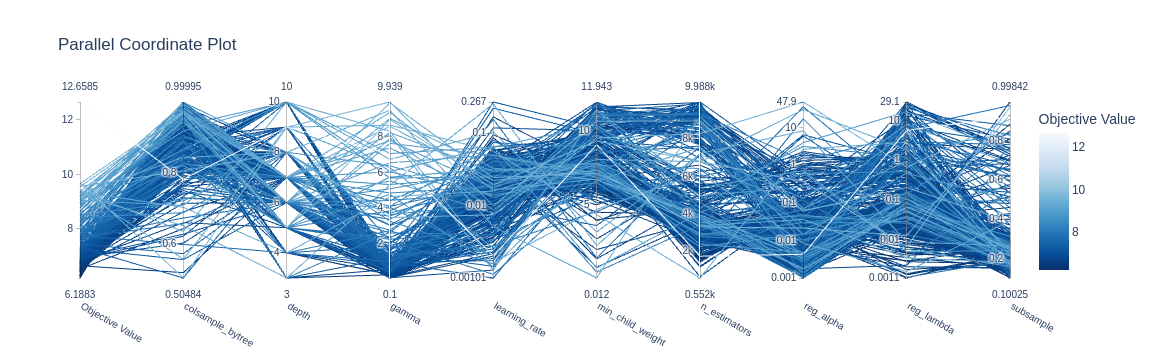

In [66]:
optuna.visualization.plot_parallel_coordinate(study)

In [67]:
#### CatBoost Study

In [68]:
arch = 'catboost'

In [69]:
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_config)

In [ ]:
# originally from https://www.kaggle.com/satorushibata/optimize-catboost-hyperparameter-with-optuna-gpu
def objective(trial, arch=arch):#, tune_fold=tune_fold):
    """
    Wrapper around cross_validation_trainer to test different model hyperparameters
    """
    
    if arch == 'catboost':
        model_params = {
            'iterations' : trial.suggest_int('iterations', 2000, 30000),                         
            'depth' : trial.suggest_int('depth', 3, 10),                                       
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.5),               
            'random_strength': trial.suggest_int('random_strength', 0, 100), 
    #         'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
    #         'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['MVC', 'Bernoulli']),#, 'Poisson']),
            'od_wait': trial.suggest_int('od_wait', 20, 2000),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 2, 70), # aka l2_leaf_reg
            'border_count': trial.suggest_int('border_count', 50, 275),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 20), # aka min_data_in_leaf
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 5),
            'task_type':'GPU',
            'verbose': False,
#             'silent':True,
            'random_state':42,
            # 'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
    #         'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
            # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    #         'max_leaves': trial.suggest_int('max_leaves', 32, 128)
        }
        
    elif arch == 'lightgbm':
        pass # todo -- fill in tomorrow
        
    elif arch == 'xgboost':
        model_params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 10000), # was 900-4500 for CPU
            'max_depth' : trial.suggest_int('depth', 3, 10),                                       
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),               
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 50),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 30),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1),
    #         'booster': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 12),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_uniform('gamma', 0.1, 10),
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'eval_metric': ['mae', 'mape'],
            'sampling_method': 'gradient_based',
            'seed': 42,
            'grow_policy': 'lossguide',
#             'max_leaves': 255,
#             'lambda': 100,
#     'n_estimators': 3000,
            'objective': 'reg:squarederror',
#             'n_estimators': 500,
#     'verbose': True,
            
        } 
    
    return gbm_trainer(arch=arch, model_kwargs=model_params, wandb_tracked=False)#, telegram=False)

In [71]:
start_time = datetime.now().strftime('%Y%m%d%H%M%S')
study = optuna.create_study(direction = "minimize", 
                            sampler = TPESampler(seed=int(SEED)), 
                            study_name=f"{arch}_study-{start_time}")

[I 2022-01-27 08:23:56,752] A new study created in memory with name: catboost_study-20220127082356


In [75]:
%%time
for x in range(1, 500):
    study.optimize(objective, n_trials = 1, callbacks = [wandbc], show_progress_bar=False)#, catch=(xgboost.core.XGBoostError,)) 
    dump(study, filename=studypath/f"optuna_{arch}_study-{start_time}.joblib")


FOLD 0
------------------------------


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

In [78]:
study = load(studypath/'optuna_catboost_study-20220127082356.joblib')

In [80]:
study.best_trial.params

{'iterations': 10529,
 'depth': 3,
 'learning_rate': 0.07026263205443048,
 'random_strength': 44,
 'od_wait': 261,
 'reg_lambda': 35.672029887566374,
 'border_count': 57,
 'min_child_samples': 19,
 'leaf_estimation_iterations': 2}

In [77]:
wandb.log({'best_params': str(study.best_trial.params),
#            'trials_in_run': len(study.trials),
           'trials_in_study': len(study.trials)
          })
wandb.finish()

Error: You must call wandb.init() before wandb.log()

In [ ]:
study.best_trial.params

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

#### Calls

In [66]:
%time 
xgb_forecast_oof_preds, xgb_forecast_test_preds = gbm_trainer(arch='xgboost', model_kwargs=xgboost_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
FOLD 0
------------------------------
FOLD 0 OOF SMAPE: 0.8476365395298698
FOLD 1
------------------------------
FOLD 1 OOF SMAPE: 0.9349776188629331
FOLD 2
------------------------------
FOLD 2 OOF SMAPE: 0.8853828441336109
FOLD 3
------------------------------
FOLD 3 OOF SMAPE: 0.8532543631116587


In [67]:
SMAPE(y_pred=xgb_forecast_oof_preds, y_true=orig_train_df['num_sold'])

13.193614221145653

In [69]:
%time 
xgb_forecast_oof_preds, xgb_forecast_test_preds = gbm_trainer(arch='xgboost', model_kwargs=xgboost_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
FOLD 0
------------------------------
FOLD 0 OOF SMAPE: 0.21107808385399895
FOLD 1
------------------------------
FOLD 1 OOF SMAPE: 0.21276162296052187
FOLD 2
------------------------------
FOLD 2 OOF SMAPE: 0.2137797867063078
FOLD 3
------------------------------
FOLD 3 OOF SMAPE: 0.2224652160189054


In [70]:
SMAPE(y_pred=xgb_forecast_oof_preds, y_true=orig_train_df['num_sold'])

12.594899764124257

In [70]:
SMAPE(y_pred=xgb_forecast_oof_preds, y_true=orig_train_df['num_sold'])

12.594899764124257

In [64]:
example_xgb_params = {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.0013033567475147442, 'reg_alpha': 0.7158714383119805, 'reg_lambda': 0.005800389779115683, 'subsample': 0.1585464336867516, 'min_child_weight': 11.386677561502745, 'colsample_bytree': 0.9828160165372797, 'gamma': 8.103133746352965}

In [67]:
%%time 
# xgb_forecast_oof_preds, xgb_forecast_test_preds = gbm_trainer(arch='xgboost', model_kwargs=example_xgb_params, wandb_tracked=False)
example_smape = gbm_trainer(arch='xgboost', model_kwargs=xgboost_params, wandb_tracked=False)
example_smape

FOLD 0
------------------------------
FOLD 1
------------------------------
FOLD 2
------------------------------
FOLD 3
------------------------------
CPU times: user 48.5 s, sys: 964 ms, total: 49.5 s
Wall time: 15.3 s


194.7930179896259

In [71]:
example_smape

195.07542834209443

In [93]:
%time 
tcn_tv_preds, tcn_test_preds = sklearn_trainer(estimator=TCNModel, use_skorch=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
<class 'torch.Tensor'> <class 'torch.Tensor'>


TypeError: object of type 'int' has no len()

In [46]:
%time
prophet_tv_preds, prophet_test_preds = prophet_trainer(target='num_sold')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs

Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Mug - Train SMAPE: 6.815541
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Mug - Validation SMAPE: 8.011073


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Hat - Train SMAPE: 7.210369
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Hat - Validation SMAPE: 7.470548


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Sticker - Train SMAPE: 7.056273
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Sticker - Validation SMAPE: 7.264969


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleRama - Kaggle Mug - Train SMAPE: 6.716048
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleRama - Kaggle Mug - Validation SMAPE: 7.406634


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleRama - Kaggle Hat - Train SMAPE: 7.000068


In [47]:
%time
# neural_tv_preds, neural_test_preds = neuralprophet_trainer(target='num_sold')
# dump(neural_tv_preds, predpath/'20220124_neuralprophet_tv_preds.joblib')
# dump(neural_test_preds, predpath/'20220124_neuralprophet_test_preds.joblib')
neural_tv_preds = load(predpath/'20220124_neuralprophet_tv_preds.joblib')
neural_test_preds = load(predpath/'20220124_neuralprophet_test_preds.joblib')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [48]:
# %time
# ridge_tv_preds, ridge_test_preds = sklearn_trainer(estimator=Ridge)

In [49]:
%time
ridge_combo_tv_preds, ridge_combo_test_preds = sklearn_trainer(estimator=Ridge)#, by_combo=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [50]:
# linear_tv_preds, linear_test_preds = sklearn_trainer(estimator=LinearRegression)

In [51]:
linear_combo_tv_preds, linear_combo_test_preds = sklearn_trainer(estimator=LinearRegression)#, by_combo=True)

In [52]:
huber_combo_tv_preds, huber_combo_test_preds = sklearn_trainer(estimator=HuberRegressor)#, by_combo=True)

In [53]:
mlp_combo_tv_preds, mlp_combo_test_preds = sklearn_trainer(estimator=MLPRegressor)#, by_combo=True)

In [54]:
lasso_combo_tv_preds, lasso_combo_test_preds = sklearn_trainer(estimator=Lasso)#), by_combo=True)

In [55]:
from pyearth import Earth
%time
earth_combo_tv_preds, earth_combo_test_preds = sklearn_trainer(estimator=Earth), #by_combo=True)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


In [56]:
earth_combo_tv_preds

0         360.672190
1         584.851806
2         138.401176
3         562.479785
4         944.584508
            ...     
26293     836.947940
26294     254.287204
26295    1058.174059
26296    2036.549357
26297     472.307718
Name: model_forecast, Length: 26298, dtype: float64

In [57]:
y_tv = orig_train_df['num_sold']

In [58]:
for preds in [prophet_tv_preds, ridge_combo_tv_preds, linear_combo_tv_preds, huber_combo_tv_preds, mlp_combo_tv_preds, neural_tv_preds, lasso_combo_tv_preds, earth_combo_tv_preds]:
    print(SMAPE(y_pred=preds, y_true=y_tv))

7.098824805150043
4.781041939812455
4.175573461450916
14.396222549610735
99.04042806269284
7.926662675729486
15.11713989060885
5.338351055481194


Clearly, doing it by combination is the way to go. I think Ridge and LinearRegressor are definitely good to use; Prophet and NeuralProphet are worth including as well. Huber, probably not; MLPRegressor, definitely not barring the discovery of better hyperparams.

### Forecast Bundling
Now, create an iterable collection consisting of all the forecaster predictions.

In [59]:
forecast_tv_preds = {
    'prophet': prophet_tv_preds,
    'neuralprophet': neural_tv_preds,
    'ridge': ridge_combo_tv_preds,
    'linear': linear_combo_tv_preds,
    'huber': huber_combo_tv_preds,
    'lasso': lasso_combo_tv_preds,
    'earth': earth_combo_tv_preds,
}

forecast_test_preds = {
    'prophet': prophet_test_preds,
    'neuralprophet': neural_test_preds,
    'ridge': ridge_combo_test_preds,
    'linear': linear_combo_test_preds,
    'huber': huber_combo_test_preds,
    'lasso': lasso_combo_test_preds,
    'earth': earth_combo_test_preds
}

In [60]:
tv_preds = pd.DataFrame({
    'date': orig_train_df['date'],
    'num_sold': orig_train_df['num_sold'],
    **forecast_tv_preds
})

In [61]:
tv_preds

date  num_sold      prophet  neuralprophet        ridge  \
0      2015-01-01       329   346.560416     329.134521   283.272258   
1      2015-01-01       520   536.203586     458.008301   439.771734   
2      2015-01-01       146   143.412803     145.325577   120.885683   
3      2015-01-01       572   590.117165     552.571167   488.810710   
4      2015-01-01       911   939.673009     781.967285   771.701702   
...           ...       ...          ...            ...          ...   
26293  2018-12-31       823   898.322121     669.418457   723.714830   
26294  2018-12-31       250   253.512355     227.158142   205.880079   
26295  2018-12-31      1004  1039.635205     715.639648   832.192362   
26296  2018-12-31      1441  1526.908216     980.234009  1255.885410   
26297  2018-12-31       388   463.705207     423.052612   373.542094   

            linear       huber       lasso        earth  
0       324.188332  239.868861  176.381725   360.672190  
1       503.081569  334.618687  334.453055   584.851806  
2       136.667932   96.086063   89.802390   138.401176  
3       555.531957  330.014790  307.788806   562.479785  
4       890.469201  875.922092  583.510103   944.584508  
...            ...         ...         ...          ...  
26293   846.597603  407.206130  397.285794   836.947940  
26294   241.048951  132.620712  126.765608   254.287204  
26295   975.785339  401.224848  430.368706  1058.174059  
26296  1468.776593  863.230649  689.775798  2036.549357  
26297   441.128842  272.140350  220.531682   472.307718  

[26298 rows x 9 columns]

In [62]:
valid_forecast_preds = tv_preds[tv_preds['date'] > '2017-12-31']
valid_forecast_preds

date  num_sold      prophet  neuralprophet        ridge  \
19728  2018-01-01       405   383.365770     374.809906   345.296498   
19729  2018-01-01       621   602.594228     539.082520   536.708119   
19730  2018-01-01       176   161.735807     167.919098   147.203184   
19731  2018-01-01       714   656.201669     635.251648   596.599377   
19732  2018-01-01      1043  1044.903702     940.582886   930.576635   
...           ...       ...          ...            ...          ...   
26293  2018-12-31       823   898.322121     669.418457   723.714830   
26294  2018-12-31       250   253.512355     227.158142   205.880079   
26295  2018-12-31      1004  1039.635205     715.639648   832.192362   
26296  2018-12-31      1441  1526.908216     980.234009  1255.885410   
26297  2018-12-31       388   463.705207     423.052612   373.542094   

            linear       huber       lasso        earth  
19728   417.388135  249.679981  211.676443   382.162985  
19729   637.949409  348.560475  348.732376   609.231013  
19730   174.086997   99.898973  107.780206   167.839584  
19731   713.788713  343.757663  368.614186   597.369896  
19732  1110.805235  913.849095  604.430617  1059.300177  
...            ...         ...         ...          ...  
26293   846.597603  407.206130  397.285794   836.947940  
26294   241.048951  132.620712  126.765608   254.287204  
26295   975.785339  401.224848  430.368706  1058.174059  
26296  1468.776593  863.230649  689.775798  2036.549357  
26297   441.128842  272.140350  220.531682   472.307718  

[6570 rows x 9 columns]

In [63]:
valid_forecast_preds.corr()

num_sold   prophet  neuralprophet     ridge    linear  \
num_sold       1.000000  0.972938       0.961440  0.992806  0.995334   
prophet        0.972938  1.000000       0.990336  0.985617  0.975158   
neuralprophet  0.961440  0.990336       1.000000  0.978596  0.962073   
ridge          0.992806  0.985617       0.978596  1.000000  0.996412   
linear         0.995334  0.975158       0.962073  0.996412  1.000000   
huber          0.910517  0.937816       0.947772  0.926965  0.910123   
lasso          0.899862  0.939803       0.950331  0.919398  0.901341   
earth          0.984322  0.972174       0.961384  0.989698  0.987908   

                  huber     lasso     earth  
num_sold       0.910517  0.899862  0.984322  
prophet        0.937816  0.939803  0.972174  
neuralprophet  0.947772  0.950331  0.961384  
ridge          0.926965  0.919398  0.989698  
linear         0.910123  0.901341  0.987908  
huber          1.000000  0.922899  0.910400  
lasso          0.922899  1.000000  0.906948  
earth          0.910400  0.906948  1.000000

In [64]:
tv_preds.corr()

num_sold   prophet  neuralprophet     ridge    linear  \
num_sold       1.000000  0.975093       0.960082  0.993110  0.995846   
prophet        0.975093  1.000000       0.985693  0.986481  0.977785   
neuralprophet  0.960082  0.985693       1.000000  0.978010  0.962507   
ridge          0.993110  0.986481       0.978010  1.000000  0.996573   
linear         0.995846  0.977785       0.962507  0.996573  1.000000   
huber          0.907911  0.933401       0.938389  0.926616  0.909135   
lasso          0.899352  0.927660       0.939915  0.919336  0.900973   
earth          0.990016  0.974833       0.960241  0.992161  0.994045   

                  huber     lasso     earth  
num_sold       0.907911  0.899352  0.990016  
prophet        0.933401  0.927660  0.974833  
neuralprophet  0.938389  0.939915  0.960241  
ridge          0.926616  0.919336  0.992161  
linear         0.909135  0.900973  0.994045  
huber          1.000000  0.923215  0.907105  
lasso          0.923215  1.000000  0.900047  
earth          0.907105  0.900047  1.000000

So Ridge and Linear perform best, and are quite similar; Prophet and NeuralProphet are next best, and similar to one another; Huber is an outlier (and not so good). Lasso performs worst of all, but is closer to Prophet and NeuralProphet in performance than the others. It's closest of all to NeuralProphet, interestingly.

In [65]:
test_forecast_preds = pd.DataFrame({
    'date': orig_test_df['date'],
#     'num_sold': orig_train_df['num_sold'],
    **forecast_test_preds
})

In [66]:
test_forecast_preds

date      prophet  neuralprophet        ridge       linear  \
0     2019-01-01   402.296576     383.543457   359.817081   392.328390   
1     2019-01-01   631.642099     551.044983   560.783324   620.092467   
2     2019-01-01   169.992094     173.065674   153.552940   166.788184   
3     2019-01-01   684.559821     648.783691   622.237644   675.674104   
4     2019-01-01  1092.875362     965.683716   969.065554  1084.980801   
...          ...          ...            ...          ...          ...   
6565  2019-12-31   917.085861     674.891174   742.331990   797.964290   
6566  2019-12-31   261.569590     232.082169   210.920805   225.576610   
6567  2019-12-31  1065.400121     730.457275   852.091174   925.788409   
6568  2019-12-31  1568.407214    1005.392944  1286.814471  1397.071983   
6569  2019-12-31   476.122783     428.916565   382.800781   417.035222   

           huber       lasso        earth  
0     248.728792  221.118411   417.102143  
1     347.337935  347.623611   693.844970  
2      99.483226  112.590591   181.642807  
3     342.549613  384.790895   594.166542  
4     911.102831  601.189400  1142.564632  
...          ...         ...          ...  
6565  404.876685  391.134492   830.606248  
6566  131.774790  129.930008   269.498973  
6567  398.926697  440.077496  1133.560974  
6568  858.595973  677.887045  2627.470943  
6569  270.478738  225.775009   507.799360  

[6570 rows x 8 columns]

### Residuals

At this point, I have two DataFrames containing predictions from the forecasting models (which try to learn trends): 
1. `valid_forecast_preds`
2. `test_forecast_preds`

Both still contain the features `'date'` (having a datetime type) and the validation preds contain `num_sold`.

The goal now will be to iteratively generate a final prediction DataFrame containing all possible combinations of the forecasting model predictions and residual predictions.

In [67]:
forecast_models = ['prophet', 'neuralprophet', 'ridge', 'linear', 'huber', 'lasso', 'earth'] # models to use to provide basis for residual predictions

In [68]:
# encoded_all_df

In [69]:
# dump(encoded_all_df, datapath/'encoded_train+testset_with_gdp+teckmengwong-time-features+transformed-target-for-train.joblib')

In [70]:
# hybrid_train_df = encoded_all_df[:len(train_df)]
# hybrid_valid_df = encoded_all_df[len(train_df): len(train_df)+len(valid_df)]

In [71]:
# hybrid_test_df = encoded_all_df[len(train_df)+len(valid_df):]

In [72]:
# hybrid_valid_df

Note that the `tv_df` still contains both transformed targets and `num_sold`.

In [73]:
tv_df

date  country       store         product  num_sold       gdp  \
0     2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0  5.461456   
1     2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0  5.461456   
2     2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0  5.461456   
3     2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0  5.461456   
4     2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0  5.461456   
...          ...      ...         ...             ...       ...       ...   
26293 2018-12-31   Sweden  KaggleMart      Kaggle Hat     823.0  6.321586   
26294 2018-12-31   Sweden  KaggleMart  Kaggle Sticker     250.0  6.321586   
26295 2018-12-31   Sweden  KaggleRama      Kaggle Mug    1004.0  6.321586   
26296 2018-12-31   Sweden  KaggleRama      Kaggle Hat    1441.0  6.321586   
26297 2018-12-31   Sweden  KaggleRama  Kaggle Sticker     388.0  6.321586   

       month  season    wd4   wd56  ...  easter50  easter51  easter52  \
0          1       1  False  False  ...     False     False     False   
1          1       1  False  False  ...     False     False     False   
2          1       1  False  False  ...     False     False     False   
3          1       1  False  False  ...     False     False     False   
4          1       1  False  False  ...     False     False     False   
...      ...     ...    ...    ...  ...       ...       ...       ...   
26293     12       1  False  False  ...     False     False     False   
26294     12       1  False  False  ...     False     False     False   
26295     12       1  False  False  ...     False     False     False   
26296     12       1  False  False  ...     False     False     False   
26297     12       1  False  False  ...     False     False     False   

       easter53  easter54  easter55  easter56  easter57  easter58    target  
0         False     False     False     False     False     False  3.738239  
1         False     False     False     False     False     False  4.196010  
2         False     False     False     False     False     False  2.925788  
3         False     False     False     False     False     False  4.291321  
4         False     False     False     False     False     False  4.756724  
...         ...       ...       ...       ...       ...       ...       ...  
26293     False     False     False     False     False     False  4.477861  
26294     False     False     False     False     False     False  3.286366  
26295     False     False     False     False     False     False  4.676652  
26296     False     False     False     False     False     False  5.037997  
26297     False     False     False     False     False     False  3.725910  

[26298 rows x 246 columns]

In [74]:
test_df

date  country       store         product  num_sold       gdp  \
0    2019-01-01  Finland  KaggleMart      Kaggle Mug       NaN  5.597614   
1    2019-01-01  Finland  KaggleMart      Kaggle Hat       NaN  5.597614   
2    2019-01-01  Finland  KaggleMart  Kaggle Sticker       NaN  5.597614   
3    2019-01-01  Finland  KaggleRama      Kaggle Mug       NaN  5.597614   
4    2019-01-01  Finland  KaggleRama      Kaggle Hat       NaN  5.597614   
...         ...      ...         ...             ...       ...       ...   
6565 2019-12-31   Sweden  KaggleMart      Kaggle Hat       NaN  6.282042   
6566 2019-12-31   Sweden  KaggleMart  Kaggle Sticker       NaN  6.282042   
6567 2019-12-31   Sweden  KaggleRama      Kaggle Mug       NaN  6.282042   
6568 2019-12-31   Sweden  KaggleRama      Kaggle Hat       NaN  6.282042   
6569 2019-12-31   Sweden  KaggleRama  Kaggle Sticker       NaN  6.282042   

      month  season    wd4   wd56  ...  easter50  easter51  easter52  \
0         1       1  False  False  ...     False     False     False   
1         1       1  False  False  ...     False     False     False   
2         1       1  False  False  ...     False     False     False   
3         1       1  False  False  ...     False     False     False   
4         1       1  False  False  ...     False     False     False   
...     ...     ...    ...    ...  ...       ...       ...       ...   
6565     12       1  False  False  ...     False     False     False   
6566     12       1  False  False  ...     False     False     False   
6567     12       1  False  False  ...     False     False     False   
6568     12       1  False  False  ...     False     False     False   
6569     12       1  False  False  ...     False     False     False   

      easter53  easter54  easter55  easter56  easter57  easter58  target  
0        False     False     False     False     False     False     NaN  
1        False     False     False     False     False     False     NaN  
2        False     False     False     False     False     False     NaN  
3        False     False     False     False     False     False     NaN  
4        False     False     False     False     False     False     NaN  
...        ...       ...       ...       ...       ...       ...     ...  
6565     False     False     False     False     False     False     NaN  
6566     False     False     False     False     False     False     NaN  
6567     False     False     False     False     False     False     NaN  
6568     False     False     False     False     False     False     NaN  
6569     False     False     False     False     False     False     NaN  

[6570 rows x 246 columns]

One question: should the full `tv_df` be passed as data, or only the validation set? I think it's better to supply as much data as possible, so I'll use the whole thing for now.

In [75]:
from sklearn.model_selection import GroupKFold

In [76]:
len(tv_df)

26298

In [77]:
len(orig_train_df)

26298

In [78]:
from sklearn.metrics import mean_squared_error

In [79]:
import math

#### Residual Trainer 
(assumes Scikit-Learn API)

In [80]:
def residual_trainer(estimator, model_kwargs={}, forecast_models=forecast_models,
                     tv_df=tv_df, test_df=test_df,
                     tv_forecast_preds=tv_preds, test_forecast_preds=test_forecast_preds):
#     df_2018 = tv_df[tv_df['date'] > '2017-12-31']
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, tv_df = label_encoder(df_train) # should leave broader scope's tv_df alone
    _, test_df = label_encoder(df_test) # should leave broader scope's test_df alone
    del df_train, df_test
    
    residual_tv_df = pd.DataFrame({
        'date': orig_train_df['date'],
        'num_sold': orig_train_df['num_sold']
    })
    print(len(residual_tv_df))
    
    residual_test_df = pd.DataFrame({
        'date': orig_test_df['date'],
    })
    
    # getting rid of unneeded 'target' feature, also num_sold since we're only interested in predicting the residual
    # following @ambrosm lightgbm nb and leaving date in for GroupKFold, but unsure of this (or if I should drop it later)
    tv_df = tv_df.drop(columns=['target', 'num_sold'])#, 'date'])
    test_df = test_df.drop(columns=['target', 'num_sold'])#, 'date'])
    
    kfolds= GroupKFold(n_splits=4)
    
    test_fold_preds = {}
    
    for forecast_model in forecast_models:
        print(f"Working with forecasts from {forecast_model}...")
        print("-----------------------------------------------------")
        forecast = tv_forecast_preds[forecast_model] # pull out the predictions on the t-v sets for a given estimator
        residuals = residual_tv_df['num_sold'] - forecast # get the residuals for the given model's forecast
#         residual_df[f'actual_{forecast_model}_residual'] = residuals # may not need to put this in there
#         tv_df['residual'] = residuals # residuals will rotate in and out of this feature
        
        
        X_test = test_df.drop(columns=['date'])
#         print("y.shape is ", y.shape)
        
        # prepare for Group K-Fold cross-val; below from @ambrosm LightGBM notebook
        oof_preds = pd.Series(0, index=tv_df.index)
#         test_preds_df = pd.DataFrame({
#             'date': test_df['date']
#         })
        score_list = []
#         params['seed'] = 1
        for fold, (train_idx, val_idx) in enumerate(kfolds.split(tv_df, groups=tv_df.date.dt.year)):
            print("-----------------------------------------------------")
            print(f"FOLD {fold}")
            X = tv_df.iloc[train_idx].drop(columns=['date'])
            y = residuals.iloc[train_idx]#['date']
            X_valid = tv_df.iloc[val_idx].drop(columns=['date'])
            y_valid = residuals.iloc[val_idx]#['date']
            
            model = estimator(**model_kwargs)
            model.fit(X, y)
            
            residual_valid_preds = model.predict(X_valid)
            residual_test_preds = model.predict(X_test)
            
            oof_preds[val_idx] = residual_valid_preds
#             test_preds_df[f'{forecast_model}_fold_{fold}_preds'] = residual_test_preds
#             residual_test_df = residual_test_df.join(test_preds_df)
#             smape = SMAPE(y_pred=residual_valid_preds, y_true=y_valid.values)
#             print(f"SMAPE: {smape}")
            rmse = math.sqrt(mean_squared_error(y_pred=residual_valid_preds, y_true=y_valid.values))
            print(f"RMSE: {rmse}")
            test_fold_preds[f'{forecast_model}_{fold}_residual_preds'] = residual_test_preds
        residual_tv_df[f'{forecast_model}_oof_residual_preds'] = oof_preds
#         residual_test_df = residual_test_df.join(test_preds_df)
    return residual_tv_df, test_fold_preds #residual_test_df
        
            
            
#             model, smape = fit_model(X_tr, X_va, run=0, fold=fold)

# print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
# with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)
#         X = tv_df.drop(columns=['residual'])
#         y = tv_df['residual']
        
#         tv_
    
    
    
        
#     y_valid = valid_df['num_sold']
#     valid_df = valid_df.drop(columns=['target'])

In [81]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#### Residual model hyperparams

In [84]:
xgboost_params = {
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'eval_metric': ['mae', 'mape', 'rmse'],
    'learning_rate': .09,
    'max_depth': 0,
    'subsample': .15,
    'sampling_method': 'gradient_based',
    'seed': 42,
    'grow_policy': 'lossguide',
    'max_leaves': 255,
    'lambda': 100,
#     'n_estimators': 3000,
    'objective': 'reg:squarederror',
    'n_estimators': 500
#     'verbose': True,
}


lightgbm_params = {
    'objective': 'mse',
    'random_state': 42,
    'device_type': 'cpu',
    'n_jobs': -1,
#                 eval_metric='auc',
#     'device_type': 'gpu',
#     'max_bin': 63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
#     'gpu_use_dp': False,
    'max_depth': 0,
    'learning_rate': 0.1,
    'subsample': .15,
    'n_estimators': 1500,
}

catboost_params = {
    'task_type':'GPU',
    'silent':True,
    'random_state':42,
}
                

XGBoost SMAPEs with `n_estimators=500`:

```
26298
Working with forecasts from prophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 44.22169948290956
-----------------------------------------------------
FOLD 1
RMSE: 42.2884194618039
-----------------------------------------------------
FOLD 2
RMSE: 38.87851134388903
-----------------------------------------------------
FOLD 3
RMSE: 39.14401892347087
Working with forecasts from neuralprophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 71.59711327241503
-----------------------------------------------------
FOLD 1
RMSE: 50.410812085025206
-----------------------------------------------------
FOLD 2
RMSE: 56.30623610755547
-----------------------------------------------------
FOLD 3
RMSE: 71.87002649034811
Working with forecasts from ridge...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 29.951196797722172
-----------------------------------------------------
FOLD 1
RMSE: 33.87710734178301
-----------------------------------------------------
FOLD 2
RMSE: 30.3425528497887
-----------------------------------------------------
FOLD 3
RMSE: 30.908377053367243
Working with forecasts from linear...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 25.909733767351145
-----------------------------------------------------
FOLD 1
RMSE: 32.55539418287357
-----------------------------------------------------
FOLD 2
RMSE: 28.02573800531867
-----------------------------------------------------
FOLD 3
RMSE: 27.512157750399876
Working with forecasts from huber...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 43.8980188030959
-----------------------------------------------------
FOLD 1
RMSE: 55.40375581530791
-----------------------------------------------------
FOLD 2
RMSE: 46.37734856211295
-----------------------------------------------------
FOLD 3
RMSE: 41.743947334147386
Working with forecasts from lasso...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 42.212939444847706
-----------------------------------------------------
FOLD 1
RMSE: 58.6828784233263
-----------------------------------------------------
FOLD 2
RMSE: 47.91103516420516
-----------------------------------------------------
FOLD 3
RMSE: 41.89282012115221
```

#### Residual model training / loading

In [85]:
%time 
xgb_tv_df, xgb_test_fold_preds = residual_trainer(estimator=XGBRegressor, model_kwargs=xgboost_params,)
dump(xgb_tv_df, predpath/'20220125_+earth_residual_oof_residual_xgboost_preds.joblib')
dump(xgb_test_fold_preds, predpath/'20220125_+earth_residual_test_residual_xgboost_preds.joblib')

# loading the 500-estimator version, which is universally better
# xgb_tv_df = load(predpath/'20220124_residual_oof_xgboost_preds.joblib')
# xgb_test_fold_preds = load(predpath/'20220124_residual_test_xgboost_preds.joblib')

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.68 µs
26298
Working with forecasts from prophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 44.22169948290956
-----------------------------------------------------
FOLD 1
RMSE: 42.2884194618039
-----------------------------------------------------
FOLD 2
RMSE: 38.87851134388903
-----------------------------------------------------
FOLD 3
RMSE: 39.14401892347087
Working with forecasts from neuralprophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 72.2965394109592
-----------------------------------------------------
FOLD 1
RMSE: 50.48678606565055
-----------------------------------------------------
FOLD 2
RMSE: 56.39589310004499
-----------------------------------------------------
FOLD 3
RMSE: 71.94274727206121
Working with forecasts from ridge...
-----------------------

['/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/preds/20220125_+earth_residual_test_residual_xgboost_preds.joblib']

In [86]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [87]:
%time
lgb_tv_df, lgb_test_fold_preds = residual_trainer(estimator=LGBMRegressor, model_kwargs=lightgbm_params,)
dump(lgb_tv_df, predpath/'20220125_+earth_residual_oof_residual_lightgbm_preds.joblib')
dump(lgb_test_fold_preds, predpath/'20220125_+earth_residual_test_residual_lightgbm_preds.joblib')
# lgb_tv_df = load(predpath/'20220124_residual_oof_residual_lightgbm_preds.joblib')
# lgb_test_fold_preds = load(predpath/'20220124_residual_test_residual_lightgbm_preds.joblib')

CPU times: user 0 ns, sys: 34 µs, total: 34 µs
Wall time: 4.77 µs
26298
Working with forecasts from prophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 40.2958973133468
-----------------------------------------------------
FOLD 1
RMSE: 40.72754418203894
-----------------------------------------------------
FOLD 2
RMSE: 34.289662190196665
-----------------------------------------------------
FOLD 3
RMSE: 35.118251779330976
Working with forecasts from neuralprophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 71.44951581377815
-----------------------------------------------------
FOLD 1
RMSE: 47.489823189781696
-----------------------------------------------------
FOLD 2
RMSE: 53.766625686957966
-----------------------------------------------------
FOLD 3
RMSE: 58.62494371250313
Working with forecasts from ridge...
----------------

['/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/preds/20220125_+earth_residual_test_residual_lightgbm_preds.joblib']

In [88]:
%time
cat_tv_df, cat_test_fold_preds = residual_trainer(estimator=CatBoostRegressor, model_kwargs=catboost_params,)
dump(cat_tv_df, predpath/'20220125_+earth_residual_oof_residual_catboost_preds.joblib')
dump(cat_test_fold_preds, predpath/'20220125_+earth_residual_test_residual_catboost_preds.joblib')
# cat_tv_df = load(predpath/'20220124_residual_oof_residual_catboost_preds.joblib')
# cat_test_fold_preds = load(predpath/'20220124_residual_test_residual_catboost_preds.joblib')

CPU times: user 34 µs, sys: 1e+03 ns, total: 35 µs
Wall time: 4.77 µs
26298
Working with forecasts from prophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 34.85084358418546
-----------------------------------------------------
FOLD 1
RMSE: 39.134690709805604
-----------------------------------------------------
FOLD 2
RMSE: 32.316241553438786
-----------------------------------------------------
FOLD 3
RMSE: 32.297408734705535
Working with forecasts from neuralprophet...
-----------------------------------------------------
-----------------------------------------------------
FOLD 0
RMSE: 64.4820465743269
-----------------------------------------------------
FOLD 1
RMSE: 45.80180130203257
-----------------------------------------------------
FOLD 2
RMSE: 47.036335391797884
-----------------------------------------------------
FOLD 3
RMSE: 54.06048073783771
Working with forecasts from ridge...
------------

['/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/preds/20220125_+earth_residual_test_residual_catboost_preds.joblib']

In [89]:
%time
# ridge_tv_df, ridge_test_fold_preds = residual_trainer(estimator=Ridge)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [90]:
%time
# lasso_tv_df, lasso_test_fold_preds = residual_trainer(estimator=Lasso)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [91]:
%time
# linear_tv_df, linear_test_fold_preds = residual_trainer(estimator=LinearRegression)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [92]:
# dump(valid_forecast_preds, predpath/'20220124_forecast_valid2018_preds.joblib')
# dump(test_forecast_preds, predpath/'20220124_forecast_test_preds.joblib')

#### Assembling together residual predictions

In [93]:
tv_dfs = {
    'xgb': xgb_tv_df, 
    'lgb': lgb_tv_df, 
    'cat': cat_tv_df,
#     'ridge': ridge_tv_df,
#     'lasso': lasso_tv_df,
#     'linear': linear_tv_df,
}

for arch in tv_dfs.keys():
    for forecast_model in forecast_models:
        tv_dfs[arch][f'{forecast_model}_pred'] = tv_preds[forecast_model]
        tv_dfs[arch][f'{forecast_model}_residual'] = tv_dfs[arch]['num_sold'] - tv_preds[forecast_model] #- xgb_tv_df['num_sold']

In [94]:
# xgb_tv_df

In [97]:
tv_dfs['xgb']

date  num_sold  prophet_oof_residual_preds  \
0      2015-01-01       329                    1.278618   
1      2015-01-01       520                  -10.982243   
2      2015-01-01       146                   -5.641450   
3      2015-01-01       572                    7.359212   
4      2015-01-01       911                    0.859362   
...           ...       ...                         ...   
26293  2018-12-31       823                   -3.253311   
26294  2018-12-31       250                  -14.439471   
26295  2018-12-31      1004                  -31.400349   
26296  2018-12-31      1441                   34.119045   
26297  2018-12-31       388                  -28.147552   

       neuralprophet_oof_residual_preds  ridge_oof_residual_preds  \
0                             19.981554                 34.222641   
1                             35.412369                 57.832901   
2                              3.151324                 11.319877   
3                             25.241949                 65.995567   
4                            103.271629                132.802261   
...                                 ...                       ...   
26293                        283.321930                132.241791   
26294                          6.964965                 46.179234   
26295                        364.578430                146.736877   
26296                        638.341980                227.119736   
26297                         98.937172                 74.027718   

       linear_oof_residual_preds  huber_oof_residual_preds  \
0                       3.645102                139.376175   
1                      -9.185784                192.085785   
2                      -6.932339                 66.705956   
3                      11.750156                285.283234   
4                      -6.488067                122.903603   
...                          ...                       ...   
26293                 -10.704310                465.822357   
26294                   5.300345                118.407372   
26295                  -6.179089                552.454895   
26296                 -13.130022                642.822388   
26297                   3.612769                147.187302   

       lasso_oof_residual_preds  earth_oof_residual_preds  prophet_pred  ...  \
0                    166.224564                 14.680798    346.560416  ...   
1                    217.624084                 12.078963    536.203586  ...   
2                     53.481075                 -3.095822    143.412803  ...   
3                    283.822510                 56.345188    590.117165  ...   
4                    407.049622                  8.930732    939.673009  ...   
...                         ...                       ...           ...  ...   
26293                427.108459                -25.774075    898.322121  ...   
26294                119.623322                 -0.278643    253.512355  ...   
26295                531.086609                -23.914564   1039.635205  ...   
26296                774.511536                -40.309673   1526.908216  ...   
26297                216.445160                  0.980584    463.705207  ...   

        ridge_pred  ridge_residual  linear_pred  linear_residual  huber_pred  \
0       283.272258       45.727742   324.188332         4.811668  239.868861   
1       439.771734       80.228266   503.081569        16.918431  334.618687   
2       120.885683       25.114317   136.667932         9.332068   96.086063   
3       488.810710       83.189290   555.531957        16.468043  330.014790   
4       771.701702      139.298298   890.469201        20.530799  875.922092   
...            ...             ...          ...              ...         ...   
26293   723.714830       99.285170   846.597603       -23.597603  407.206130   
26294   205.880079       44.119921   241.048951         8.951049  132.620712   
26295   832.192362      171.807638   975.785339  

In [98]:
for arch in tv_dfs.keys(): # xgb, then lgb, then cat
    print(f"\nFor {arch}...\n")
    for forecast_model in forecast_models:
        
#         if arch == 'xgb':
#             adjusted_smape = SMAPE(y_pred=tv_dfs[arch][f'{forecast_model}_pred']+tv_dfs[arch][f'{forecast_model}_oof_preds'], y_true=tv_dfs[arch]['num_sold'])
#         else:
        adjusted_smape = SMAPE(y_pred=tv_dfs[arch][f'{forecast_model}_pred']+tv_dfs[arch][f'{forecast_model}_oof_residual_preds'], y_true=tv_dfs[arch]['num_sold'])
        original_smape = SMAPE(y_pred=tv_dfs[arch][f'{forecast_model}_pred'], y_true=tv_dfs[arch]['num_sold'])
        print(f'Before residual adjustment, SMAPE for {forecast_model} was {original_smape}. Final SMAPE for {forecast_model} is {adjusted_smape}.')


For xgb...

Before residual adjustment, SMAPE for prophet was 7.098824805150043. Final SMAPE for prophet is 6.459337760847558.
Before residual adjustment, SMAPE for neuralprophet was 7.926662675729486. Final SMAPE for neuralprophet is 9.055081593920645.
Before residual adjustment, SMAPE for ridge was 4.781041939812455. Final SMAPE for ridge is 5.4770486671076055.
Before residual adjustment, SMAPE for linear was 4.175573461450916. Final SMAPE for linear is 5.141834427310028.
Before residual adjustment, SMAPE for huber was 14.396222549610735. Final SMAPE for huber is 7.442538563573811.
Before residual adjustment, SMAPE for lasso was 15.11713989060885. Final SMAPE for lasso is 7.000306029463663.
Before residual adjustment, SMAPE for earth was 5.338351055481194. Final SMAPE for earth is 6.105282898894313.

For lgb...

Before residual adjustment, SMAPE for prophet was 7.098824805150043. Final SMAPE for prophet is 5.977672631338595.
Before residual adjustment, SMAPE for neuralprophet was 7.

With + as operator:
```
Before residual adjustment, SMAPE for prophet was 7.098824805150043. Final SMAPE for prophet is 14.394425598661853.
Before residual adjustment, SMAPE for neuralprophet was 7.930322204823288. Final SMAPE for neuralprophet is 17.10022501507438.
Before residual adjustment, SMAPE for ridge was 4.781041939812455. Final SMAPE for ridge is 9.6272249020869.
Before residual adjustment, SMAPE for linear was 4.175573461450916. Final SMAPE for linear is 8.315020784789288.
Before residual adjustment, SMAPE for huber was 14.396222549610735. Final SMAPE for huber is 30.438323388261274.
Before residual adjustment, SMAPE for lasso was 15.11713989060885. Final SMAPE for lasso is 31.73839575442759.
```

In [99]:
xgb_test_preds_df = pd.DataFrame(xgb_test_fold_preds)
lgb_test_preds_df = pd.DataFrame(lgb_test_fold_preds)
cat_test_preds_df = pd.DataFrame(cat_test_fold_preds)

test_dfs_dict = {
    'xgb': xgb_test_preds_df,
    'lgb': lgb_test_preds_df,
    'cat': cat_test_preds_df,
}

In [100]:
xgb_test_preds_df

prophet_0_residual_preds  prophet_1_residual_preds  \
0                     1.628039                -22.776003   
1                    -1.307783                -29.234877   
2                     0.548766                 -9.147127   
3                    11.687498                -30.114052   
4                   -18.396700                 -8.923676   
...                        ...                       ...   
6565               -100.418335                -32.443649   
6566                -29.682568                -29.894447   
6567                -87.339149                -49.978775   
6568                -71.144836                  6.305995   
6569                -70.108177                -38.455235   

      prophet_2_residual_preds  prophet_3_residual_preds  \
0                    -4.337413                  9.217171   
1                   -19.299370                 -4.380471   
2                    -2.938624                 -1.790694   
3                     6.320381                 14.146542   
4                     6.745495                 -4.918637   
...                        ...                       ...   
6565                -59.012535                 -8.907444   
6566                -19.465675                -14.519586   
6567                -58.895260                 14.599092   
6568                -51.087128                 34.664040   
6569                -66.111984                -59.722992   

      neuralprophet_0_residual_preds  neuralprophet_1_residual_preds  \
0                          -1.113973                      -14.270683   
1                          38.565910                       21.016108   
2                          -1.135752                       -8.805696   
3                          14.123075                       -9.601943   
4                          81.434113                      111.132454   
...                              ...                             ...   
6565                      139.995728                      198.155090   
6566                      -19.383842                      -28.602324   
6567                      230.109726                      267.625427   
6568                      456.211670                      523.982727   
6569                      -12.677993                       36.336235   

      neuralprophet_2_residual_preds  neuralprophet_3_residual_preds  \
0                           9.624284                       20.024666   
1                          30.840876                       49.329002   
2                           3.665533                        5.309555   
3                          12.965332                       26.437778   
4                         113.018555                       98.424866   
...                              ...                             ...   
6565                      168.623062                      276.320374   
6566                      -16.461973                       19.153826   
6567                      238.597366                      347.494507   
6568                      444.451630                      567.523499   
6569                        1.808316                       44.851543   

      ridge_0_residual_preds  ridge_1_residual_preds  ...  \
0                  40.829250               32.131512  ...   
1                  76.017052               67.138077  ...   
2                  17.624104               17.756908  ...   
3                  81.154427               64.653954  ...   
4                 114.582291              143.575012  ...   
...                      ...                     ...  ...   
6565              105.135254              117.854515  ...   
6566               36.606209               35.228756  ...   
6567              147.598892              139.108032  ...   
6568              212.100479              217.488190  ...   
6569               40.913830               64.288582  ...   

      huber_2_residual_preds  huber_3_residual_preds  lasso_0_residual_preds  \
0                 117

In [101]:
lgb_test_preds_df

prophet_0_residual_preds  prophet_1_residual_preds  \
0                    30.659798                 -5.406039   
1                    23.326129                -14.781889   
2                    14.903635                  9.096575   
3                    32.888279                -13.094183   
4                    -3.216878                -10.839813   
...                        ...                       ...   
6565                -68.673045                -56.764350   
6566                 -5.854447                 -6.348483   
6567                -42.575155                -77.468770   
6568                -74.562045                -34.338660   
6569                -50.928891                -46.878015   

      prophet_2_residual_preds  prophet_3_residual_preds  \
0                    25.685431                 25.702927   
1                     7.569961                 14.815576   
2                    19.581296                 16.245287   
3                    39.609446                 44.406229   
4                    27.319067                 10.627042   
...                        ...                       ...   
6565                -62.810567                  1.022159   
6566                -13.550638                  7.160769   
6567                -69.646457                 14.660957   
6568                -65.610515                 36.533271   
6569                -65.553308                -33.094068   

      neuralprophet_0_residual_preds  neuralprophet_1_residual_preds  \
0                          38.625799                      -26.543532   
1                          74.046034                       -2.021053   
2                          17.059769                       -4.708975   
3                          39.773920                      -34.176598   
4                         125.004497                       63.631370   
...                              ...                             ...   
6565                      180.027155                      255.176557   
6566                       11.840255                       27.455167   
6567                      298.763778                      315.009559   
6568                      508.040128                      569.731072   
6569                       42.311948                       80.739986   

      neuralprophet_2_residual_preds  neuralprophet_3_residual_preds  \
0                          42.386490                       41.566642   
1                          72.035079                       59.873683   
2                          18.002370                       15.954930   
3                          61.832559                       54.490520   
4                         149.099507                      117.800786   
...                              ...                             ...   
6565                      147.445339                      248.247112   
6566                       18.720853                       14.228303   
6567                      218.779005                      354.199629   
6568                      394.333840                      553.090571   
6569                       -3.772213                       41.666081   

      ridge_0_residual_preds  ridge_1_residual_preds  ...  \
0                  62.010359               38.643447  ...   
1                  86.575967               59.412709  ...   
2                  28.641066               15.127044  ...   
3                  99.549027               55.405590  ...   
4                 124.353946              114.335094  ...   
...                      ...                     ...  ...   
6565              120.124596              137.676273  ...   
6566               46.428923               49.226229  ...   
6567              169.165384              156.205672  ...   
6568              220.473254              231.219097  ...   
6569               55.440748               79.670416  ...   

      huber_2_residual_preds  huber_3_residual_preds  lasso_0_residual_preds  \
0                 156

## Submission of Naive Forecasts

Something's up with the residuals; for now, let's just run a simple model on the original forecasts.

In [102]:
model = Lasso()
# model = Ridge() # not good
# model = LinearRegression() # not good
# model = CatBoostRegressor(**catboost_params) # very bad

In [103]:
tv_preds

date  num_sold      prophet  neuralprophet        ridge  \
0      2015-01-01       329   346.560416     329.134521   283.272258   
1      2015-01-01       520   536.203586     458.008301   439.771734   
2      2015-01-01       146   143.412803     145.325577   120.885683   
3      2015-01-01       572   590.117165     552.571167   488.810710   
4      2015-01-01       911   939.673009     781.967285   771.701702   
...           ...       ...          ...            ...          ...   
26293  2018-12-31       823   898.322121     669.418457   723.714830   
26294  2018-12-31       250   253.512355     227.158142   205.880079   
26295  2018-12-31      1004  1039.635205     715.639648   832.192362   
26296  2018-12-31      1441  1526.908216     980.234009  1255.885410   
26297  2018-12-31       388   463.705207     423.052612   373.542094   

            linear       huber       lasso        earth  
0       324.188332  239.868861  176.381725   360.672190  
1       503.081569  334.618687  334.453055   584.851806  
2       136.667932   96.086063   89.802390   138.401176  
3       555.531957  330.014790  307.788806   562.479785  
4       890.469201  875.922092  583.510103   944.584508  
...            ...         ...         ...          ...  
26293   846.597603  407.206130  397.285794   836.947940  
26294   241.048951  132.620712  126.765608   254.287204  
26295   975.785339  401.224848  430.368706  1058.174059  
26296  1468.776593  863.230649  689.775798  2036.549357  
26297   441.128842  272.140350  220.531682   472.307718  

[26298 rows x 9 columns]

In [104]:
X = tv_preds.drop(columns=['num_sold'])
y = tv_preds['num_sold']

In [105]:
test_forecast_preds

date      prophet  neuralprophet        ridge       linear  \
0     2019-01-01   402.296576     383.543457   359.817081   392.328390   
1     2019-01-01   631.642099     551.044983   560.783324   620.092467   
2     2019-01-01   169.992094     173.065674   153.552940   166.788184   
3     2019-01-01   684.559821     648.783691   622.237644   675.674104   
4     2019-01-01  1092.875362     965.683716   969.065554  1084.980801   
...          ...          ...            ...          ...          ...   
6565  2019-12-31   917.085861     674.891174   742.331990   797.964290   
6566  2019-12-31   261.569590     232.082169   210.920805   225.576610   
6567  2019-12-31  1065.400121     730.457275   852.091174   925.788409   
6568  2019-12-31  1568.407214    1005.392944  1286.814471  1397.071983   
6569  2019-12-31   476.122783     428.916565   382.800781   417.035222   

           huber       lasso        earth  
0     248.728792  221.118411   417.102143  
1     347.337935  347.623611   693.844970  
2      99.483226  112.590591   181.642807  
3     342.549613  384.790895   594.166542  
4     911.102831  601.189400  1142.564632  
...          ...         ...          ...  
6565  404.876685  391.134492   830.606248  
6566  131.774790  129.930008   269.498973  
6567  398.926697  440.077496  1133.560974  
6568  858.595973  677.887045  2627.470943  
6569  270.478738  225.775009   507.799360  

[6570 rows x 8 columns]

In [106]:
X_test = test_forecast_preds

In [107]:
X['date'] = pd.to_datetime(X.date)

In [108]:
X['date'] = X['date'].map(dt.datetime.toordinal)

In [ ]:
# X = X.drop(columns=['huber'])

In [109]:
model.fit(X,y)

Lasso()

In [ ]:
# abs(model.coef_)

In [110]:
X_test

date      prophet  neuralprophet        ridge       linear  \
0     2019-01-01   402.296576     383.543457   359.817081   392.328390   
1     2019-01-01   631.642099     551.044983   560.783324   620.092467   
2     2019-01-01   169.992094     173.065674   153.552940   166.788184   
3     2019-01-01   684.559821     648.783691   622.237644   675.674104   
4     2019-01-01  1092.875362     965.683716   969.065554  1084.980801   
...          ...          ...            ...          ...          ...   
6565  2019-12-31   917.085861     674.891174   742.331990   797.964290   
6566  2019-12-31   261.569590     232.082169   210.920805   225.576610   
6567  2019-12-31  1065.400121     730.457275   852.091174   925.788409   
6568  2019-12-31  1568.407214    1005.392944  1286.814471  1397.071983   
6569  2019-12-31   476.122783     428.916565   382.800781   417.035222   

           huber       lasso        earth  
0     248.728792  221.118411   417.102143  
1     347.337935  347.623611   693.844970  
2      99.483226  112.590591   181.642807  
3     342.549613  384.790895   594.166542  
4     911.102831  601.189400  1142.564632  
...          ...         ...          ...  
6565  404.876685  391.134492   830.606248  
6566  131.774790  129.930008   269.498973  
6567  398.926697  440.077496  1133.560974  
6568  858.595973  677.887045  2627.470943  
6569  270.478738  225.775009   507.799360  

[6570 rows x 8 columns]

In [111]:
# X_test['date'] = X['date'].map(dt.datetime.toordinal)
X_test['date'] = pd.to_datetime(X_test.date)

In [112]:
X_test

date      prophet  neuralprophet        ridge       linear  \
0    2019-01-01   402.296576     383.543457   359.817081   392.328390   
1    2019-01-01   631.642099     551.044983   560.783324   620.092467   
2    2019-01-01   169.992094     173.065674   153.552940   166.788184   
3    2019-01-01   684.559821     648.783691   622.237644   675.674104   
4    2019-01-01  1092.875362     965.683716   969.065554  1084.980801   
...         ...          ...            ...          ...          ...   
6565 2019-12-31   917.085861     674.891174   742.331990   797.964290   
6566 2019-12-31   261.569590     232.082169   210.920805   225.576610   
6567 2019-12-31  1065.400121     730.457275   852.091174   925.788409   
6568 2019-12-31  1568.407214    1005.392944  1286.814471  1397.071983   
6569 2019-12-31   476.122783     428.916565   382.800781   417.035222   

           huber       lasso        earth  
0     248.728792  221.118411   417.102143  
1     347.337935  347.623611   693.844970  
2      99.483226  112.590591   181.642807  
3     342.549613  384.790895   594.166542  
4     911.102831  601.189400  1142.564632  
...          ...         ...          ...  
6565  404.876685  391.134492   830.606248  
6566  131.774790  129.930008   269.498973  
6567  398.926697  440.077496  1133.560974  
6568  858.595973  677.887045  2627.470943  
6569  270.478738  225.775009   507.799360  

[6570 rows x 8 columns]

In [113]:
X_test['date'] = X_test['date'].map(dt.datetime.toordinal)
# X_test = X_test.drop(columns=['huber'])

In [114]:
final_test_preds = model.predict(X_test)

In [115]:
final_tv_preds = model.predict(X)

So, with all of the model preds used, Lasso SMAPE is 4.15283882859097
- Dropping Huber only, it's 4.152469194333937
- Dropping Huber+Lasso it's 4.1525522971210345
- Dropping Lasso only, it's 4.15285802958327

So of these, definitely the best is dropping Huber only.

With all the model preds used, Ridge SMAPE is 4.158465882203197 -- that's much worse.

With all the model preds used, LinearRegression SMAPE is 4.158465902939169 -- also much worse.

Using the default hyperparams for CatBoost is even worse: 4.31463984301381

In [116]:
SMAPE(y_pred=final_tv_preds, y_true=y)

4.1531645410329565

SMAPE on all of them, with Lasso as final, Earth included, is 4.1531645410329565.

In [117]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [118]:
sample_df.loc[:, 'num_sold'] = final_test_preds

In [119]:
sample_df

row_id     num_sold
0      26298   382.387610
1      26299   607.651600
2      26300   159.829226
3      26301   661.969460
4      26302  1063.321727
...      ...          ...
6565   32863   787.496001
6566   32864   217.033343
6567   32865   915.852977
6568   32866  1391.866271
6569   32867   405.232506

[6570 rows x 2 columns]

In [120]:
sample_df['num_sold'] = sample_df['num_sold'].apply(round)

In [121]:
sample_df.head()

row_id  num_sold
0   26298       382
1   26299       608
2   26300       160
3   26301       662
4   26302      1063

In [122]:
sample_df.to_csv(subpath/f"20220125_forecasts+earth_lasso_preds_rounded.csv", index=False)


## Submission of Adjusted XGB Naivish

In [124]:
# oof_features = ['']
adjusted_oof_preds = pd.DataFrame({
    'date': orig_train_df['date'],
})

tv_dfs_dict = {
    'xgb': xgb_tv_df,
    'lgb': lgb_tv_df,
    'cat': cat_tv_df,
}

for arch in tv_dfs_dict.keys():
    print(f"{arch}\n")
    for forecast_model in forecast_models:
#         if arch == 'xgb':
#                         adjusted_oof_preds[f"{arch}+{forecast_model}"] = tv_dfs_dict[arch][f'{forecast_model}_pred']+tv_dfs_dict[arch][f'{forecast_model}_oof_preds']
#         else:
        adjusted_oof_preds[f"{arch}+{forecast_model}"] = tv_dfs_dict[arch][f'{forecast_model}_pred']+tv_dfs_dict[arch][f'{forecast_model}_oof_residual_preds']

xgb

lgb

cat



In [125]:
adjusted_oof_preds

date  xgb+prophet  xgb+neuralprophet    xgb+ridge   xgb+linear  \
0      2015-01-01   347.839034         349.116076   317.494899   327.833433   
1      2015-01-01   525.221343         493.420670   497.604635   493.895785   
2      2015-01-01   137.771353         148.476901   132.205560   129.735593   
3      2015-01-01   597.476377         577.813116   554.806277   567.282113   
4      2015-01-01   940.532371         885.238914   904.503964   883.981135   
...           ...          ...                ...          ...          ...   
26293  2018-12-31   895.068810         952.740387   855.956621   835.893293   
26294  2018-12-31   239.072883         234.123107   252.059312   246.349297   
26295  2018-12-31  1008.234856        1080.218079   978.929240   969.606250   
26296  2018-12-31  1561.027261        1618.575989  1483.005146  1455.646571   
26297  2018-12-31   435.557655         521.989784   447.569811   444.741611   

         xgb+huber    xgb+lasso    xgb+earth  lgb+prophet  lgb+neuralprophet  \
0       379.245036   342.606288   375.352988   335.467823         332.675307   
1       526.704472   552.077139   596.930769   519.648545         473.685888   
2       162.792018   143.283465   135.305354   148.667331         138.844205   
3       615.298024   591.611316   618.824973   590.189094         556.542029   
4       998.825694   990.559725   953.515239   921.358231         850.556192   
...            ...          ...          ...          ...                ...   
26293   873.028487   824.394254   811.173865   841.557771         924.595014   
26294   251.028084   246.388929   254.008561   247.163872         254.613309   
26295   953.679743   961.455315  1034.259495   962.166435        1030.649207   
26296  1506.053037  1464.287333  1996.239684  1492.569556        1549.965081   
26297   419.327652   436.976842   473.288302   416.827192         503.792598   

       ...    lgb+huber    lgb+lasso    lgb+earth  cat+prophet  \
0      ...   354.488671   333.410991   385.836067   333.915969   
1      ...   492.573564   541.304068   590.518820   509.140981   
2      ...   154.851398   136.278547   145.985095   142.338521   
3      ...   593.972827   571.047420   615.613465   583.211954   
4      ...   920.105059   926.419508   932.330567   935.543658   
...    ...          ...          ...          ...          ...   
26293  ...   791.482009   781.942451   819.689733   927.389893   
26294  ...   250.723332   255.961176   260.955129   216.592747   
26295  ...   959.214436   935.613384  1041.701203  1075.349456   
26296  ...  1387.095641  1399.327370  2007.606717  1663.235599   
26297  ...   418.105068   440.374708   476.755292   466.528819   

       cat+neuralprophet    cat+ridge   cat+linear    cat+huber    cat+lasso  \
0             328.715831   314.826055   317.206583   346.279165   336.233347   
1             494.509681   506.135450   495.753502   495.232955   522.987775   
2             127.459581   128.473396   133.452584   145.584398   133.919333   
3             628.725821   569.523275   547.732239   615.549186   636.556795   
4             947.868121   898.809221   881.201439   964.717169  1008.016399   
...                  ...          ...          ...          ...          ...   
26293         968.623145   854.088327   848.968382   811.147037   832.155634   
26294         265.774641   250.231972   244.564056   223.426179   236.455523   
26295        1073.352314   971.048282   969.551301   900.275331   944.275194   
26296        1589.577839  1468.298331  1468.509798  1504.615944  1418.220415   
26297         567.152143   446.202481   441.665551   461.853045   431.817724   

         cat+earth  
0       381.225120  
1       589.324197  
2       141.192906  
3       613.489740  
4       958.648482  
...            ...  
26293   834.802035  
26294   255.052840  
26295  1027.932925  
26296  2036.327679  
26297   465.013716  

[26298 rows x 22 columns]

In [126]:
adjusted_oof_preds['num_sold'] = orig_train_df['num_sold']

In [127]:
model = Lasso()

In [128]:
X = adjusted_oof_preds.drop(columns=['num_sold'])
y = adjusted_oof_preds['num_sold']

In [129]:
adjusted_test_preds = pd.DataFrame({
    'date': orig_test_df['date']
})

# tv_dfs_dict = {
#     'xgb': xgb_tv_df,
#     'lgb': lgb_tv_df,
#     'cat': cat_tv_df,
# }

for arch in test_dfs_dict.keys():#['xgb', 'lgb', 'cat']: #prophet_0_residual_preds
    for forecast_model in forecast_models:
        adjusted_test_preds[f'{arch}+{forecast_model}'] = sum([test_dfs_dict[arch][f'{forecast_model}_{i}_residual_preds'] for i in range(4)]) / 4
adjusted_test_preds

date  xgb+prophet  xgb+neuralprophet   xgb+ridge  xgb+linear  \
0     2019-01-01    -4.067052           3.566073   41.074242   -2.927207   
1     2019-01-01   -13.555625          34.937973   68.296036   -5.406509   
2     2019-01-01    -3.331920          -0.241590   18.091089   -0.690675   
3     2019-01-01     0.510092          10.981060   77.541725   -3.008889   
4     2019-01-01    -6.373379         101.002495  131.558319  -14.222021   
...          ...          ...                ...         ...         ...   
6565  2019-12-31   -50.195488         195.773560  113.345879  -10.379541   
6566  2019-12-31   -23.390570         -11.323580   38.962296    5.678431   
6567  2019-12-31   -45.403526         270.956757  150.691833    5.033105   
6568  2019-12-31   -20.315483         498.042358  209.089203  -17.959795   
6569  2019-12-31   -58.599598          17.579525   45.812351  -15.263520   

       xgb+huber   xgb+lasso  xgb+earth  lgb+prophet  lgb+neuralprophet  ...  \
0     128.356812  173.576721   4.676296    19.160529          24.008850  ...   
1     199.275787  226.587021  -0.244518     7.732444          50.983436  ...   
2      70.900955   63.955837  -2.493924    14.956698          11.577024  ...   
3     286.174194  301.004395  58.940559    25.952443          30.480100  ...   
4     109.163857  426.055115  11.430920     5.972354         113.884040  ...   
...          ...         ...        ...          ...                ...  ...   
6565  375.811951  394.700653 -35.658470   -46.806451         207.724041  ...   
6566   95.540482  108.151726   5.794139    -4.648200          18.061144  ...   
6567  530.443542  514.030701 -15.523385   -43.757356         296.687993  ...   
6568  551.822754  711.522400 -99.865623   -34.494487         506.298903  ...   
6569  108.524506  174.454453   2.004032   -49.113571          40.236451  ...   

       lgb+huber   lgb+lasso  lgb+earth  cat+prophet  cat+neuralprophet  \
0     153.611849  195.314152  20.820871   -14.551260          -1.800107   
1     233.720382  248.805710   4.332084   -25.338150          41.845209   
2      82.048371   71.323406  10.174175    -1.492796          -9.116931   
3     323.630889  307.616513  69.027512    -9.812288          63.185425   
4     126.000091  420.570380   0.825095    -9.019371         172.704790   
...          ...         ...        ...          ...                ...   
6565  390.029170  390.711591 -27.229663   -14.822396         259.902562   
6566  119.588726  128.935765   8.979386   -39.835409           7.455011   
6567  556.224723  515.679049   1.206652    18.973191         331.374321   
6568  529.687931  683.715500 -74.369522    88.026475         578.599638   
6569  130.496104  189.641488   0.830455   -20.146687          99.768567   

       cat+ridge  cat+linear   cat+huber   cat+lasso  cat+earth  
0      39.869848  -14.322520  132.503743  170.387482  12.443302  
1      75.834353  -11.974044  202.962403  226.909551  -2.204298  
2      16.343637   -6.888167   68.528241   53.385513   5.400922  
3      81.140506  -19.407028  301.357366  333.277065  34.791091  
4     133.047662  -19.296734  108.357982  440.198751   6.929261  
...          ...         ...         ...         ...        ...  
6565  119.144230   -2.358119  393.269959  416.836879 -25.232470  
6566   38.123140    4.600495   88.419512  106.974697  -0.656414  
6567  138.763121    3.077579  493.934774  510.334507 -30.920033  
6568  199.991247   -8.266427  631.048378  713.978299 -48.918927  
6569   59.887214   -4.701483  171.197127  198.514762  -8.180595  

[6570 rows x 22 columns]

In [130]:
test_forecast_preds

date      prophet  neuralprophet        ridge       linear  \
0     737060   402.296576     383.543457   359.817081   392.328390   
1     737060   631.642099     551.044983   560.783324   620.092467   
2     737060   169.992094     173.065674   153.552940   166.788184   
3     737060   684.559821     648.783691   622.237644   675.674104   
4     737060  1092.875362     965.683716   969.065554  1084.980801   
...      ...          ...            ...          ...          ...   
6565  737424   917.085861     674.891174   742.331990   797.964290   
6566  737424   261.569590     232.082169   210.920805   225.576610   
6567  737424  1065.400121     730.457275   852.091174   925.788409   
6568  737424  1568.407214    1005.392944  1286.814471  1397.071983   
6569  737424   476.122783     428.916565   382.800781   417.035222   

           huber       lasso        earth  
0     248.728792  221.118411   417.102143  
1     347.337935  347.623611   693.844970  
2      99.483226  112.590591   181.642807  
3     342.549613  384.790895   594.166542  
4     911.102831  601.189400  1142.564632  
...          ...         ...          ...  
6565  404.876685  391.134492   830.606248  
6566  131.774790  129.930008   269.498973  
6567  398.926697  440.077496  1133.560974  
6568  858.595973  677.887045  2627.470943  
6569  270.478738  225.775009   507.799360  

[6570 rows x 8 columns]

In [131]:
dump(adjusted_test_preds, predpath/'20220125_residual_test_predictions+earth_averaged_by_fold_using_GBMs.joblib')

['/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/preds/20220125_residual_test_predictions+earth_averaged_by_fold_using_GBMs.joblib']

In [132]:
dump(adjusted_oof_preds, predpath/'20220125_final_oof_predictions_forecast+Earth+GBMs-residuals.joblib')

['/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/preds/20220125_final_oof_predictions_forecast+Earth+GBMs-residuals.joblib']

In [133]:
adjusted_test_residual_preds = adjusted_test_preds.copy() # fixing the confusing name

In [141]:
adjusted_test_preds = pd.DataFrame({
    'date': orig_test_df['date']
})

for arch in ['xgb', 'lgb', 'cat']: # ['xgb', 'lgb', 'cat']:
    for forecast_model in forecast_models:
        adjusted_test_preds[f'{arch}+{forecast_model}'] = test_forecast_preds[f'{forecast_model}'] + adjusted_test_residual_preds[f'{arch}+{forecast_model}']

In [142]:
adjusted_test_preds

date  xgb+prophet  xgb+neuralprophet    xgb+ridge   xgb+linear  \
0     2019-01-01   398.229524         387.109530   400.891323   389.401183   
1     2019-01-01   618.086474         585.982956   629.079360   614.685957   
2     2019-01-01   166.660175         172.824084   171.644030   166.097509   
3     2019-01-01   685.069914         659.764751   699.779369   672.665215   
4     2019-01-01  1086.501983        1066.686211  1100.623873  1070.758780   
...          ...          ...                ...          ...          ...   
6565  2019-12-31   866.890374         870.664734   855.677868   787.584748   
6566  2019-12-31   238.179020         220.758589   249.883101   231.255040   
6567  2019-12-31  1019.996594        1001.414032  1002.783008   930.821515   
6568  2019-12-31  1548.091731        1503.435303  1495.903674  1379.112188   
6569  2019-12-31   417.523185         446.496090   428.613132   401.771702   

        xgb+huber    xgb+lasso    xgb+earth  lgb+prophet  lgb+neuralprophet  \
0      377.085603   394.695132   421.778439   421.457105         407.552307   
1      546.613722   574.210632   693.600452   639.374543         602.028419   
2      170.384181   176.546429   179.148883   184.948792         184.642697   
3      628.723807   685.795290   653.107101   710.512264         679.263792   
4     1020.266688  1027.244515  1153.995552  1098.847716        1079.567756   
...           ...          ...          ...          ...                ...   
6565   780.688636   785.835145   794.947778   870.279411         882.615215   
6566   227.315271   238.081734   275.293112   256.921390         250.143313   
6567   929.370239   954.108197  1118.037589  1021.642765        1027.145268   
6568  1410.418727  1389.409444  2527.605319  1533.912727        1511.691847   
6569   379.003243   400.229462   509.803392   427.009212         469.153016   

      ...    lgb+huber    lgb+lasso    lgb+earth  cat+prophet  \
0     ...   402.340641   416.432563   437.923014   387.745316   
1     ...   581.058317   596.429322   698.177055   606.303949   
2     ...   181.531597   183.913997   191.816982   168.499298   
3     ...   666.180502   692.407408   663.194054   674.747533   
4     ...  1037.102922  1021.759780  1143.389727  1083.855991   
...   ...          ...          ...          ...          ...   
6565  ...   794.905856   781.846082   803.376585   902.263466   
6566  ...   251.363516   258.865774   278.478359   221.734181   
6567  ...   955.151420   955.756545  1134.767626  1084.373312   
6568  ...  1388.283904  1361.602545  2553.101421  1656.433689   
6569  ...   400.974842   415.416497   508.629815   455.976096   

      cat+neuralprophet    cat+ridge   cat+linear    cat+huber    cat+lasso  \
0            381.743350   399.686929   378.005871   381.232535   391.505893   
1            592.890192   636.617677   608.118423   550.300338   574.533162   
2            163.948743   169.896578   159.900016   168.011467   165.976105   
3            711.969117   703.378151   656.267077   643.906978   718.067960   
4           1138.388506  1102.113216  1065.684067  1019.460813  1041.388151   
...                 ...          ...          ...          ...          ...   
6565         934.793736   861.476220   795.606171   798.146644   807.971371   
6566         239.537180   249.043946   230.177105   220.194302   236.904705   
6567        1061.831596   990.854295   928.865988   892.861471   950.412003   
6568        1583.992582  1486.805718  1388.805555  1489.644351  1391.865343   
6569         528.685132   442.687995   412.333740   441.675864   424.289772   

        cat+earth  
0      429.545444  
1      691.640672  
2      187.043729  
3      628.957633  
4     1149.493893  
...           ...  
6565   805.373778  
6566   268.842560  
6567  1102.640941  
6568  2578.552016  
6569   499.618765  

[6570 rows x 22 columns]

In [143]:
X_test = adjusted_test_preds

In [144]:
X['date'] = pd.to_datetime(X.date)

In [145]:
X['date'] = X['date'].map(dt.datetime.toordinal)
model.fit(X,y) # this is the lasso regressor

Lasso()

In [146]:
# X_test['date'] = X['date'].map(dt.datetime.toordinal)
X_test['date'] = pd.to_datetime(X_test.date)
X_test['date'] = X_test['date'].map(dt.datetime.toordinal)

In [147]:
lasso_test_preds = model.predict(X_test)

In [148]:
lasso_tv_preds = model.predict(X)

Naive SMAPE was 4.152715109788985

Below had been 4.384919101043075 with XGBoost included

In [149]:
SMAPE(y_pred=lasso_tv_preds, y_true=y)

4.389347857315039

Below had been 4.27663983822924 with XGBoost included

In [150]:
ridge = Ridge()
ridge.fit(X,y)
ridge_test_preds = ridge.predict(X_test)
ridge_tv_preds = ridge.predict(X)
SMAPE(y_pred=ridge_tv_preds, y_true=y)


4.254092788311878

In [151]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [152]:
sample_df.loc[:, 'num_sold'] = ridge_test_preds

In [153]:
sample_df.head()

row_id     num_sold
0   26298   378.586742
1   26299   612.019972
2   26300   159.287186
3   26301   665.461693
4   26302  1076.410400

In [154]:
sample_df.to_csv(subpath/f"20220125_forecasts+Earth-Big3-GBMs-residuals_ridge_preds.csv", index=False)
# sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-X_orig+KMeans8+synth-GBM-stack_ensemble_preds.csv", index=False)

In [ ]:
# sample_df = pd.read_csv(subpath/'LB-4.40223__20220124_forecasts_lasso_preds.csv')

In [155]:
sample_df

row_id     num_sold
0      26298   378.586742
1      26299   612.019972
2      26300   159.287186
3      26301   665.461693
4      26302  1076.410400
...      ...          ...
6565   32863   812.698251
6566   32864   231.127064
6567   32865   946.133632
6568   32866  1426.518856
6569   32867   422.689902

[6570 rows x 2 columns]

In [156]:
sample_df['num_sold'] = sample_df['num_sold'].apply(round)
sample_df

row_id  num_sold
0      26298       379
1      26299       612
2      26300       159
3      26301       665
4      26302      1076
...      ...       ...
6565   32863       813
6566   32864       231
6567   32865       946
6568   32866      1427
6569   32867       423

[6570 rows x 2 columns]

In [157]:
sample_df.to_csv(subpath/'20220125_forecasts+earth_ridge_preds_rounded.csv',index=False)